<a href="https://www.kaggle.com/code/stonet2000/rl-with-lux-2-rl-problem-solving?scriptVersionId=119773123" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Setup Code

Before we start lets install some dependencies. This will also run some extra code that your local notebook may not need to due to how Kaggle Notebooks are setup. **Note that this tutorial is only using the CPU luxai_s2 engine, the jax version will be released later**

In [1]:
!pip install --upgrade luxai_s2
!pip install pettingzoo==1.12.0 gym==0.21.0 stable-baselines3
!pip install --upgrade "importlib_metadata<5.0"

In [2]:
%%writefile /opt/conda/lib/python3.7/site-packages/luxai_s2/version.py
__version__ = ""
# this code above is used for Kaggle Notebooks
# You might not need to run this but if you get an attribute error about the gym package, run it

Writing /opt/conda/lib/python3.7/site-packages/luxai_s2/version.py


FileNotFoundError: [Errno 2] No such file or directory: '/opt/conda/lib/python3.7/site-packages/luxai_s2/version.py'

In [2]:
import importlib
import importlib_metadata
# kaggle has 6.0.0 installed but we need version <5.0
importlib.reload(importlib_metadata)


<module 'importlib_metadata' from 'C:\\Users\\remyh\\anaconda3\\envs\\luxai_s2\\lib\\site-packages\\importlib_metadata\\__init__.py'>

# Reinforcement Learning for Lux AI Season 2 🤖

Part 2 of the RL series will now dig into building a working RL agent for the Lux AI Challenge, Season 2!

Lux AI is designed to be intuitive to understand, but heavily layered in complexity and interactions of game mechanics in an multi-agent cooperative and competitive environment. 

Lux AI Season 2's rules can be found here: https://www.lux-ai.org/specs-s2. Make sure to read them to learn how to the game works, and the rest of this tutorial will be much easier to understand.

Part 1 of the series covered the single-agent RL setup, but Lux AI Season 2 is multi-agent! Moreover, the environment has different phases and a complex action space which makes it difficult to learn or use of the box. 

This tutorial will cover simple tools and tricks on how to reduce a complex problem into a easier one! We will primarily focus on three things: 

1. Simplifying the action space with controllers/action wrappers
2. Simplifying observations
3. Transforming the three phase Lux AI game into a single phase game

Ultimately this will modify the standard RL diagram into one that is "single-agent", with modified observations and actions:

![](https://github.com/Lux-AI-Challenge/Lux-Design-S2/raw/main/docs/assets/anatomyluxrl.png)


This starter kit is also implemented in https://github.com/Lux-AI-Challenge/Lux-Design-S2/tree/main/kits/rl/sb3

We highly **recommend running this code with more CPU cores** as RL training can be fairly slow and needs good tuning. A GPU can also speed up the optimization part of RL training, but the rollout/interaction phase is CPU heavy in this tutorial and is typically the bottleneck.


## 1. Simplifying the Action Space

The action space is quite complicated in Lux S2 as each robot can move, dig, transfer/pickup, all in addition to being able to combine any sequence of these primitives into an action queue of up to length 20. For machine learning, such a massive action space leads to the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality), making any ML algorithm have a much harder time to learn something useful, especially in RL.

To handle this, we can program a custom Controller that translates actions from one action space to the original action space and adds a few tricks and heuristics to be integrated with RL training. Since the original lux action space is large, this controller can be a little complicated. For those who want to dive straight into training you can use the controller as is. 

For a high-level overview this controller will
- Define a massively simplified action space
- Translate actions from the discrete action space into the Lux S2 action space `action_to_lux_action`
- Add a heuristic factory action to build one Heavy robot
- Generate action masks where False = an action is invalid

Overall, the action space of the controller is a discrete action space with just 12 dimensions to control just one heavy robot. It allows for a robot's 4 directional movement, transferring ice in 4 directions in addition to center, picking up power, digging, and a no-op action. This doesn't include factory actions, self destruct, recharging, transferring other types of resources, or longer planned action queues in the action space, which are all open problems for you to potentially tackle!

The controller also includes a trick to allow agents to reduce power costs incurred by action queue updates. The controller skips updating action queues if the existing action queue is the same as the new one the agent wants to use for the robot.

While this simplification doesn't include adding in more complex things like more heavy robots or planting lichen, it will train out a succesful policy that with simple modifications, will beat the majority of bots using the rule-based starter kits.

More advanced usages can consider how to model the actions of different types of units on a game board (e.g. heavy, light, or factory) by using a MultiDiscrete action space. A more practical and likely winning solution can be to use a image-like controller by generating actions for each tile on the board and only using the actions with friendly units on that tile. See [Season 1's solution by ToadBrigade](https://www.kaggle.com/competitions/lux-ai-2021/discussion/294993) and our previous [research paper: Emergent Collective Intelligence from Massive-Agent Cooperation and Competition](https://arxiv.org/abs/2301.01609) for how a image-like controller can work.


In [3]:
import sys
from typing import Any, Dict

import numpy as np
import numpy.typing as npt
from gym import spaces


# Controller class copied here since you won't have access to the luxai_s2 package directly on the competition server
class Controller:
    def __init__(self, action_space: spaces.Space) -> None:
        self.action_space = action_space

    def action_to_lux_action(
        self, agent: str, obs: Dict[str, Any], action: npt.NDArray
    ):
        """
        Takes as input the current "raw observation" and the parameterized action and returns
        an action formatted for the Lux env
        """
        raise NotImplementedError()

    def action_masks(self, agent: str, obs: Dict[str, Any]):
        """
        Generates a boolean action mask indicating in each discrete dimension whether it would be valid or not
        """
        raise NotImplementedError()


class SimpleUnitDiscreteController(Controller):
    def __init__(self, env_cfg) -> None:
        """
        A simple controller that controls only the robot that will get spawned.
        Moreover, it will always try to spawn one heavy robot if there are none regardless of action given

        For the robot unit
        - 4 cardinal direction movement (4 dims)
        - a move center no-op action (1 dim)
        - transfer action just for transferring ice in 4 cardinal directions or center (5)
        - pickup action for power (1 dims)
        - dig action (1 dim)
        - no op action (1 dim) - equivalent to not submitting an action queue which costs power

        It does not include
        - self destruct action
        - recharge action
        - planning (via actions executing multiple times or repeating actions)
        - factory actions
        - transferring power or resources other than ice

        To help understand how to this controller works to map one action space to the original lux action space,
        see how the lux action space is defined in luxai_s2/spaces/action.py

        """
        self.env_cfg = env_cfg
        self.move_act_dims = 4
        self.transfer_act_dims = 5
        self.pickup_act_dims = 1
        self.dig_act_dims = 1
        self.no_op_dims = 1

        self.move_dim_high = self.move_act_dims
        self.transfer_dim_high = self.move_dim_high + self.transfer_act_dims
        self.pickup_dim_high = self.transfer_dim_high + self.pickup_act_dims
        self.dig_dim_high = self.pickup_dim_high + self.dig_act_dims
        self.no_op_dim_high = self.dig_dim_high + self.no_op_dims

        self.total_act_dims = self.no_op_dim_high
        action_space = spaces.Discrete(self.total_act_dims)
        super().__init__(action_space)

    def _is_move_action(self, id):
        return id < self.move_dim_high

    def _get_move_action(self, id):
        # move direction is id + 1 since we don't allow move center here
        return np.array([0, id + 1, 0, 0, 0, 1])

    def _is_transfer_action(self, id):
        return id < self.transfer_dim_high

    def _get_transfer_action(self, id):
        id = id - self.move_dim_high
        transfer_dir = id % 5
        return np.array([1, transfer_dir, 0, self.env_cfg.max_transfer_amount, 0, 1])

    def _is_pickup_action(self, id):
        return id < self.pickup_dim_high

    def _get_pickup_action(self, id):
        return np.array([2, 0, 4, self.env_cfg.max_transfer_amount, 0, 1])

    def _is_dig_action(self, id):
        return id < self.dig_dim_high

    def _get_dig_action(self, id):
        return np.array([3, 0, 0, 0, 0, 1])

    def action_to_lux_action(
        self, agent: str, obs: Dict[str, Any], action: npt.NDArray
    ):
        shared_obs = obs["player_0"]
        lux_action = dict()
        units = shared_obs["units"][agent]
        for unit_id in units.keys():
            unit = units[unit_id]
            choice = action
            action_queue = []
            no_op = False
            if self._is_move_action(choice):
                action_queue = [self._get_move_action(choice)]
            elif self._is_transfer_action(choice):
                action_queue = [self._get_transfer_action(choice)]
            elif self._is_pickup_action(choice):
                action_queue = [self._get_pickup_action(choice)]
            elif self._is_dig_action(choice):
                action_queue = [self._get_dig_action(choice)]
            else:
                # action is a no_op, so we don't update the action queue
                no_op = True

            # simple trick to help agents conserve power is to avoid updating the action queue
            # if the agent was previously trying to do that particular action already
            if len(unit["action_queue"]) > 0 and len(action_queue) > 0:
                same_actions = (unit["action_queue"][0] == action_queue[0]).all()
                if same_actions:
                    no_op = True
            if not no_op:
                lux_action[unit_id] = action_queue

            break

        factories = shared_obs["factories"][agent]
        if len(units) == 0:
            for unit_id in factories.keys():
                lux_action[unit_id] = 1  # build a single heavy

        return lux_action

    def action_masks(self, agent: str, obs: Dict[str, Any]):
        """
        Defines a simplified action mask for this controller's action space

        Doesn't account for whether robot has enough power
        """

        # compute a factory occupancy map that will be useful for checking if a board tile
        # has a factory and which team's factory it is.
        shared_obs = obs[agent]
        factory_occupancy_map = (
            np.ones_like(shared_obs["board"]["rubble"], dtype=int) * -1
        )
        factories = dict()
        for player in shared_obs["factories"]:
            factories[player] = dict()
            for unit_id in shared_obs["factories"][player]:
                f_data = shared_obs["factories"][player][unit_id]
                f_pos = f_data["pos"]
                # store in a 3x3 space around the factory position it's strain id.
                factory_occupancy_map[
                    f_pos[0] - 1 : f_pos[0] + 2, f_pos[1] - 1 : f_pos[1] + 2
                ] = f_data["strain_id"]

        units = shared_obs["units"][agent]
        action_mask = np.zeros((self.total_act_dims), dtype=bool)
        for unit_id in units.keys():
            action_mask = np.zeros(self.total_act_dims)
            # movement is always valid
            action_mask[:4] = True

            # transferring is valid only if the target exists
            unit = units[unit_id]
            pos = np.array(unit["pos"])
            # a[1] = direction (0 = center, 1 = up, 2 = right, 3 = down, 4 = left)
            move_deltas = np.array([[0, 0], [0, -1], [1, 0], [0, 1], [-1, 0]])
            for i, move_delta in enumerate(move_deltas):
                transfer_pos = np.array(
                    [pos[0] + move_delta[0], pos[1] + move_delta[1]]
                )
                # check if theres a factory tile there
                if (
                    transfer_pos[0] < 0
                    or transfer_pos[1] < 0
                    or transfer_pos[0] >= len(factory_occupancy_map)
                    or transfer_pos[1] >= len(factory_occupancy_map[0])
                ):
                    continue
                factory_there = factory_occupancy_map[transfer_pos[0], transfer_pos[1]]
                if factory_there in shared_obs["teams"][agent]["factory_strains"]:
                    action_mask[
                        self.transfer_dim_high - self.transfer_act_dims + i
                    ] = True

            factory_there = factory_occupancy_map[pos[0], pos[1]]
            on_top_of_factory = (
                factory_there in shared_obs["teams"][agent]["factory_strains"]
            )

            # dig is valid only if on top of tile with rubble or resources or lichen
            board_sum = (
                shared_obs["board"]["ice"][pos[0], pos[1]]
                + shared_obs["board"]["ore"][pos[0], pos[1]]
                + shared_obs["board"]["rubble"][pos[0], pos[1]]
                + shared_obs["board"]["lichen"][pos[0], pos[1]]
            )
            if board_sum > 0 and not on_top_of_factory:
                action_mask[
                    self.dig_dim_high - self.dig_act_dims : self.dig_dim_high
                ] = True

            # pickup is valid only if on top of factory tile
            if on_top_of_factory:
                action_mask[
                    self.pickup_dim_high - self.pickup_act_dims : self.pickup_dim_high
                ] = True
                action_mask[
                    self.dig_dim_high - self.dig_act_dims : self.dig_dim_high
                ] = False

            # no-op is always valid
            action_mask[-1] = True
            break
        return action_mask


## 2. Simplifying the Observation Space

Lux S2 is fully observable which means you can see everything on the map, the opponents units etc. However, this is very high dimensional and not necessarily easy to learn from due to the curse of dimensionality (again!). We want to simplify this observation space in a way that contains sufficient information to learn a good policy but is also easy to learn from.

For this tutorial, we will create a state-based observation space (no image like features e.g. the rubble, ice, ore maps) with some feature engineering that includes useful information such as the distance to the closest factory and ice tile. The wrapper we provide below will use the `gym.ObservationWrapper` interface. Note that since we are focusing on just controlling one heavy robot, the observation wrapper is written to only support one heavy robot (and returns 0 if there are none).


More advanced solutions can look into using the full set of observations and designing the appropriate neural net architecture to process them. One idea would be to use convolutional neural networks to process board features like images. See [Season 1's solution by ToadBrigade](https://www.kaggle.com/competitions/lux-ai-2021/discussion/294993) and our previous [research paper: Emergent Collective Intelligence from Massive-Agent Cooperation and Competition](https://arxiv.org/abs/2301.01609) for example architectures and feature engineering choices.


In [4]:
from typing import Any, Dict

import gym
import numpy as np
import numpy.typing as npt
from gym import spaces


class SimpleUnitObservationWrapper(gym.ObservationWrapper):
    """
    A simple state based observation to work with in pair with the SimpleUnitDiscreteController

    It contains info only on the first robot, the first factory you own, and some useful features. If there are no owned robots the observation is just zero.
    No information about the opponent is included. This will generate observations for all teams.

    Included features:
    - First robot's stats
    - distance vector to closest ice tile
    - distance vector to first factory

    """

    def __init__(self, env: gym.Env) -> None:
        super().__init__(env)
        self.observation_space = spaces.Box(-999, 999, shape=(13,))

    def observation(self, obs):
        return SimpleUnitObservationWrapper.convert_obs(obs, self.env.state.env_cfg)

    # we make this method static so the submission/evaluation code can use this as well
    @staticmethod
    def convert_obs(obs: Dict[str, Any], env_cfg: Any) -> Dict[str, npt.NDArray]:
        observation = dict()
        shared_obs = obs["player_0"]
        ice_map = shared_obs["board"]["ice"]
        ice_tile_locations = np.argwhere(ice_map == 1)

        for agent in obs.keys():
            obs_vec = np.zeros(
                13,
            )

            factories = shared_obs["factories"][agent]
            factory_vec = np.zeros(2)
            for k in factories.keys():
                # here we track a normalized position of the first friendly factory
                factory = factories[k]
                factory_vec = np.array(factory["pos"]) / env_cfg.map_size
                break
            units = shared_obs["units"][agent]
            for k in units.keys():
                unit = units[k]

                # store cargo+power values scaled to [0, 1]
                cargo_space = env_cfg.ROBOTS[unit["unit_type"]].CARGO_SPACE
                battery_cap = env_cfg.ROBOTS[unit["unit_type"]].BATTERY_CAPACITY
                cargo_vec = np.array(
                    [
                        unit["power"] / battery_cap,
                        unit["cargo"]["ice"] / cargo_space,
                        unit["cargo"]["ore"] / cargo_space,
                        unit["cargo"]["water"] / cargo_space,
                        unit["cargo"]["metal"] / cargo_space,
                    ]
                )
                unit_type = (
                    0 if unit["unit_type"] == "LIGHT" else 1
                )  # note that build actions use 0 to encode Light
                # normalize the unit position
                pos = np.array(unit["pos"]) / env_cfg.map_size
                unit_vec = np.concatenate(
                    [pos, [unit_type], cargo_vec, [unit["team_id"]]], axis=-1
                )

                # we add some engineered features down here
                # compute closest ice tile
                ice_tile_distances = np.mean(
                    (ice_tile_locations - np.array(unit["pos"])) ** 2, 1
                )
                # normalize the ice tile location
                closest_ice_tile = (
                    ice_tile_locations[np.argmin(ice_tile_distances)] / env_cfg.map_size
                )
                obs_vec = np.concatenate(
                    [unit_vec, factory_vec - pos, closest_ice_tile - pos], axis=-1
                )
                break
            observation[agent] = obs_vec

        return observation

## 3. Transforming Lux S2 into a Single Phase

Normally RL frameworks like Stable Baselines 3, RLlib, Tianshou etc. expect the action space and observation space to be consistent throughout an episode. Lux S2 does not conform to this as we add some additional complexity like bidding and factory placement phases. A simple way to get around this is to **upgrade the reset function.**

Previously we saw that `env.reset()` resets an environment to a clean slate. We will upgrade this function by building a environment wrapper that not only resets to the clean slate, but also handles the bidding and factory placement phases so effectively agents that are learning start from game states with factories already placed.

Below will build a wrapper that works with the SB3 package. To do this, we want to provide the wrapper a bidding policy and factory placement policy which will be used by all teams to handle the first two phases in the reset function. The code below does just that by overriding the environment's reset function in the wrapper. 

Furthermore, we want to use the Controller we defined earlier, so that is also an argument to the SB3Wrapper and we use it to transform actions inside the `env.step` function

In [5]:
from typing import Callable, Dict

import gym
import numpy as np
import numpy.typing as npt
from gym import spaces

import luxai_s2.env
from luxai_s2.env import LuxAI_S2
from luxai_s2.state import ObservationStateDict
from luxai_s2.unit import ActionType, BidActionType, FactoryPlacementActionType
from luxai_s2.utils import my_turn_to_place_factory
from luxai_s2.wrappers.controllers import (
    Controller,
)


class SB3Wrapper(gym.Wrapper):
    def __init__(
        self,
        env: LuxAI_S2,
        bid_policy: Callable[
            [str, ObservationStateDict], Dict[str, BidActionType]
        ] = None,
        factory_placement_policy: Callable[
            [str, ObservationStateDict], Dict[str, FactoryPlacementActionType]
        ] = None,
        controller: Controller = None,
    ) -> None:
        """
        A environment wrapper for Stable Baselines 3. It reduces the LuxAI_S2 env
        into a single phase game and places the first two phases (bidding and factory placement) into the env.reset function so that
        interacting agents directly start generating actions to play the third phase of the game.

        It also accepts a Controller that translates action's in one action space to a Lux S2 compatible action

        Parameters
        ----------
        bid_policy: Function
            A function accepting player: str and obs: ObservationStateDict as input that returns a bid action
            such as dict(bid=10, faction="AlphaStrike"). By default will bid 0
        factory_placement_policy: Function
            A function accepting player: str and obs: ObservationStateDict as input that returns a factory placement action
            such as dict(spawn=np.array([2, 4]), metal=150, water=150). By default will spawn in a random valid location with metal=150, water=150
        controller : Controller
            A controller that parameterizes the action space into something more usable and converts parameterized actions to lux actions.
            See luxai_s2/wrappers/controllers.py for available controllers and how to make your own
        """
        gym.Wrapper.__init__(self, env)
        self.env = env
        
        assert controller is not None
        
        # set our controller and replace the action space
        self.controller = controller
        self.action_space = controller.action_space

        # The simplified wrapper removes the first two phases of the game by using predefined policies (trained or heuristic)
        # to handle those two phases during each reset
        if factory_placement_policy is None:
            def factory_placement_policy(player, obs: ObservationStateDict):
                potential_spawns = np.array(
                    list(zip(*np.where(obs["board"]["valid_spawns_mask"] == 1)))
                )
                spawn_loc = potential_spawns[
                    np.random.randint(0, len(potential_spawns))
                ]
                return dict(spawn=spawn_loc, metal=150, water=150)

        self.factory_placement_policy = factory_placement_policy
        if bid_policy is None:
            def bid_policy(player, obs: ObservationStateDict):
                faction = "AlphaStrike"
                if player == "player_1":
                    faction = "MotherMars"
                return dict(bid=0, faction=faction)

        self.bid_policy = bid_policy

        self.prev_obs = None

    def step(self, action: Dict[str, npt.NDArray]):
        
        # here, for each agent in the game we translate their action into a Lux S2 action
        lux_action = dict()
        for agent in self.env.agents:
            if agent in action:
                lux_action[agent] = self.controller.action_to_lux_action(
                    agent=agent, obs=self.prev_obs, action=action[agent]
                )
            else:
                lux_action[agent] = dict()
        
        # lux_action is now a dict mapping agent name to an action
        obs, reward, done, info = self.env.step(lux_action)
        self.prev_obs = obs
        return obs, reward, done, info

    def reset(self, **kwargs):
        # we upgrade the reset function here
        
        # we call the original reset function first
        obs = self.env.reset(**kwargs)
        
        # then use the bid policy to go through the bidding phase
        action = dict()
        for agent in self.env.agents:
            action[agent] = self.bid_policy(agent, obs[agent])
        obs, _, _, _ = self.env.step(action)
        
        # while real_env_steps < 0, we are in the factory placement phase
        # so we use the factory placement policy to step through this
        while self.env.state.real_env_steps < 0:
            action = dict()
            for agent in self.env.agents:
                if my_turn_to_place_factory(
                    obs["player_0"]["teams"][agent]["place_first"],
                    self.env.state.env_steps,
                ):
                    action[agent] = self.factory_placement_policy(agent, obs[agent])
                else:
                    action[agent] = dict()
            obs, _, _, _ = self.env.step(action)
        self.prev_obs = obs
        
        return obs


pygame 2.1.3 (SDL 2.0.22, Python 3.8.16)
Hello from the pygame community. https://www.pygame.org/contribute.html


### Defining a Bid and Factory Placement policy

To test the code above, we can program some heuristic bid and factory placement policies

In [6]:
def zero_bid(player, obs):
    # a policy that always bids 0
    faction = "AlphaStrike"
    if player == "player_1":
        faction = "MotherMars"
    return dict(bid=0, faction=faction)

def place_near_random_ice(player, obs):
    """
    This policy will place a single factory with all the starting resources
    near a random ice tile
    """
    if obs["teams"][player]["metal"] == 0:
        return dict()
    potential_spawns = list(zip(*np.where(obs["board"]["valid_spawns_mask"] == 1)))
    potential_spawns_set = set(potential_spawns)
    done_search = False
    
    # simple numpy trick to find locations adjacent to ice tiles.
    ice_diff = np.diff(obs["board"]["ice"])
    pot_ice_spots = np.argwhere(ice_diff == 1)
    if len(pot_ice_spots) == 0:
        pot_ice_spots = potential_spawns
    
    # pick a random ice spot and search around it for spawnable locations.
    trials = 5
    while trials > 0:
        pos_idx = np.random.randint(0, len(pot_ice_spots))
        pos = pot_ice_spots[pos_idx]
        area = 3
        for x in range(area):
            for y in range(area):
                check_pos = [pos[0] + x - area // 2, pos[1] + y - area // 2]
                if tuple(check_pos) in potential_spawns_set:
                    done_search = True
                    pos = check_pos
                    break
            if done_search:
                break
        if done_search:
            break
        trials -= 1
    
    if not done_search:
        spawn_loc = potential_spawns[np.random.randint(0, len(potential_spawns))]
        pos = spawn_loc
    
    # this will spawn a factory at pos and with all the starting metal and water
    metal = obs["teams"][player]["metal"]
    return dict(spawn=pos, metal=metal, water=metal)

So **without the wrapper**, when we reset the environment it looks like this:

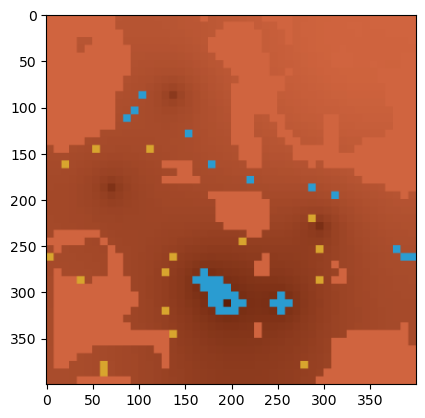

In [7]:
import matplotlib.pyplot as plt
env = gym.make("LuxAI_S2-v0")
env.reset(seed=0)
img = env.render("rgb_array")
plt.imshow(img)

**With the wrapper**, when we reset the environment it looks like this:

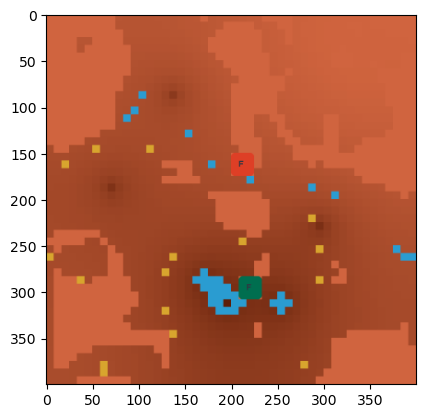

In [8]:
import matplotlib.pyplot as plt
env = gym.make("LuxAI_S2-v0")
env = SB3Wrapper(env, zero_bid, place_near_random_ice, controller=SimpleUnitDiscreteController(env.env_cfg))
env.reset(seed=0)
img = env.render("rgb_array")
plt.imshow(img)

Success! Our upgraded reset function makes the environment now start from the start of the normal game phase, meaning the action space can be consistently the same throughout the game.

## 4. Training with RL

In the previous tutorial, we saw how to train an agent with SB3 in single-agent environments. Handling true multi-agent via training separate or shared policies to control all agents requires a few extra things so instead, for the purpose of a tutorial we will treat Lux S2 like a single agent environment by training a policy for one team and letting the other team simply do nothing.

Moreover, we want to define our own reward function to encourage our robots to seek ice, dig it, and return to a factory so it can generate water and survive longer. To do this all, we will just create a custom environment wrapper.




In [9]:
import copy
class CustomEnvWrapper(gym.Wrapper):
    def __init__(self, env: gym.Env) -> None:
        """
        Adds a custom reward and turns the LuxAI_S2 environment into a single-agent environment for easy training
        """
        super().__init__(env)
        self.prev_step_metrics = None

    def step(self, action):
        agent = "player_0"
        opp_agent = "player_1"

        opp_factories = self.env.state.factories[opp_agent]
        for k in opp_factories.keys():
            factory = opp_factories[k]
             # set enemy factories to have 1000 water to keep them alive the whole around and treat the game as single-agent
            factory.cargo.water = 1000

        # submit actions for just one agent to make it single-agent
        # and save single-agent versions of the data below
        action = {agent: action}
        obs, _, done, info = self.env.step(action)
        obs = obs[agent]
        done = done[agent]
        
        # we collect stats on teams here. These are useful stats that can be used to help generate reward functions
        stats: StatsStateDict = self.env.state.stats[agent]

        info = dict()
        metrics = dict()
        metrics["ice_dug"] = (
            stats["generation"]["ice"]["HEAVY"] + stats["generation"]["ice"]["LIGHT"]
        )
        metrics["water_produced"] = stats["generation"]["water"]

        # we save these two to see often the agent updates robot action queues and how often enough
        # power to do so and succeed (less frequent updates = more power is saved)
        metrics["action_queue_updates_success"] = stats["action_queue_updates_success"]
        metrics["action_queue_updates_total"] = stats["action_queue_updates_total"]

        # we can save the metrics to info so we can use tensorboard to log them to get a glimpse into how our agent is behaving
        info["metrics"] = metrics

        reward = 0
        if self.prev_step_metrics is not None:
            # we check how much ice and water is produced and reward the agent for generating both
            ice_dug_this_step = metrics["ice_dug"] - self.prev_step_metrics["ice_dug"]
            water_produced_this_step = (
                metrics["water_produced"] - self.prev_step_metrics["water_produced"]
            )
            # we reward water production more as it is the most important resource for survival
            reward = ice_dug_this_step / 100 + water_produced_this_step

        self.prev_step_metrics = copy.deepcopy(metrics)
        return obs, reward, done, info

    def reset(self, **kwargs):
        obs = self.env.reset(**kwargs)["player_0"]
        self.prev_step_metrics = None
        return obs

### 3.1 Defining the Environment and using Wrappers

Next, we will define a `make_env` function and use it with SB3 to create multiple environments in parallel that scale with the number of CPU cores you have. A future tutorial will show a variant that creates a single jax-powered environment to achieve the same functionality but scaling with GPU.

We will use the SB3Wrapper, the controller and observation wrapper we defined, and the custom env wrapper as well. These put together will give us an environment that resets to the start of the normal game phase, has a consistent and simplified observation and action space, and contains our reward function.

In [10]:
from stable_baselines3.common.vec_env import SubprocVecEnv
from stable_baselines3.common.monitor import Monitor
from gym.wrappers import TimeLimit
def make_env(env_id: str, rank: int, seed: int = 0, max_episode_steps=200):
    def _init() -> gym.Env:
        # verbose = 0
        # collect_stats=True lets us track stats like total ice dug during an episode to help create reward functions
        # max factories set to 2 for simplification and keeping returns consistent as we survive longer 
        # if there are more initial resources
        env = gym.make(env_id, verbose=0, collect_stats=True, MAX_FACTORIES=2)

        # Add a SB3 wrapper to make it work with SB3 and simplify the action space with the controller
        # this will remove the bidding phase and factory placement phase. For factory placement we use
        # the provided place_near_random_ice function which will randomly select an ice tile and place a factory near it.
        env = SB3Wrapper(
            env,
            factory_placement_policy=place_near_random_ice,
            controller=SimpleUnitDiscreteController(env.env_cfg),
        )
        
        # changes observation to include a few simple features
        env = SimpleUnitObservationWrapper(
            env
        )
        
        # convert to single agent, adds our reward
        env = CustomEnvWrapper(env)  
        
        # Add a timelimit to the environment, which can truncate episodes, speed up training
        env = TimeLimit(
            env, max_episode_steps=max_episode_steps
        )
        env = Monitor(env) # for SB3 to allow it to record metrics
        env.reset(seed=seed + rank)
        set_random_seed(seed)
        return env

    return _init

Next we will define a useful callback function to log some of the custom metrics we defined earlier in the CustomEnvWrapper

In [11]:
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback
class TensorboardCallback(BaseCallback):
    def __init__(self, tag: str, verbose=0):
        super().__init__(verbose)
        self.tag = tag

    def _on_step(self) -> bool:
        c = 0

        for i, done in enumerate(self.locals["dones"]):
            if done:
                info = self.locals["infos"][i]
                c += 1
                for k in info["metrics"]:
                    stat = info["metrics"][k]
                    self.logger.record_mean(f"{self.tag}/{k}", stat)
        return True

### 3.2 Training Setup

Now we can prepare for training by creating training and evaluation environments, as well as defining our algorithm and model.

In [12]:
import os.path as osp
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.ppo import PPO

set_random_seed(42)
log_path = "logs/exp_1"
num_envs = 4

# set max episode steps to 200 for training environments to train faster
env = SubprocVecEnv([make_env("LuxAI_S2-v0", i, max_episode_steps=200) for i in range(num_envs)])
env.reset()
# set max episode steps to 1000 to match original environment
eval_env = SubprocVecEnv([make_env("LuxAI_S2-v0", i, max_episode_steps=1000) for i in range(4)])
eval_env.reset()
rollout_steps = 4000
policy_kwargs = dict(net_arch=(128, 128))
model = PPO(
    "MlpPolicy",
    env,
    n_steps=rollout_steps // num_envs,
    batch_size=800,
    learning_rate=3e-4,
    policy_kwargs=policy_kwargs,
    verbose=1,
    n_epochs=2,
    target_kl=0.05,
    gamma=0.99,
    tensorboard_log=osp.join(log_path),
)

eval_callback = EvalCallback(
    eval_env,
    best_model_save_path=osp.join(log_path, "models"),
    log_path=osp.join(log_path, "eval_logs"),
    eval_freq=24_000,
    deterministic=False,
    render=False,
    n_eval_episodes=5,
)

Using cpu device


With our callback functions and model defined, we can now begin training using `model.learn`. On CPU this training can take around 3-4 hours to train, on GPU it can take 30min to an hour to train. The hyperparameters and reward function can be improved to make it train much faster. A simple way to also increase training speed is to train on a machine with more CPU cores and increasing `num_envs` above. Kaggle notebooks by default only have 4, but with e.g. 10 you can easily train a policy in around 30 minutes.

If you want to skip this training you can also just use the pretrained model that's in the downloaded dataset for the RL kit called `best_model.dontunzipme`. (kaggle auto unzips files but we need to keep it as a zip so the file extention is called .dontunzipme but for submission just change it to a .zip)

To track the progress we recommend using tensorboard which you can run with
```
tensorboard --logdir logs
```

In [13]:
total_timesteps = 10_000_000
model.learn(
    total_timesteps,
    callback=[TensorboardCallback(tag="train_metrics"), eval_callback],
)
model.save(osp.join(log_path, "models/latest_model"))

Logging to logs/exp_1\PPO_1
----------------------------------------------
| rollout/                        |          |
|    ep_len_mean                  | 200      |
|    ep_rew_mean                  | 0        |
| time/                           |          |
|    fps                          | 1697     |
|    iterations                   | 1        |
|    time_elapsed                 | 2        |
|    total_timesteps              | 4000     |
| train_metrics/                  |          |
|    action_queue_updates_success | 145      |
|    action_queue_updates_total   | 177      |
|    ice_dug                      | 0        |
|    water_produced               | 0        |
----------------------------------------------
---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 0.02          |
| time/                           |               |
|    fp

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 0.056        |
| time/                           |              |
|    fps                          | 1658         |
|    iterations                   | 8            |
|    time_elapsed                 | 19           |
|    total_timesteps              | 32000        |
| train/                          |              |
|    approx_kl                    | 0.0005054667 |
|    clip_fraction                | 0            |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -2.48        |
|    explained_variance           | 0.924        |
|    learning_rate                | 0.0003       |
|    loss                         | -0.00543     |
|    n_updates                    | 14           |
|    policy_gradient_loss         | -0.00253     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 0.004        |
| time/                           |              |
|    fps                          | 1617         |
|    iterations                   | 15           |
|    time_elapsed                 | 37           |
|    total_timesteps              | 60000        |
| train/                          |              |
|    approx_kl                    | 0.0025576232 |
|    clip_fraction                | 0            |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -2.36        |
|    explained_variance           | 0.844        |
|    learning_rate                | 0.0003       |
|    loss                         | -0.00746     |
|    n_updates                    | 28           |
|    policy_gradient_loss         | -0.00235     |
|    value_loss                

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 0.002         |
| time/                           |               |
|    fps                          | 1609          |
|    iterations                   | 22            |
|    time_elapsed                 | 54            |
|    total_timesteps              | 88000         |
| train/                          |               |
|    approx_kl                    | 0.00021103169 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -2.37         |
|    explained_variance           | 0.491         |
|    learning_rate                | 0.0003        |
|    loss                         | -0.000476     |
|    n_updates                    | 42            |
|    policy_gradient_loss         | -0.000178     |
|    value_l

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 0.05         |
| time/                           |              |
|    fps                          | 1576         |
|    iterations                   | 28           |
|    time_elapsed                 | 71           |
|    total_timesteps              | 112000       |
| train/                          |              |
|    approx_kl                    | 0.0013092573 |
|    clip_fraction                | 0            |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -2.35        |
|    explained_variance           | 0.289        |
|    learning_rate                | 0.0003       |
|    loss                         | 0.000849     |
|    n_updates                    | 54           |
|    policy_gradient_loss         | -0.00138     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 0.602        |
| time/                           |              |
|    fps                          | 1558         |
|    iterations                   | 35           |
|    time_elapsed                 | 89           |
|    total_timesteps              | 140000       |
| train/                          |              |
|    approx_kl                    | 0.0017498946 |
|    clip_fraction                | 0            |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -2.16        |
|    explained_variance           | 0.202        |
|    learning_rate                | 0.0003       |
|    loss                         | 0.00301      |
|    n_updates                    | 68           |
|    policy_gradient_loss         | -0.00103     |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 4.22        |
| time/                           |             |
|    fps                          | 1542        |
|    iterations                   | 42          |
|    time_elapsed                 | 108         |
|    total_timesteps              | 168000      |
| train/                          |             |
|    approx_kl                    | 0.001647447 |
|    clip_fraction                | 0           |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -1.76       |
|    explained_variance           | 0.052       |
|    learning_rate                | 0.0003      |
|    loss                         | 2.6         |
|    n_updates                    | 82          |
|    policy_gradient_loss         | -0.000655   |
|    value_loss                   | 6.13        |


New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | 7.42     |
| time/              |          |
|    fps             | 1523     |
|    iterations      | 48       |
|    time_elapsed    | 125      |
|    total_timesteps | 192000   |
---------------------------------
---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 6.83          |
| time/                           |               |
|    fps                          | 1524          |
|    iterations                   | 49            |
|    time_elapsed                 | 128           |
|    total_timesteps              | 196000        |
| train/                          |               |
|    approx_kl                    | 5.4833887e-05 |
|    clip_fraction                | 0             |
|    clip_rang

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 11.3          |
| time/                           |               |
|    fps                          | 1529          |
|    iterations                   | 55            |
|    time_elapsed                 | 143           |
|    total_timesteps              | 220000        |
| train/                          |               |
|    approx_kl                    | 0.00016187431 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.56         |
|    explained_variance           | 0.146         |
|    learning_rate                | 0.0003        |
|    loss                         | 4.41          |
|    n_updates                    | 108           |
|    policy_gradient_loss         | -0.000504     |
|    value_l

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 15.8          |
| time/                           |               |
|    fps                          | 1534          |
|    iterations                   | 62            |
|    time_elapsed                 | 161           |
|    total_timesteps              | 248000        |
| train/                          |               |
|    approx_kl                    | 0.00019470109 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.67         |
|    explained_variance           | 0.124         |
|    learning_rate                | 0.0003        |
|    loss                         | 13.9          |
|    n_updates                    | 122           |
|    policy_gradient_loss         | -0.000228     |
|    value_l

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 8.44          |
| time/                           |               |
|    fps                          | 1538          |
|    iterations                   | 69            |
|    time_elapsed                 | 179           |
|    total_timesteps              | 276000        |
| train/                          |               |
|    approx_kl                    | 0.00018235877 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.65         |
|    explained_variance           | 0.565         |
|    learning_rate                | 0.0003        |
|    loss                         | 1.64          |
|    n_updates                    | 136           |
|    policy_gradient_loss         | -0.000167     |
|    value_l

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 4.83          |
| time/                           |               |
|    fps                          | 1527          |
|    iterations                   | 75            |
|    time_elapsed                 | 196           |
|    total_timesteps              | 300000        |
| train/                          |               |
|    approx_kl                    | 0.00018905972 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.78         |
|    explained_variance           | 0.344         |
|    learning_rate                | 0.0003        |
|    loss                         | 4.64          |
|    n_updates                    | 148           |
|    policy_gradient_loss         | -0.00029      |
|    value_l

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 14           |
| time/                           |              |
|    fps                          | 1521         |
|    iterations                   | 82           |
|    time_elapsed                 | 215          |
|    total_timesteps              | 328000       |
| train/                          |              |
|    approx_kl                    | 0.0006899178 |
|    clip_fraction                | 0            |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.66        |
|    explained_variance           | 0.101        |
|    learning_rate                | 0.0003       |
|    loss                         | 14.8         |
|    n_updates                    | 162          |
|    policy_gradient_loss         | -0.000239    |
|    value_loss                

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 14.9          |
| time/                           |               |
|    fps                          | 1515          |
|    iterations                   | 89            |
|    time_elapsed                 | 234           |
|    total_timesteps              | 356000        |
| train/                          |               |
|    approx_kl                    | 4.6581776e-05 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.64         |
|    explained_variance           | 0.192         |
|    learning_rate                | 0.0003        |
|    loss                         | 8.36          |
|    n_updates                    | 176           |
|    policy_gradient_loss         | -0.000254     |
|    value_l

Eval num_timesteps=384000, episode_reward=13.00 +/- 24.91
Episode length: 313.00 +/- 24.00
---------------------------------------------------
| eval/                           |               |
|    mean_ep_length               | 313           |
|    mean_reward                  | 13            |
| time/                           |               |
|    total_timesteps              | 384000        |
| train/                          |               |
|    approx_kl                    | 0.00032140553 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.6          |
|    explained_variance           | 0.276         |
|    learning_rate                | 0.0003        |
|    loss                         | 5.73          |
|    n_updates                    | 190           |
|    policy_gradient_loss         | -0.000629     |
|    value_loss                   | 13.2          |
| train_metrics/         

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 14          |
| time/                           |             |
|    fps                          | 1510        |
|    iterations                   | 102         |
|    time_elapsed                 | 270         |
|    total_timesteps              | 408000      |
| train/                          |             |
|    approx_kl                    | 0.000583419 |
|    clip_fraction                | 0           |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -1.46       |
|    explained_variance           | 0.213       |
|    learning_rate                | 0.0003      |
|    loss                         | 5.43        |
|    n_updates                    | 202         |
|    policy_gradient_loss         | -2.48e-05   |
|    value_loss                   | 11          |


---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 13.5          |
| time/                           |               |
|    fps                          | 1511          |
|    iterations                   | 109           |
|    time_elapsed                 | 288           |
|    total_timesteps              | 436000        |
| train/                          |               |
|    approx_kl                    | 0.00020243818 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.39         |
|    explained_variance           | 0.131         |
|    learning_rate                | 0.0003        |
|    loss                         | 29.7          |
|    n_updates                    | 216           |
|    policy_gradient_loss         | -0.00037      |
|    value_l

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 13.6          |
| time/                           |               |
|    fps                          | 1513          |
|    iterations                   | 116           |
|    time_elapsed                 | 306           |
|    total_timesteps              | 464000        |
| train/                          |               |
|    approx_kl                    | 0.00029787753 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.27         |
|    explained_variance           | 0.027         |
|    learning_rate                | 0.0003        |
|    loss                         | 15.5          |
|    n_updates                    | 230           |
|    policy_gradient_loss         | -0.000165     |
|    value_l

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 22.4          |
| time/                           |               |
|    fps                          | 1503          |
|    iterations                   | 122           |
|    time_elapsed                 | 324           |
|    total_timesteps              | 488000        |
| train/                          |               |
|    approx_kl                    | 0.00025431003 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.3          |
|    explained_variance           | 0.102         |
|    learning_rate                | 0.0003        |
|    loss                         | 18.6          |
|    n_updates                    | 242           |
|    policy_gradient_loss         | -0.000255     |
|    value_l

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 20.3          |
| time/                           |               |
|    fps                          | 1498          |
|    iterations                   | 129           |
|    time_elapsed                 | 344           |
|    total_timesteps              | 516000        |
| train/                          |               |
|    approx_kl                    | 0.00013167065 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.47         |
|    explained_variance           | 0.229         |
|    learning_rate                | 0.0003        |
|    loss                         | 19.5          |
|    n_updates                    | 256           |
|    policy_gradient_loss         | -1.73e-05     |
|    value_l

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 18.3         |
| time/                           |              |
|    fps                          | 1497         |
|    iterations                   | 136          |
|    time_elapsed                 | 363          |
|    total_timesteps              | 544000       |
| train/                          |              |
|    approx_kl                    | 0.0002795876 |
|    clip_fraction                | 0            |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.47        |
|    explained_variance           | 0.202        |
|    learning_rate                | 0.0003       |
|    loss                         | 37.9         |
|    n_updates                    | 270          |
|    policy_gradient_loss         | -1.65e-05    |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 16.8         |
| time/                           |              |
|    fps                          | 1501         |
|    iterations                   | 143          |
|    time_elapsed                 | 381          |
|    total_timesteps              | 572000       |
| train/                          |              |
|    approx_kl                    | 0.0003338012 |
|    clip_fraction                | 0            |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.51        |
|    explained_variance           | 0.298        |
|    learning_rate                | 0.0003       |
|    loss                         | 33.8         |
|    n_updates                    | 284          |
|    policy_gradient_loss         | -9.98e-05    |
|    value_loss                

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 15.4          |
| time/                           |               |
|    fps                          | 1499          |
|    iterations                   | 149           |
|    time_elapsed                 | 397           |
|    total_timesteps              | 596000        |
| train/                          |               |
|    approx_kl                    | 0.00048887543 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.57         |
|    explained_variance           | 0.407         |
|    learning_rate                | 0.0003        |
|    loss                         | 10            |
|    n_updates                    | 296           |
|    policy_gradient_loss         | -0.000444     |
|    value_l

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 22.6          |
| time/                           |               |
|    fps                          | 1502          |
|    iterations                   | 156           |
|    time_elapsed                 | 415           |
|    total_timesteps              | 624000        |
| train/                          |               |
|    approx_kl                    | 0.00052199705 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.44         |
|    explained_variance           | 0.239         |
|    learning_rate                | 0.0003        |
|    loss                         | 36.8          |
|    n_updates                    | 310           |
|    policy_gradient_loss         | -0.000183     |
|    value_l

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 15.6         |
| time/                           |              |
|    fps                          | 1505         |
|    iterations                   | 163          |
|    time_elapsed                 | 433          |
|    total_timesteps              | 652000       |
| train/                          |              |
|    approx_kl                    | 0.0003746475 |
|    clip_fraction                | 0            |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.4         |
|    explained_variance           | 0.382        |
|    learning_rate                | 0.0003       |
|    loss                         | 3.68         |
|    n_updates                    | 324          |
|    policy_gradient_loss         | -0.000202    |
|    value_loss                

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 20.7          |
| time/                           |               |
|    fps                          | 1499          |
|    iterations                   | 169           |
|    time_elapsed                 | 450           |
|    total_timesteps              | 676000        |
| train/                          |               |
|    approx_kl                    | 0.00019637588 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.41         |
|    explained_variance           | 0.202         |
|    learning_rate                | 0.0003        |
|    loss                         | 27.6          |
|    n_updates                    | 336           |
|    policy_gradient_loss         | -7.64e-05     |
|    value_l

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 20.8         |
| time/                           |              |
|    fps                          | 1498         |
|    iterations                   | 176          |
|    time_elapsed                 | 469          |
|    total_timesteps              | 704000       |
| train/                          |              |
|    approx_kl                    | 4.463804e-05 |
|    clip_fraction                | 0            |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.41        |
|    explained_variance           | 0.319        |
|    learning_rate                | 0.0003       |
|    loss                         | 8.94         |
|    n_updates                    | 350          |
|    policy_gradient_loss         | -9.1e-05     |
|    value_loss                

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 26.3          |
| time/                           |               |
|    fps                          | 1499          |
|    iterations                   | 183           |
|    time_elapsed                 | 488           |
|    total_timesteps              | 732000        |
| train/                          |               |
|    approx_kl                    | 0.00035508192 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.61         |
|    explained_variance           | 0.254         |
|    learning_rate                | 0.0003        |
|    loss                         | 45.2          |
|    n_updates                    | 364           |
|    policy_gradient_loss         | 0.00028       |
|    value_l

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 24.4         |
| time/                           |              |
|    fps                          | 1502         |
|    iterations                   | 190          |
|    time_elapsed                 | 505          |
|    total_timesteps              | 760000       |
| train/                          |              |
|    approx_kl                    | 0.0002531808 |
|    clip_fraction                | 0            |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.75        |
|    explained_variance           | 0.4          |
|    learning_rate                | 0.0003       |
|    loss                         | 24.7         |
|    n_updates                    | 378          |
|    policy_gradient_loss         | -1.56e-05    |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 29.1         |
| time/                           |              |
|    fps                          | 1501         |
|    iterations                   | 196          |
|    time_elapsed                 | 522          |
|    total_timesteps              | 784000       |
| train/                          |              |
|    approx_kl                    | 0.0005752222 |
|    clip_fraction                | 0            |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.6         |
|    explained_variance           | 0.401        |
|    learning_rate                | 0.0003       |
|    loss                         | 26.9         |
|    n_updates                    | 390          |
|    policy_gradient_loss         | -0.000126    |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 30.1         |
| time/                           |              |
|    fps                          | 1503         |
|    iterations                   | 203          |
|    time_elapsed                 | 539          |
|    total_timesteps              | 812000       |
| train/                          |              |
|    approx_kl                    | 0.0008521217 |
|    clip_fraction                | 0            |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.49        |
|    explained_variance           | 0.325        |
|    learning_rate                | 0.0003       |
|    loss                         | 43.4         |
|    n_updates                    | 404          |
|    policy_gradient_loss         | -0.000332    |
|    value_loss                

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 18.6          |
| time/                           |               |
|    fps                          | 1505          |
|    iterations                   | 210           |
|    time_elapsed                 | 557           |
|    total_timesteps              | 840000        |
| train/                          |               |
|    approx_kl                    | 0.00011491011 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.7          |
|    explained_variance           | 0.455         |
|    learning_rate                | 0.0003        |
|    loss                         | 24.5          |
|    n_updates                    | 418           |
|    policy_gradient_loss         | 9.49e-06      |
|    value_l

New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | 25.7     |
| time/              |          |
|    fps             | 1500     |
|    iterations      | 216      |
|    time_elapsed    | 575      |
|    total_timesteps | 864000   |
---------------------------------
--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 24.3         |
| time/                           |              |
|    fps                          | 1500         |
|    iterations                   | 217          |
|    time_elapsed                 | 578          |
|    total_timesteps              | 868000       |
| train/                          |              |
|    approx_kl                    | 0.0002705732 |
|    clip_fraction                | 0            |
|    clip_range           

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 14.8          |
| time/                           |               |
|    fps                          | 1499          |
|    iterations                   | 223           |
|    time_elapsed                 | 594           |
|    total_timesteps              | 892000        |
| train/                          |               |
|    approx_kl                    | 0.00010434371 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.79         |
|    explained_variance           | 0.561         |
|    learning_rate                | 0.0003        |
|    loss                         | 16            |
|    n_updates                    | 444           |
|    policy_gradient_loss         | -0.00033      |
|    value_l

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 27.1          |
| time/                           |               |
|    fps                          | 1501          |
|    iterations                   | 230           |
|    time_elapsed                 | 612           |
|    total_timesteps              | 920000        |
| train/                          |               |
|    approx_kl                    | 0.00033971513 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.52         |
|    explained_variance           | 0.369         |
|    learning_rate                | 0.0003        |
|    loss                         | 44.7          |
|    n_updates                    | 458           |
|    policy_gradient_loss         | -0.000249     |
|    value_l

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 21.9         |
| time/                           |              |
|    fps                          | 1503         |
|    iterations                   | 237          |
|    time_elapsed                 | 630          |
|    total_timesteps              | 948000       |
| train/                          |              |
|    approx_kl                    | 0.0013952944 |
|    clip_fraction                | 0.00125      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.56        |
|    explained_variance           | 0.424        |
|    learning_rate                | 0.0003       |
|    loss                         | 23           |
|    n_updates                    | 472          |
|    policy_gradient_loss         | 0.000132     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 24           |
| time/                           |              |
|    fps                          | 1501         |
|    iterations                   | 243          |
|    time_elapsed                 | 647          |
|    total_timesteps              | 972000       |
| train/                          |              |
|    approx_kl                    | 6.562859e-05 |
|    clip_fraction                | 0            |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.62        |
|    explained_variance           | 0.352        |
|    learning_rate                | 0.0003       |
|    loss                         | 36.8         |
|    n_updates                    | 484          |
|    policy_gradient_loss         | -5.64e-05    |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 28.1         |
| time/                           |              |
|    fps                          | 1504         |
|    iterations                   | 250          |
|    time_elapsed                 | 664          |
|    total_timesteps              | 1000000      |
| train/                          |              |
|    approx_kl                    | 0.0002387526 |
|    clip_fraction                | 0            |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.58        |
|    explained_variance           | 0.426        |
|    learning_rate                | 0.0003       |
|    loss                         | 29.3         |
|    n_updates                    | 498          |
|    policy_gradient_loss         | -0.000229    |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 30.7         |
| time/                           |              |
|    fps                          | 1504         |
|    iterations                   | 257          |
|    time_elapsed                 | 683          |
|    total_timesteps              | 1028000      |
| train/                          |              |
|    approx_kl                    | 0.0012422693 |
|    clip_fraction                | 0.00325      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.5         |
|    explained_variance           | 0.435        |
|    learning_rate                | 0.0003       |
|    loss                         | 34.6         |
|    n_updates                    | 512          |
|    policy_gradient_loss         | -0.000532    |
|    value_loss                

Eval num_timesteps=1056000, episode_reward=54.20 +/- 108.40
Episode length: 353.00 +/- 104.00
--------------------------------------------------
| eval/                           |              |
|    mean_ep_length               | 353          |
|    mean_reward                  | 54.2         |
| time/                           |              |
|    total_timesteps              | 1056000      |
| train/                          |              |
|    approx_kl                    | 0.0019593928 |
|    clip_fraction                | 0.00425      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.6         |
|    explained_variance           | 0.49         |
|    learning_rate                | 0.0003       |
|    loss                         | 32           |
|    n_updates                    | 526          |
|    policy_gradient_loss         | 0.000118     |
|    value_loss                   | 69.4         |
| train_metrics/                  |    

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 16.7         |
| time/                           |              |
|    fps                          | 1500         |
|    iterations                   | 270          |
|    time_elapsed                 | 719          |
|    total_timesteps              | 1080000      |
| train/                          |              |
|    approx_kl                    | 0.0009919308 |
|    clip_fraction                | 0            |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.86        |
|    explained_variance           | 0.52         |
|    learning_rate                | 0.0003       |
|    loss                         | 29.2         |
|    n_updates                    | 538          |
|    policy_gradient_loss         | -0.000627    |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 24.7         |
| time/                           |              |
|    fps                          | 1502         |
|    iterations                   | 277          |
|    time_elapsed                 | 737          |
|    total_timesteps              | 1108000      |
| train/                          |              |
|    approx_kl                    | 0.0013585172 |
|    clip_fraction                | 0            |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.86        |
|    explained_variance           | 0.677        |
|    learning_rate                | 0.0003       |
|    loss                         | 8.03         |
|    n_updates                    | 552          |
|    policy_gradient_loss         | 0.000625     |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 24.9        |
| time/                           |             |
|    fps                          | 1504        |
|    iterations                   | 284         |
|    time_elapsed                 | 755         |
|    total_timesteps              | 1136000     |
| train/                          |             |
|    approx_kl                    | 0.001426445 |
|    clip_fraction                | 0.00275     |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -1.61       |
|    explained_variance           | 0.563       |
|    learning_rate                | 0.0003      |
|    loss                         | 38          |
|    n_updates                    | 566         |
|    policy_gradient_loss         | -0.00128    |
|    value_loss                   | 64.9        |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 33.7         |
| time/                           |              |
|    fps                          | 1503         |
|    iterations                   | 290          |
|    time_elapsed                 | 771          |
|    total_timesteps              | 1160000      |
| train/                          |              |
|    approx_kl                    | 0.0009125719 |
|    clip_fraction                | 0            |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.77        |
|    explained_variance           | 0.569        |
|    learning_rate                | 0.0003       |
|    loss                         | 33.9         |
|    n_updates                    | 578          |
|    policy_gradient_loss         | 0.000429     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 32.2         |
| time/                           |              |
|    fps                          | 1504         |
|    iterations                   | 297          |
|    time_elapsed                 | 789          |
|    total_timesteps              | 1188000      |
| train/                          |              |
|    approx_kl                    | 0.0009486526 |
|    clip_fraction                | 0.00025      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.82        |
|    explained_variance           | 0.678        |
|    learning_rate                | 0.0003       |
|    loss                         | 20.3         |
|    n_updates                    | 592          |
|    policy_gradient_loss         | -0.000506    |
|    value_loss                

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 49.6          |
| time/                           |               |
|    fps                          | 1504          |
|    iterations                   | 304           |
|    time_elapsed                 | 808           |
|    total_timesteps              | 1216000       |
| train/                          |               |
|    approx_kl                    | 0.00018336854 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.57         |
|    explained_variance           | 0.502         |
|    learning_rate                | 0.0003        |
|    loss                         | 95.3          |
|    n_updates                    | 606           |
|    policy_gradient_loss         | 1.21e-05      |
|    value_l

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 41           |
| time/                           |              |
|    fps                          | 1503         |
|    iterations                   | 311          |
|    time_elapsed                 | 827          |
|    total_timesteps              | 1244000      |
| train/                          |              |
|    approx_kl                    | 0.0017645413 |
|    clip_fraction                | 0.0025       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.61        |
|    explained_variance           | 0.581        |
|    learning_rate                | 0.0003       |
|    loss                         | 40           |
|    n_updates                    | 620          |
|    policy_gradient_loss         | 0.000502     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 48.1         |
| time/                           |              |
|    fps                          | 1501         |
|    iterations                   | 317          |
|    time_elapsed                 | 844          |
|    total_timesteps              | 1268000      |
| train/                          |              |
|    approx_kl                    | 0.0001520466 |
|    clip_fraction                | 0            |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.55        |
|    explained_variance           | 0.575        |
|    learning_rate                | 0.0003       |
|    loss                         | 47.5         |
|    n_updates                    | 632          |
|    policy_gradient_loss         | -9.15e-05    |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 34.8         |
| time/                           |              |
|    fps                          | 1502         |
|    iterations                   | 324          |
|    time_elapsed                 | 862          |
|    total_timesteps              | 1296000      |
| train/                          |              |
|    approx_kl                    | 0.0021667103 |
|    clip_fraction                | 0.0045       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.76        |
|    explained_variance           | 0.552        |
|    learning_rate                | 0.0003       |
|    loss                         | 43.7         |
|    n_updates                    | 646          |
|    policy_gradient_loss         | 0.00077      |
|    value_loss                

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 45.8          |
| time/                           |               |
|    fps                          | 1504          |
|    iterations                   | 331           |
|    time_elapsed                 | 880           |
|    total_timesteps              | 1324000       |
| train/                          |               |
|    approx_kl                    | 0.00094484846 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.72         |
|    explained_variance           | 0.606         |
|    learning_rate                | 0.0003        |
|    loss                         | 114           |
|    n_updates                    | 660           |
|    policy_gradient_loss         | 6.2e-05       |
|    value_l

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 66.4         |
| time/                           |              |
|    fps                          | 1503         |
|    iterations                   | 337          |
|    time_elapsed                 | 896          |
|    total_timesteps              | 1348000      |
| train/                          |              |
|    approx_kl                    | 0.0011243586 |
|    clip_fraction                | 0.001        |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.44        |
|    explained_variance           | 0.503        |
|    learning_rate                | 0.0003       |
|    loss                         | 108          |
|    n_updates                    | 672          |
|    policy_gradient_loss         | 1.67e-05     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 74.1         |
| time/                           |              |
|    fps                          | 1505         |
|    iterations                   | 344          |
|    time_elapsed                 | 914          |
|    total_timesteps              | 1376000      |
| train/                          |              |
|    approx_kl                    | 0.0007238622 |
|    clip_fraction                | 0.000625     |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.5         |
|    explained_variance           | 0.495        |
|    learning_rate                | 0.0003       |
|    loss                         | 96.1         |
|    n_updates                    | 686          |
|    policy_gradient_loss         | -0.000235    |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 61           |
| time/                           |              |
|    fps                          | 1504         |
|    iterations                   | 351          |
|    time_elapsed                 | 933          |
|    total_timesteps              | 1404000      |
| train/                          |              |
|    approx_kl                    | 0.0008587365 |
|    clip_fraction                | 0.00237      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.32        |
|    explained_variance           | 0.508        |
|    learning_rate                | 0.0003       |
|    loss                         | 39.1         |
|    n_updates                    | 700          |
|    policy_gradient_loss         | -0.000491    |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 91           |
| time/                           |              |
|    fps                          | 1503         |
|    iterations                   | 358          |
|    time_elapsed                 | 952          |
|    total_timesteps              | 1432000      |
| train/                          |              |
|    approx_kl                    | 0.0008922076 |
|    clip_fraction                | 0.0015       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.2         |
|    explained_variance           | 0.366        |
|    learning_rate                | 0.0003       |
|    loss                         | 138          |
|    n_updates                    | 714          |
|    policy_gradient_loss         | -0.000234    |
|    value_loss                

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 88.1          |
| time/                           |               |
|    fps                          | 1500          |
|    iterations                   | 364           |
|    time_elapsed                 | 970           |
|    total_timesteps              | 1456000       |
| train/                          |               |
|    approx_kl                    | 0.00041468404 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.36         |
|    explained_variance           | 0.516         |
|    learning_rate                | 0.0003        |
|    loss                         | 105           |
|    n_updates                    | 726           |
|    policy_gradient_loss         | 0.000508      |
|    value_l

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 80            |
| time/                           |               |
|    fps                          | 1502          |
|    iterations                   | 371           |
|    time_elapsed                 | 987           |
|    total_timesteps              | 1484000       |
| train/                          |               |
|    approx_kl                    | 0.00029605086 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.38         |
|    explained_variance           | 0.448         |
|    learning_rate                | 0.0003        |
|    loss                         | 116           |
|    n_updates                    | 740           |
|    policy_gradient_loss         | 0.000176      |
|    value_l

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 73.4          |
| time/                           |               |
|    fps                          | 1503          |
|    iterations                   | 378           |
|    time_elapsed                 | 1005          |
|    total_timesteps              | 1512000       |
| train/                          |               |
|    approx_kl                    | 0.00021272979 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.42         |
|    explained_variance           | 0.517         |
|    learning_rate                | 0.0003        |
|    loss                         | 81.7          |
|    n_updates                    | 754           |
|    policy_gradient_loss         | 0.000174      |
|    value_l

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | 61.6     |
| time/              |          |
|    fps             | 1502     |
|    iterations      | 384      |
|    time_elapsed    | 1022     |
|    total_timesteps | 1536000  |
---------------------------------
-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 61.1        |
| time/                           |             |
|    fps                          | 1502        |
|    iterations                   | 385         |
|    time_elapsed                 | 1025        |
|    total_timesteps              | 1540000     |
| train/                          |             |
|    approx_kl                    | 0.002821663 |
|    clip_fraction                | 0.0106      |
|    clip_range                   | 0.2         |
|    entro

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 67.9          |
| time/                           |               |
|    fps                          | 1502          |
|    iterations                   | 391           |
|    time_elapsed                 | 1040          |
|    total_timesteps              | 1564000       |
| train/                          |               |
|    approx_kl                    | 0.00047872547 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.38         |
|    explained_variance           | 0.496         |
|    learning_rate                | 0.0003        |
|    loss                         | 122           |
|    n_updates                    | 780           |
|    policy_gradient_loss         | 0.000106      |
|    value_l

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 56.7          |
| time/                           |               |
|    fps                          | 1502          |
|    iterations                   | 398           |
|    time_elapsed                 | 1059          |
|    total_timesteps              | 1592000       |
| train/                          |               |
|    approx_kl                    | 7.9623744e-05 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.49         |
|    explained_variance           | 0.514         |
|    learning_rate                | 0.0003        |
|    loss                         | 78.9          |
|    n_updates                    | 794           |
|    policy_gradient_loss         | -0.000207     |
|    value_l

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 88.7         |
| time/                           |              |
|    fps                          | 1501         |
|    iterations                   | 405          |
|    time_elapsed                 | 1079         |
|    total_timesteps              | 1620000      |
| train/                          |              |
|    approx_kl                    | 0.0015639432 |
|    clip_fraction                | 0.00662      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.25        |
|    explained_variance           | 0.409        |
|    learning_rate                | 0.0003       |
|    loss                         | 81           |
|    n_updates                    | 808          |
|    policy_gradient_loss         | -0.000364    |
|    value_loss                

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 78.4          |
| time/                           |               |
|    fps                          | 1498          |
|    iterations                   | 411           |
|    time_elapsed                 | 1096          |
|    total_timesteps              | 1644000       |
| train/                          |               |
|    approx_kl                    | 0.00046093678 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.45         |
|    explained_variance           | 0.568         |
|    learning_rate                | 0.0003        |
|    loss                         | 97            |
|    n_updates                    | 820           |
|    policy_gradient_loss         | -1.44e-06     |
|    value_l

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 87.1          |
| time/                           |               |
|    fps                          | 1500          |
|    iterations                   | 418           |
|    time_elapsed                 | 1114          |
|    total_timesteps              | 1672000       |
| train/                          |               |
|    approx_kl                    | 0.00023303236 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.43         |
|    explained_variance           | 0.516         |
|    learning_rate                | 0.0003        |
|    loss                         | 139           |
|    n_updates                    | 834           |
|    policy_gradient_loss         | -0.000233     |
|    value_l

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 55            |
| time/                           |               |
|    fps                          | 1501          |
|    iterations                   | 425           |
|    time_elapsed                 | 1132          |
|    total_timesteps              | 1700000       |
| train/                          |               |
|    approx_kl                    | 0.00024734339 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.45         |
|    explained_variance           | 0.485         |
|    learning_rate                | 0.0003        |
|    loss                         | 87.2          |
|    n_updates                    | 848           |
|    policy_gradient_loss         | -0.000176     |
|    value_l

Eval num_timesteps=1728000, episode_reward=230.32 +/- 189.99
Episode length: 519.00 +/- 180.71
---------------------------------------------------
| eval/                           |               |
|    mean_ep_length               | 519           |
|    mean_reward                  | 230           |
| time/                           |               |
|    total_timesteps              | 1728000       |
| train/                          |               |
|    approx_kl                    | 0.00028414614 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.42         |
|    explained_variance           | 0.552         |
|    learning_rate                | 0.0003        |
|    loss                         | 128           |
|    n_updates                    | 862           |
|    policy_gradient_loss         | -5.48e-05     |
|    value_loss                   | 236           |
| train_metrics/     

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 93.5         |
| time/                           |              |
|    fps                          | 1500         |
|    iterations                   | 438          |
|    time_elapsed                 | 1167         |
|    total_timesteps              | 1752000      |
| train/                          |              |
|    approx_kl                    | 0.0009190426 |
|    clip_fraction                | 0            |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.54        |
|    explained_variance           | 0.668        |
|    learning_rate                | 0.0003       |
|    loss                         | 102          |
|    n_updates                    | 874          |
|    policy_gradient_loss         | 0.000396     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 81.1         |
| time/                           |              |
|    fps                          | 1502         |
|    iterations                   | 445          |
|    time_elapsed                 | 1184         |
|    total_timesteps              | 1780000      |
| train/                          |              |
|    approx_kl                    | 0.0004419113 |
|    clip_fraction                | 0            |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.36        |
|    explained_variance           | 0.491        |
|    learning_rate                | 0.0003       |
|    loss                         | 104          |
|    n_updates                    | 888          |
|    policy_gradient_loss         | 0.00047      |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 74.3         |
| time/                           |              |
|    fps                          | 1501         |
|    iterations                   | 452          |
|    time_elapsed                 | 1204         |
|    total_timesteps              | 1808000      |
| train/                          |              |
|    approx_kl                    | 0.0002529552 |
|    clip_fraction                | 0            |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.46        |
|    explained_variance           | 0.554        |
|    learning_rate                | 0.0003       |
|    loss                         | 85           |
|    n_updates                    | 902          |
|    policy_gradient_loss         | -4.53e-05    |
|    value_loss                

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 92.8          |
| time/                           |               |
|    fps                          | 1497          |
|    iterations                   | 458           |
|    time_elapsed                 | 1223          |
|    total_timesteps              | 1832000       |
| train/                          |               |
|    approx_kl                    | 0.00021672419 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.37         |
|    explained_variance           | 0.575         |
|    learning_rate                | 0.0003        |
|    loss                         | 105           |
|    n_updates                    | 914           |
|    policy_gradient_loss         | -0.000517     |
|    value_l

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 92.1          |
| time/                           |               |
|    fps                          | 1496          |
|    iterations                   | 465           |
|    time_elapsed                 | 1243          |
|    total_timesteps              | 1860000       |
| train/                          |               |
|    approx_kl                    | 0.00094423274 |
|    clip_fraction                | 0.0015        |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.24         |
|    explained_variance           | 0.451         |
|    learning_rate                | 0.0003        |
|    loss                         | 68.9          |
|    n_updates                    | 928           |
|    policy_gradient_loss         | -0.000454     |
|    value_l

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 88.4         |
| time/                           |              |
|    fps                          | 1496         |
|    iterations                   | 472          |
|    time_elapsed                 | 1261         |
|    total_timesteps              | 1888000      |
| train/                          |              |
|    approx_kl                    | 0.0001269741 |
|    clip_fraction                | 0            |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.48        |
|    explained_variance           | 0.591        |
|    learning_rate                | 0.0003       |
|    loss                         | 128          |
|    n_updates                    | 942          |
|    policy_gradient_loss         | -0.00019     |
|    value_loss                

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 91.9          |
| time/                           |               |
|    fps                          | 1497          |
|    iterations                   | 479           |
|    time_elapsed                 | 1279          |
|    total_timesteps              | 1916000       |
| train/                          |               |
|    approx_kl                    | 0.00021552714 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.37         |
|    explained_variance           | 0.54          |
|    learning_rate                | 0.0003        |
|    loss                         | 104           |
|    n_updates                    | 956           |
|    policy_gradient_loss         | -0.000262     |
|    value_l

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 103          |
| time/                           |              |
|    fps                          | 1493         |
|    iterations                   | 485          |
|    time_elapsed                 | 1298         |
|    total_timesteps              | 1940000      |
| train/                          |              |
|    approx_kl                    | 0.0003643941 |
|    clip_fraction                | 0            |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.38        |
|    explained_variance           | 0.552        |
|    learning_rate                | 0.0003       |
|    loss                         | 179          |
|    n_updates                    | 968          |
|    policy_gradient_loss         | 0.000414     |
|    value_loss                

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 99.2          |
| time/                           |               |
|    fps                          | 1492          |
|    iterations                   | 492           |
|    time_elapsed                 | 1318          |
|    total_timesteps              | 1968000       |
| train/                          |               |
|    approx_kl                    | 0.00024358885 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.38         |
|    explained_variance           | 0.588         |
|    learning_rate                | 0.0003        |
|    loss                         | 165           |
|    n_updates                    | 982           |
|    policy_gradient_loss         | 0.000296      |
|    value_l

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 84.5          |
| time/                           |               |
|    fps                          | 1493          |
|    iterations                   | 499           |
|    time_elapsed                 | 1336          |
|    total_timesteps              | 1996000       |
| train/                          |               |
|    approx_kl                    | 0.00035575114 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.4          |
|    explained_variance           | 0.637         |
|    learning_rate                | 0.0003        |
|    loss                         | 80.9          |
|    n_updates                    | 996           |
|    policy_gradient_loss         | -0.000431     |
|    value_l

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 79.3         |
| time/                           |              |
|    fps                          | 1492         |
|    iterations                   | 505          |
|    time_elapsed                 | 1353         |
|    total_timesteps              | 2020000      |
| train/                          |              |
|    approx_kl                    | 6.850595e-05 |
|    clip_fraction                | 0            |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.45        |
|    explained_variance           | 0.614        |
|    learning_rate                | 0.0003       |
|    loss                         | 85.6         |
|    n_updates                    | 1008         |
|    policy_gradient_loss         | 0.000432     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 99.3         |
| time/                           |              |
|    fps                          | 1493         |
|    iterations                   | 512          |
|    time_elapsed                 | 1371         |
|    total_timesteps              | 2048000      |
| train/                          |              |
|    approx_kl                    | 0.0010356363 |
|    clip_fraction                | 0.00312      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.36        |
|    explained_variance           | 0.563        |
|    learning_rate                | 0.0003       |
|    loss                         | 106          |
|    n_updates                    | 1022         |
|    policy_gradient_loss         | -0.000956    |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 103          |
| time/                           |              |
|    fps                          | 1494         |
|    iterations                   | 519          |
|    time_elapsed                 | 1389         |
|    total_timesteps              | 2076000      |
| train/                          |              |
|    approx_kl                    | 0.0012579552 |
|    clip_fraction                | 0.00025      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.34        |
|    explained_variance           | 0.557        |
|    learning_rate                | 0.0003       |
|    loss                         | 180          |
|    n_updates                    | 1036         |
|    policy_gradient_loss         | -0.000299    |
|    value_loss                

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 86            |
| time/                           |               |
|    fps                          | 1494          |
|    iterations                   | 526           |
|    time_elapsed                 | 1408          |
|    total_timesteps              | 2104000       |
| train/                          |               |
|    approx_kl                    | 0.00022692101 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.41         |
|    explained_variance           | 0.563         |
|    learning_rate                | 0.0003        |
|    loss                         | 108           |
|    n_updates                    | 1050          |
|    policy_gradient_loss         | 0.00013       |
|    value_l

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 92            |
| time/                           |               |
|    fps                          | 1490          |
|    iterations                   | 532           |
|    time_elapsed                 | 1427          |
|    total_timesteps              | 2128000       |
| train/                          |               |
|    approx_kl                    | 0.00016498589 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.24         |
|    explained_variance           | 0.498         |
|    learning_rate                | 0.0003        |
|    loss                         | 107           |
|    n_updates                    | 1062          |
|    policy_gradient_loss         | 0.000138      |
|    value_l

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 102          |
| time/                           |              |
|    fps                          | 1490         |
|    iterations                   | 539          |
|    time_elapsed                 | 1446         |
|    total_timesteps              | 2156000      |
| train/                          |              |
|    approx_kl                    | 0.0003752985 |
|    clip_fraction                | 0            |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.33        |
|    explained_variance           | 0.563        |
|    learning_rate                | 0.0003       |
|    loss                         | 203          |
|    n_updates                    | 1076         |
|    policy_gradient_loss         | 0.000102     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 98.7         |
| time/                           |              |
|    fps                          | 1492         |
|    iterations                   | 546          |
|    time_elapsed                 | 1463         |
|    total_timesteps              | 2184000      |
| train/                          |              |
|    approx_kl                    | 0.0002277076 |
|    clip_fraction                | 0            |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.25        |
|    explained_variance           | 0.59         |
|    learning_rate                | 0.0003       |
|    loss                         | 132          |
|    n_updates                    | 1090         |
|    policy_gradient_loss         | 2.98e-05     |
|    value_loss                

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | 99       |
| time/              |          |
|    fps             | 1491     |
|    iterations      | 552      |
|    time_elapsed    | 1480     |
|    total_timesteps | 2208000  |
---------------------------------
--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 95.1         |
| time/                           |              |
|    fps                          | 1491         |
|    iterations                   | 553          |
|    time_elapsed                 | 1483         |
|    total_timesteps              | 2212000      |
| train/                          |              |
|    approx_kl                    | 0.0016393978 |
|    clip_fraction                | 0.00487      |
|    clip_range                   | 0.2         

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 112          |
| time/                           |              |
|    fps                          | 1492         |
|    iterations                   | 559          |
|    time_elapsed                 | 1498         |
|    total_timesteps              | 2236000      |
| train/                          |              |
|    approx_kl                    | 0.0009562505 |
|    clip_fraction                | 0.000125     |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.15        |
|    explained_variance           | 0.496        |
|    learning_rate                | 0.0003       |
|    loss                         | 207          |
|    n_updates                    | 1116         |
|    policy_gradient_loss         | 0.000158     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 95.9         |
| time/                           |              |
|    fps                          | 1493         |
|    iterations                   | 566          |
|    time_elapsed                 | 1515         |
|    total_timesteps              | 2264000      |
| train/                          |              |
|    approx_kl                    | 0.0005077465 |
|    clip_fraction                | 0            |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.4         |
|    explained_variance           | 0.655        |
|    learning_rate                | 0.0003       |
|    loss                         | 136          |
|    n_updates                    | 1130         |
|    policy_gradient_loss         | 0.00016      |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 101          |
| time/                           |              |
|    fps                          | 1492         |
|    iterations                   | 573          |
|    time_elapsed                 | 1535         |
|    total_timesteps              | 2292000      |
| train/                          |              |
|    approx_kl                    | 0.0017580457 |
|    clip_fraction                | 0.009        |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.34        |
|    explained_variance           | 0.596        |
|    learning_rate                | 0.0003       |
|    loss                         | 90.5         |
|    n_updates                    | 1144         |
|    policy_gradient_loss         | 2.5e-05      |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 101          |
| time/                           |              |
|    fps                          | 1490         |
|    iterations                   | 579          |
|    time_elapsed                 | 1553         |
|    total_timesteps              | 2316000      |
| train/                          |              |
|    approx_kl                    | 0.0007332168 |
|    clip_fraction                | 0            |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.44        |
|    explained_variance           | 0.619        |
|    learning_rate                | 0.0003       |
|    loss                         | 157          |
|    n_updates                    | 1156         |
|    policy_gradient_loss         | -7.73e-05    |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 111          |
| time/                           |              |
|    fps                          | 1491         |
|    iterations                   | 586          |
|    time_elapsed                 | 1571         |
|    total_timesteps              | 2344000      |
| train/                          |              |
|    approx_kl                    | 0.0014951034 |
|    clip_fraction                | 0.00287      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.13        |
|    explained_variance           | 0.574        |
|    learning_rate                | 0.0003       |
|    loss                         | 148          |
|    n_updates                    | 1170         |
|    policy_gradient_loss         | 0.00132      |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 99.1         |
| time/                           |              |
|    fps                          | 1492         |
|    iterations                   | 593          |
|    time_elapsed                 | 1589         |
|    total_timesteps              | 2372000      |
| train/                          |              |
|    approx_kl                    | 0.0008624145 |
|    clip_fraction                | 0.00113      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.27        |
|    explained_variance           | 0.575        |
|    learning_rate                | 0.0003       |
|    loss                         | 110          |
|    n_updates                    | 1184         |
|    policy_gradient_loss         | -0.000394    |
|    value_loss                

Eval num_timesteps=2400000, episode_reward=651.20 +/- 600.14
Episode length: 690.60 +/- 301.18
--------------------------------------------------
| eval/                           |              |
|    mean_ep_length               | 691          |
|    mean_reward                  | 651          |
| time/                           |              |
|    total_timesteps              | 2400000      |
| train/                          |              |
|    approx_kl                    | 0.0022200558 |
|    clip_fraction                | 0.0149       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.28        |
|    explained_variance           | 0.616        |
|    learning_rate                | 0.0003       |
|    loss                         | 111          |
|    n_updates                    | 1198         |
|    policy_gradient_loss         | -0.000949    |
|    value_loss                   | 234          |
| train_metrics/                  |   

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 126           |
| time/                           |               |
|    fps                          | 1492          |
|    iterations                   | 606           |
|    time_elapsed                 | 1624          |
|    total_timesteps              | 2424000       |
| train/                          |               |
|    approx_kl                    | 0.00040650414 |
|    clip_fraction                | 0.00125       |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.22         |
|    explained_variance           | 0.562         |
|    learning_rate                | 0.0003        |
|    loss                         | 130           |
|    n_updates                    | 1210          |
|    policy_gradient_loss         | -0.000426     |
|    value_l

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 111           |
| time/                           |               |
|    fps                          | 1492          |
|    iterations                   | 613           |
|    time_elapsed                 | 1642          |
|    total_timesteps              | 2452000       |
| train/                          |               |
|    approx_kl                    | 0.00073147315 |
|    clip_fraction                | 0.00437       |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.2          |
|    explained_variance           | 0.581         |
|    learning_rate                | 0.0003        |
|    loss                         | 150           |
|    n_updates                    | 1224          |
|    policy_gradient_loss         | -0.000852     |
|    value_l

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 124           |
| time/                           |               |
|    fps                          | 1492          |
|    iterations                   | 620           |
|    time_elapsed                 | 1661          |
|    total_timesteps              | 2480000       |
| train/                          |               |
|    approx_kl                    | 0.00048522782 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.22         |
|    explained_variance           | 0.507         |
|    learning_rate                | 0.0003        |
|    loss                         | 202           |
|    n_updates                    | 1238          |
|    policy_gradient_loss         | 0.00016       |
|    value_l

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 138          |
| time/                           |              |
|    fps                          | 1490         |
|    iterations                   | 626          |
|    time_elapsed                 | 1680         |
|    total_timesteps              | 2504000      |
| train/                          |              |
|    approx_kl                    | 0.0037026915 |
|    clip_fraction                | 0.0201       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.19        |
|    explained_variance           | 0.518        |
|    learning_rate                | 0.0003       |
|    loss                         | 107          |
|    n_updates                    | 1250         |
|    policy_gradient_loss         | -0.000906    |
|    value_loss                

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 88.9          |
| time/                           |               |
|    fps                          | 1491          |
|    iterations                   | 633           |
|    time_elapsed                 | 1698          |
|    total_timesteps              | 2532000       |
| train/                          |               |
|    approx_kl                    | 0.00070665573 |
|    clip_fraction                | 0.000875      |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.28         |
|    explained_variance           | 0.625         |
|    learning_rate                | 0.0003        |
|    loss                         | 72.2          |
|    n_updates                    | 1264          |
|    policy_gradient_loss         | -0.000514     |
|    value_l

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 107          |
| time/                           |              |
|    fps                          | 1492         |
|    iterations                   | 640          |
|    time_elapsed                 | 1715         |
|    total_timesteps              | 2560000      |
| train/                          |              |
|    approx_kl                    | 0.0007029507 |
|    clip_fraction                | 0.0005       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.23        |
|    explained_variance           | 0.577        |
|    learning_rate                | 0.0003       |
|    loss                         | 149          |
|    n_updates                    | 1278         |
|    policy_gradient_loss         | -0.0004      |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 120          |
| time/                           |              |
|    fps                          | 1493         |
|    iterations                   | 647          |
|    time_elapsed                 | 1733         |
|    total_timesteps              | 2588000      |
| train/                          |              |
|    approx_kl                    | 0.0012141665 |
|    clip_fraction                | 0.002        |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.43        |
|    explained_variance           | 0.704        |
|    learning_rate                | 0.0003       |
|    loss                         | 120          |
|    n_updates                    | 1292         |
|    policy_gradient_loss         | 0.000218     |
|    value_loss                

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 128           |
| time/                           |               |
|    fps                          | 1491          |
|    iterations                   | 653           |
|    time_elapsed                 | 1750          |
|    total_timesteps              | 2612000       |
| train/                          |               |
|    approx_kl                    | 0.00041199924 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.15         |
|    explained_variance           | 0.625         |
|    learning_rate                | 0.0003        |
|    loss                         | 171           |
|    n_updates                    | 1304          |
|    policy_gradient_loss         | -0.000251     |
|    value_l

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 120          |
| time/                           |              |
|    fps                          | 1491         |
|    iterations                   | 660          |
|    time_elapsed                 | 1769         |
|    total_timesteps              | 2640000      |
| train/                          |              |
|    approx_kl                    | 0.0006356492 |
|    clip_fraction                | 0.00112      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.24        |
|    explained_variance           | 0.559        |
|    learning_rate                | 0.0003       |
|    loss                         | 280          |
|    n_updates                    | 1318         |
|    policy_gradient_loss         | 0.000854     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 117          |
| time/                           |              |
|    fps                          | 1491         |
|    iterations                   | 667          |
|    time_elapsed                 | 1788         |
|    total_timesteps              | 2668000      |
| train/                          |              |
|    approx_kl                    | 0.0011507771 |
|    clip_fraction                | 0.00762      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.22        |
|    explained_variance           | 0.607        |
|    learning_rate                | 0.0003       |
|    loss                         | 155          |
|    n_updates                    | 1332         |
|    policy_gradient_loss         | -0.000504    |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 118          |
| time/                           |              |
|    fps                          | 1490         |
|    iterations                   | 673          |
|    time_elapsed                 | 1806         |
|    total_timesteps              | 2692000      |
| train/                          |              |
|    approx_kl                    | 0.0026027923 |
|    clip_fraction                | 0.0182       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.27        |
|    explained_variance           | 0.674        |
|    learning_rate                | 0.0003       |
|    loss                         | 141          |
|    n_updates                    | 1344         |
|    policy_gradient_loss         | -0.00188     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 110          |
| time/                           |              |
|    fps                          | 1491         |
|    iterations                   | 680          |
|    time_elapsed                 | 1823         |
|    total_timesteps              | 2720000      |
| train/                          |              |
|    approx_kl                    | 0.0003954904 |
|    clip_fraction                | 0.00025      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.27        |
|    explained_variance           | 0.549        |
|    learning_rate                | 0.0003       |
|    loss                         | 143          |
|    n_updates                    | 1358         |
|    policy_gradient_loss         | -0.000313    |
|    value_loss                

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 119           |
| time/                           |               |
|    fps                          | 1492          |
|    iterations                   | 687           |
|    time_elapsed                 | 1841          |
|    total_timesteps              | 2748000       |
| train/                          |               |
|    approx_kl                    | 0.00022002193 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.31         |
|    explained_variance           | 0.609         |
|    learning_rate                | 0.0003        |
|    loss                         | 206           |
|    n_updates                    | 1372          |
|    policy_gradient_loss         | -0.000218     |
|    value_l

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 114         |
| time/                           |             |
|    fps                          | 1492        |
|    iterations                   | 694         |
|    time_elapsed                 | 1859        |
|    total_timesteps              | 2776000     |
| train/                          |             |
|    approx_kl                    | 0.002181119 |
|    clip_fraction                | 0.00562     |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -1.23       |
|    explained_variance           | 0.618       |
|    learning_rate                | 0.0003      |
|    loss                         | 255         |
|    n_updates                    | 1386        |
|    policy_gradient_loss         | 0.000896    |
|    value_loss                   | 509         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 131          |
| time/                           |              |
|    fps                          | 1490         |
|    iterations                   | 700          |
|    time_elapsed                 | 1877         |
|    total_timesteps              | 2800000      |
| train/                          |              |
|    approx_kl                    | 0.0003226589 |
|    clip_fraction                | 0            |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.21        |
|    explained_variance           | 0.664        |
|    learning_rate                | 0.0003       |
|    loss                         | 235          |
|    n_updates                    | 1398         |
|    policy_gradient_loss         | 0.000401     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 153          |
| time/                           |              |
|    fps                          | 1490         |
|    iterations                   | 707          |
|    time_elapsed                 | 1897         |
|    total_timesteps              | 2828000      |
| train/                          |              |
|    approx_kl                    | 0.0012863709 |
|    clip_fraction                | 0.00838      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.13        |
|    explained_variance           | 0.625        |
|    learning_rate                | 0.0003       |
|    loss                         | 168          |
|    n_updates                    | 1412         |
|    policy_gradient_loss         | -0.000553    |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 115          |
| time/                           |              |
|    fps                          | 1490         |
|    iterations                   | 714          |
|    time_elapsed                 | 1915         |
|    total_timesteps              | 2856000      |
| train/                          |              |
|    approx_kl                    | 0.0008902539 |
|    clip_fraction                | 0.00188      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.18        |
|    explained_variance           | 0.653        |
|    learning_rate                | 0.0003       |
|    loss                         | 197          |
|    n_updates                    | 1426         |
|    policy_gradient_loss         | 0.000455     |
|    value_loss                

New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | 116      |
| time/              |          |
|    fps             | 1489     |
|    iterations      | 720      |
|    time_elapsed    | 1933     |
|    total_timesteps | 2880000  |
---------------------------------
--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 125          |
| time/                           |              |
|    fps                          | 1489         |
|    iterations                   | 721          |
|    time_elapsed                 | 1936         |
|    total_timesteps              | 2884000      |
| train/                          |              |
|    approx_kl                    | 0.0007951552 |
|    clip_fraction                | 0.00112      |
|    clip_range           

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 121           |
| time/                           |               |
|    fps                          | 1490          |
|    iterations                   | 727           |
|    time_elapsed                 | 1951          |
|    total_timesteps              | 2908000       |
| train/                          |               |
|    approx_kl                    | 0.00012828986 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.23         |
|    explained_variance           | 0.57          |
|    learning_rate                | 0.0003        |
|    loss                         | 224           |
|    n_updates                    | 1452          |
|    policy_gradient_loss         | -0.000289     |
|    value_l

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 113          |
| time/                           |              |
|    fps                          | 1490         |
|    iterations                   | 734          |
|    time_elapsed                 | 1969         |
|    total_timesteps              | 2936000      |
| train/                          |              |
|    approx_kl                    | 0.0010393992 |
|    clip_fraction                | 0.0005       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.35        |
|    explained_variance           | 0.679        |
|    learning_rate                | 0.0003       |
|    loss                         | 165          |
|    n_updates                    | 1466         |
|    policy_gradient_loss         | -0.000611    |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 116         |
| time/                           |             |
|    fps                          | 1491        |
|    iterations                   | 741         |
|    time_elapsed                 | 1987        |
|    total_timesteps              | 2964000     |
| train/                          |             |
|    approx_kl                    | 0.001032966 |
|    clip_fraction                | 0.000125    |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -1.14       |
|    explained_variance           | 0.609       |
|    learning_rate                | 0.0003      |
|    loss                         | 189         |
|    n_updates                    | 1480        |
|    policy_gradient_loss         | 0.00143     |
|    value_loss                   | 418         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 113          |
| time/                           |              |
|    fps                          | 1489         |
|    iterations                   | 748          |
|    time_elapsed                 | 2008         |
|    total_timesteps              | 2992000      |
| train/                          |              |
|    approx_kl                    | 0.0017573433 |
|    clip_fraction                | 0.00725      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.27        |
|    explained_variance           | 0.622        |
|    learning_rate                | 0.0003       |
|    loss                         | 269          |
|    n_updates                    | 1494         |
|    policy_gradient_loss         | 0.000207     |
|    value_loss                

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 122           |
| time/                           |               |
|    fps                          | 1489          |
|    iterations                   | 755           |
|    time_elapsed                 | 2027          |
|    total_timesteps              | 3020000       |
| train/                          |               |
|    approx_kl                    | 0.00019095885 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.27         |
|    explained_variance           | 0.79          |
|    learning_rate                | 0.0003        |
|    loss                         | 151           |
|    n_updates                    | 1508          |
|    policy_gradient_loss         | 0.000127      |
|    value_l

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 125         |
| time/                           |             |
|    fps                          | 1489        |
|    iterations                   | 762         |
|    time_elapsed                 | 2046        |
|    total_timesteps              | 3048000     |
| train/                          |             |
|    approx_kl                    | 0.000842236 |
|    clip_fraction                | 0.000625    |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -1.2        |
|    explained_variance           | 0.594       |
|    learning_rate                | 0.0003      |
|    loss                         | 278         |
|    n_updates                    | 1522        |
|    policy_gradient_loss         | 0.000101    |
|    value_loss                   | 533         |


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | 119      |
| time/              |          |
|    fps             | 1486     |
|    iterations      | 768      |
|    time_elapsed    | 2066     |
|    total_timesteps | 3072000  |
---------------------------------
--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 111          |
| time/                           |              |
|    fps                          | 1486         |
|    iterations                   | 769          |
|    time_elapsed                 | 2068         |
|    total_timesteps              | 3076000      |
| train/                          |              |
|    approx_kl                    | 0.0043907277 |
|    clip_fraction                | 0.0231       |
|    clip_range                   | 0.2         

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 146          |
| time/                           |              |
|    fps                          | 1487         |
|    iterations                   | 775          |
|    time_elapsed                 | 2084         |
|    total_timesteps              | 3100000      |
| train/                          |              |
|    approx_kl                    | 0.0013766944 |
|    clip_fraction                | 0.00675      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.11        |
|    explained_variance           | 0.584        |
|    learning_rate                | 0.0003       |
|    loss                         | 111          |
|    n_updates                    | 1548         |
|    policy_gradient_loss         | -0.00114     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 144          |
| time/                           |              |
|    fps                          | 1488         |
|    iterations                   | 782          |
|    time_elapsed                 | 2101         |
|    total_timesteps              | 3128000      |
| train/                          |              |
|    approx_kl                    | 0.0029435023 |
|    clip_fraction                | 0.0149       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.06        |
|    explained_variance           | 0.667        |
|    learning_rate                | 0.0003       |
|    loss                         | 249          |
|    n_updates                    | 1562         |
|    policy_gradient_loss         | 0.00194      |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 127          |
| time/                           |              |
|    fps                          | 1488         |
|    iterations                   | 789          |
|    time_elapsed                 | 2120         |
|    total_timesteps              | 3156000      |
| train/                          |              |
|    approx_kl                    | 0.0006582757 |
|    clip_fraction                | 0            |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.16        |
|    explained_variance           | 0.65         |
|    learning_rate                | 0.0003       |
|    loss                         | 214          |
|    n_updates                    | 1576         |
|    policy_gradient_loss         | -0.000427    |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 126         |
| time/                           |             |
|    fps                          | 1486        |
|    iterations                   | 795         |
|    time_elapsed                 | 2139        |
|    total_timesteps              | 3180000     |
| train/                          |             |
|    approx_kl                    | 0.004972247 |
|    clip_fraction                | 0.0314      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -1.21       |
|    explained_variance           | 0.659       |
|    learning_rate                | 0.0003      |
|    loss                         | 275         |
|    n_updates                    | 1588        |
|    policy_gradient_loss         | -0.000337   |
|    value_loss                   | 570         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 158          |
| time/                           |              |
|    fps                          | 1486         |
|    iterations                   | 802          |
|    time_elapsed                 | 2157         |
|    total_timesteps              | 3208000      |
| train/                          |              |
|    approx_kl                    | 0.0014397488 |
|    clip_fraction                | 0.000625     |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.12        |
|    explained_variance           | 0.616        |
|    learning_rate                | 0.0003       |
|    loss                         | 184          |
|    n_updates                    | 1602         |
|    policy_gradient_loss         | -0.000683    |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 126          |
| time/                           |              |
|    fps                          | 1487         |
|    iterations                   | 809          |
|    time_elapsed                 | 2175         |
|    total_timesteps              | 3236000      |
| train/                          |              |
|    approx_kl                    | 0.0010451172 |
|    clip_fraction                | 0.0005       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.28        |
|    explained_variance           | 0.782        |
|    learning_rate                | 0.0003       |
|    loss                         | 141          |
|    n_updates                    | 1616         |
|    policy_gradient_loss         | 0.000282     |
|    value_loss                

Eval num_timesteps=3264000, episode_reward=149.72 +/- 135.06
Episode length: 443.00 +/- 131.10
---------------------------------------------------
| eval/                           |               |
|    mean_ep_length               | 443           |
|    mean_reward                  | 150           |
| time/                           |               |
|    total_timesteps              | 3264000       |
| train/                          |               |
|    approx_kl                    | 0.00031171268 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.25         |
|    explained_variance           | 0.757         |
|    learning_rate                | 0.0003        |
|    loss                         | 207           |
|    n_updates                    | 1630          |
|    policy_gradient_loss         | 1.53e-05      |
|    value_loss                   | 404           |
| train_metrics/     

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 105          |
| time/                           |              |
|    fps                          | 1487         |
|    iterations                   | 822          |
|    time_elapsed                 | 2210         |
|    total_timesteps              | 3288000      |
| train/                          |              |
|    approx_kl                    | 0.0067339926 |
|    clip_fraction                | 0.0444       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.36        |
|    explained_variance           | 0.757        |
|    learning_rate                | 0.0003       |
|    loss                         | 139          |
|    n_updates                    | 1642         |
|    policy_gradient_loss         | 0.000347     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 139          |
| time/                           |              |
|    fps                          | 1488         |
|    iterations                   | 829          |
|    time_elapsed                 | 2227         |
|    total_timesteps              | 3316000      |
| train/                          |              |
|    approx_kl                    | 0.0008501755 |
|    clip_fraction                | 0.001        |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.22        |
|    explained_variance           | 0.852        |
|    learning_rate                | 0.0003       |
|    loss                         | 218          |
|    n_updates                    | 1656         |
|    policy_gradient_loss         | 8.66e-05     |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 143         |
| time/                           |             |
|    fps                          | 1488        |
|    iterations                   | 836         |
|    time_elapsed                 | 2246        |
|    total_timesteps              | 3344000     |
| train/                          |             |
|    approx_kl                    | 0.004291245 |
|    clip_fraction                | 0.023       |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -1.02       |
|    explained_variance           | 0.634       |
|    learning_rate                | 0.0003      |
|    loss                         | 270         |
|    n_updates                    | 1670        |
|    policy_gradient_loss         | 0.000776    |
|    value_loss                   | 506         |


---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 116           |
| time/                           |               |
|    fps                          | 1485          |
|    iterations                   | 842           |
|    time_elapsed                 | 2266          |
|    total_timesteps              | 3368000       |
| train/                          |               |
|    approx_kl                    | 0.00034208325 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.24         |
|    explained_variance           | 0.7           |
|    learning_rate                | 0.0003        |
|    loss                         | 236           |
|    n_updates                    | 1682          |
|    policy_gradient_loss         | -0.000228     |
|    value_l

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 117           |
| time/                           |               |
|    fps                          | 1486          |
|    iterations                   | 849           |
|    time_elapsed                 | 2285          |
|    total_timesteps              | 3396000       |
| train/                          |               |
|    approx_kl                    | 0.00076850207 |
|    clip_fraction                | 0.000625      |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.41         |
|    explained_variance           | 0.868         |
|    learning_rate                | 0.0003        |
|    loss                         | 130           |
|    n_updates                    | 1696          |
|    policy_gradient_loss         | 0.000268      |
|    value_l

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 121          |
| time/                           |              |
|    fps                          | 1486         |
|    iterations                   | 856          |
|    time_elapsed                 | 2302         |
|    total_timesteps              | 3424000      |
| train/                          |              |
|    approx_kl                    | 0.0009283554 |
|    clip_fraction                | 0.00075      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.17        |
|    explained_variance           | 0.774        |
|    learning_rate                | 0.0003       |
|    loss                         | 191          |
|    n_updates                    | 1710         |
|    policy_gradient_loss         | 0.000706     |
|    value_loss                

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 122           |
| time/                           |               |
|    fps                          | 1487          |
|    iterations                   | 863           |
|    time_elapsed                 | 2320          |
|    total_timesteps              | 3452000       |
| train/                          |               |
|    approx_kl                    | 0.00026459055 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.4          |
|    explained_variance           | 0.832         |
|    learning_rate                | 0.0003        |
|    loss                         | 177           |
|    n_updates                    | 1724          |
|    policy_gradient_loss         | -0.000469     |
|    value_l

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 116          |
| time/                           |              |
|    fps                          | 1486         |
|    iterations                   | 870          |
|    time_elapsed                 | 2340         |
|    total_timesteps              | 3480000      |
| train/                          |              |
|    approx_kl                    | 0.0035057205 |
|    clip_fraction                | 0.0166       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.18        |
|    explained_variance           | 0.758        |
|    learning_rate                | 0.0003       |
|    loss                         | 310          |
|    n_updates                    | 1738         |
|    policy_gradient_loss         | 0.00191      |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 123         |
| time/                           |             |
|    fps                          | 1487        |
|    iterations                   | 877         |
|    time_elapsed                 | 2358        |
|    total_timesteps              | 3508000     |
| train/                          |             |
|    approx_kl                    | 0.004496685 |
|    clip_fraction                | 0.0236      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -1.18       |
|    explained_variance           | 0.719       |
|    learning_rate                | 0.0003      |
|    loss                         | 152         |
|    n_updates                    | 1752        |
|    policy_gradient_loss         | -7.65e-05   |
|    value_loss                   | 316         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 115          |
| time/                           |              |
|    fps                          | 1487         |
|    iterations                   | 884          |
|    time_elapsed                 | 2377         |
|    total_timesteps              | 3536000      |
| train/                          |              |
|    approx_kl                    | 0.0036163565 |
|    clip_fraction                | 0.0165       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.29        |
|    explained_variance           | 0.868        |
|    learning_rate                | 0.0003       |
|    loss                         | 199          |
|    n_updates                    | 1766         |
|    policy_gradient_loss         | -0.000844    |
|    value_loss                

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 153           |
| time/                           |               |
|    fps                          | 1484          |
|    iterations                   | 890           |
|    time_elapsed                 | 2397          |
|    total_timesteps              | 3560000       |
| train/                          |               |
|    approx_kl                    | 0.00087168545 |
|    clip_fraction                | 0.002         |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.06         |
|    explained_variance           | 0.597         |
|    learning_rate                | 0.0003        |
|    loss                         | 220           |
|    n_updates                    | 1778          |
|    policy_gradient_loss         | 0.000498      |
|    value_l

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 114          |
| time/                           |              |
|    fps                          | 1485         |
|    iterations                   | 897          |
|    time_elapsed                 | 2415         |
|    total_timesteps              | 3588000      |
| train/                          |              |
|    approx_kl                    | 0.0022600817 |
|    clip_fraction                | 0.00987      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.22        |
|    explained_variance           | 0.802        |
|    learning_rate                | 0.0003       |
|    loss                         | 211          |
|    n_updates                    | 1792         |
|    policy_gradient_loss         | 0.000584     |
|    value_loss                

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 108           |
| time/                           |               |
|    fps                          | 1486          |
|    iterations                   | 904           |
|    time_elapsed                 | 2432          |
|    total_timesteps              | 3616000       |
| train/                          |               |
|    approx_kl                    | 0.00041277433 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.45         |
|    explained_variance           | 0.874         |
|    learning_rate                | 0.0003        |
|    loss                         | 139           |
|    n_updates                    | 1806          |
|    policy_gradient_loss         | 5.87e-05      |
|    value_l

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 113          |
| time/                           |              |
|    fps                          | 1487         |
|    iterations                   | 911          |
|    time_elapsed                 | 2450         |
|    total_timesteps              | 3644000      |
| train/                          |              |
|    approx_kl                    | 0.0012384295 |
|    clip_fraction                | 0.00762      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.19        |
|    explained_variance           | 0.825        |
|    learning_rate                | 0.0003       |
|    loss                         | 144          |
|    n_updates                    | 1820         |
|    policy_gradient_loss         | -0.000737    |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 119          |
| time/                           |              |
|    fps                          | 1487         |
|    iterations                   | 917          |
|    time_elapsed                 | 2466         |
|    total_timesteps              | 3668000      |
| train/                          |              |
|    approx_kl                    | 0.0026858517 |
|    clip_fraction                | 0.0168       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.14        |
|    explained_variance           | 0.708        |
|    learning_rate                | 0.0003       |
|    loss                         | 203          |
|    n_updates                    | 1832         |
|    policy_gradient_loss         | -0.00048     |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 139         |
| time/                           |             |
|    fps                          | 1487        |
|    iterations                   | 924         |
|    time_elapsed                 | 2484        |
|    total_timesteps              | 3696000     |
| train/                          |             |
|    approx_kl                    | 0.001394382 |
|    clip_fraction                | 0.00587     |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -1.14       |
|    explained_variance           | 0.762       |
|    learning_rate                | 0.0003      |
|    loss                         | 165         |
|    n_updates                    | 1846        |
|    policy_gradient_loss         | -0.000319   |
|    value_loss                   | 301         |


-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 103         |
| time/                           |             |
|    fps                          | 1487        |
|    iterations                   | 931         |
|    time_elapsed                 | 2503        |
|    total_timesteps              | 3724000     |
| train/                          |             |
|    approx_kl                    | 0.001397572 |
|    clip_fraction                | 0.00538     |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -1.13       |
|    explained_variance           | 0.869       |
|    learning_rate                | 0.0003      |
|    loss                         | 128         |
|    n_updates                    | 1860        |
|    policy_gradient_loss         | -0.00114    |
|    value_loss                   | 281         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 103          |
| time/                           |              |
|    fps                          | 1485         |
|    iterations                   | 937          |
|    time_elapsed                 | 2522         |
|    total_timesteps              | 3748000      |
| train/                          |              |
|    approx_kl                    | 0.0015975715 |
|    clip_fraction                | 0.000625     |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.29        |
|    explained_variance           | 0.831        |
|    learning_rate                | 0.0003       |
|    loss                         | 203          |
|    n_updates                    | 1872         |
|    policy_gradient_loss         | -0.000513    |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 85.3         |
| time/                           |              |
|    fps                          | 1486         |
|    iterations                   | 944          |
|    time_elapsed                 | 2540         |
|    total_timesteps              | 3776000      |
| train/                          |              |
|    approx_kl                    | 0.0031278457 |
|    clip_fraction                | 0.0164       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.41        |
|    explained_variance           | 0.863        |
|    learning_rate                | 0.0003       |
|    loss                         | 142          |
|    n_updates                    | 1886         |
|    policy_gradient_loss         | -0.00027     |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 108         |
| time/                           |             |
|    fps                          | 1487        |
|    iterations                   | 951         |
|    time_elapsed                 | 2557        |
|    total_timesteps              | 3804000     |
| train/                          |             |
|    approx_kl                    | 0.003967612 |
|    clip_fraction                | 0.0174      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -1.1        |
|    explained_variance           | 0.637       |
|    learning_rate                | 0.0003      |
|    loss                         | 286         |
|    n_updates                    | 1900        |
|    policy_gradient_loss         | -0.00104    |
|    value_loss                   | 532         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 122          |
| time/                           |              |
|    fps                          | 1488         |
|    iterations                   | 958          |
|    time_elapsed                 | 2574         |
|    total_timesteps              | 3832000      |
| train/                          |              |
|    approx_kl                    | 0.0026029653 |
|    clip_fraction                | 0.014        |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.02        |
|    explained_variance           | 0.724        |
|    learning_rate                | 0.0003       |
|    loss                         | 255          |
|    n_updates                    | 1914         |
|    policy_gradient_loss         | 0.000859     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 74.4         |
| time/                           |              |
|    fps                          | 1487         |
|    iterations                   | 964          |
|    time_elapsed                 | 2592         |
|    total_timesteps              | 3856000      |
| train/                          |              |
|    approx_kl                    | 0.0011167633 |
|    clip_fraction                | 0.0015       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.48        |
|    explained_variance           | 0.835        |
|    learning_rate                | 0.0003       |
|    loss                         | 182          |
|    n_updates                    | 1926         |
|    policy_gradient_loss         | -9.36e-05    |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 101          |
| time/                           |              |
|    fps                          | 1487         |
|    iterations                   | 971          |
|    time_elapsed                 | 2611         |
|    total_timesteps              | 3884000      |
| train/                          |              |
|    approx_kl                    | 0.0004615095 |
|    clip_fraction                | 0.000125     |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.13        |
|    explained_variance           | 0.743        |
|    learning_rate                | 0.0003       |
|    loss                         | 186          |
|    n_updates                    | 1940         |
|    policy_gradient_loss         | -0.0004      |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 85.3         |
| time/                           |              |
|    fps                          | 1487         |
|    iterations                   | 978          |
|    time_elapsed                 | 2630         |
|    total_timesteps              | 3912000      |
| train/                          |              |
|    approx_kl                    | 0.0039829453 |
|    clip_fraction                | 0.0204       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.56        |
|    explained_variance           | 0.851        |
|    learning_rate                | 0.0003       |
|    loss                         | 140          |
|    n_updates                    | 1954         |
|    policy_gradient_loss         | -0.000376    |
|    value_loss                

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | 99.5     |
| time/              |          |
|    fps             | 1486     |
|    iterations      | 984      |
|    time_elapsed    | 2647     |
|    total_timesteps | 3936000  |
---------------------------------
-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 111         |
| time/                           |             |
|    fps                          | 1486        |
|    iterations                   | 985         |
|    time_elapsed                 | 2650        |
|    total_timesteps              | 3940000     |
| train/                          |             |
|    approx_kl                    | 0.000629779 |
|    clip_fraction                | 0.00025     |
|    clip_range                   | 0.2         |
|    entro

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 87.2         |
| time/                           |              |
|    fps                          | 1487         |
|    iterations                   | 991          |
|    time_elapsed                 | 2664         |
|    total_timesteps              | 3964000      |
| train/                          |              |
|    approx_kl                    | 0.0012847253 |
|    clip_fraction                | 0.00112      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.35        |
|    explained_variance           | 0.858        |
|    learning_rate                | 0.0003       |
|    loss                         | 170          |
|    n_updates                    | 1980         |
|    policy_gradient_loss         | -0.00109     |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 106         |
| time/                           |             |
|    fps                          | 1488        |
|    iterations                   | 998         |
|    time_elapsed                 | 2682        |
|    total_timesteps              | 3992000     |
| train/                          |             |
|    approx_kl                    | 0.002106857 |
|    clip_fraction                | 0.0118      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -1.1        |
|    explained_variance           | 0.812       |
|    learning_rate                | 0.0003      |
|    loss                         | 266         |
|    n_updates                    | 1994        |
|    policy_gradient_loss         | -0.000688   |
|    value_loss                   | 481         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 90.3         |
| time/                           |              |
|    fps                          | 1488         |
|    iterations                   | 1005         |
|    time_elapsed                 | 2699         |
|    total_timesteps              | 4020000      |
| train/                          |              |
|    approx_kl                    | 0.0018050239 |
|    clip_fraction                | 0.00838      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.19        |
|    explained_variance           | 0.823        |
|    learning_rate                | 0.0003       |
|    loss                         | 139          |
|    n_updates                    | 2008         |
|    policy_gradient_loss         | 0.000117     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 102          |
| time/                           |              |
|    fps                          | 1488         |
|    iterations                   | 1011         |
|    time_elapsed                 | 2717         |
|    total_timesteps              | 4044000      |
| train/                          |              |
|    approx_kl                    | 0.0014103998 |
|    clip_fraction                | 0.00213      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.39        |
|    explained_variance           | 0.818        |
|    learning_rate                | 0.0003       |
|    loss                         | 163          |
|    n_updates                    | 2020         |
|    policy_gradient_loss         | 0.000174     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 116          |
| time/                           |              |
|    fps                          | 1488         |
|    iterations                   | 1018         |
|    time_elapsed                 | 2736         |
|    total_timesteps              | 4072000      |
| train/                          |              |
|    approx_kl                    | 0.0016210114 |
|    clip_fraction                | 0.00813      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.12        |
|    explained_variance           | 0.768        |
|    learning_rate                | 0.0003       |
|    loss                         | 193          |
|    n_updates                    | 2034         |
|    policy_gradient_loss         | 0.000772     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 128          |
| time/                           |              |
|    fps                          | 1487         |
|    iterations                   | 1025         |
|    time_elapsed                 | 2755         |
|    total_timesteps              | 4100000      |
| train/                          |              |
|    approx_kl                    | 0.0010120464 |
|    clip_fraction                | 0.00362      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.22        |
|    explained_variance           | 0.816        |
|    learning_rate                | 0.0003       |
|    loss                         | 203          |
|    n_updates                    | 2048         |
|    policy_gradient_loss         | 0.000514     |
|    value_loss                

Eval num_timesteps=4128000, episode_reward=605.48 +/- 557.20
Episode length: 690.60 +/- 322.73
--------------------------------------------------
| eval/                           |              |
|    mean_ep_length               | 691          |
|    mean_reward                  | 605          |
| time/                           |              |
|    total_timesteps              | 4128000      |
| train/                          |              |
|    approx_kl                    | 0.0016213777 |
|    clip_fraction                | 0.011        |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.02        |
|    explained_variance           | 0.795        |
|    learning_rate                | 0.0003       |
|    loss                         | 222          |
|    n_updates                    | 2062         |
|    policy_gradient_loss         | 0.00101      |
|    value_loss                   | 450          |
| train_metrics/                  |   

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 104          |
| time/                           |              |
|    fps                          | 1487         |
|    iterations                   | 1038         |
|    time_elapsed                 | 2790         |
|    total_timesteps              | 4152000      |
| train/                          |              |
|    approx_kl                    | 0.0027162111 |
|    clip_fraction                | 0.0156       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.09        |
|    explained_variance           | 0.802        |
|    learning_rate                | 0.0003       |
|    loss                         | 218          |
|    n_updates                    | 2074         |
|    policy_gradient_loss         | 0.00069      |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 146          |
| time/                           |              |
|    fps                          | 1488         |
|    iterations                   | 1045         |
|    time_elapsed                 | 2807         |
|    total_timesteps              | 4180000      |
| train/                          |              |
|    approx_kl                    | 0.0058884523 |
|    clip_fraction                | 0.0279       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.02        |
|    explained_variance           | 0.764        |
|    learning_rate                | 0.0003       |
|    loss                         | 288          |
|    n_updates                    | 2088         |
|    policy_gradient_loss         | 0.00287      |
|    value_loss                

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 153           |
| time/                           |               |
|    fps                          | 1489          |
|    iterations                   | 1052          |
|    time_elapsed                 | 2824          |
|    total_timesteps              | 4208000       |
| train/                          |               |
|    approx_kl                    | 0.00065910036 |
|    clip_fraction                | 0.000375      |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -0.947        |
|    explained_variance           | 0.764         |
|    learning_rate                | 0.0003        |
|    loss                         | 209           |
|    n_updates                    | 2102          |
|    policy_gradient_loss         | 0.000843      |
|    value_l

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 150         |
| time/                           |             |
|    fps                          | 1488        |
|    iterations                   | 1058        |
|    time_elapsed                 | 2843        |
|    total_timesteps              | 4232000     |
| train/                          |             |
|    approx_kl                    | 0.002358017 |
|    clip_fraction                | 0.0114      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -1.11       |
|    explained_variance           | 0.849       |
|    learning_rate                | 0.0003      |
|    loss                         | 213         |
|    n_updates                    | 2114        |
|    policy_gradient_loss         | 0.00146     |
|    value_loss                   | 427         |


-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 179         |
| time/                           |             |
|    fps                          | 1488        |
|    iterations                   | 1065        |
|    time_elapsed                 | 2862        |
|    total_timesteps              | 4260000     |
| train/                          |             |
|    approx_kl                    | 0.000647231 |
|    clip_fraction                | 0.00125     |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.997      |
|    explained_variance           | 0.664       |
|    learning_rate                | 0.0003      |
|    loss                         | 239         |
|    n_updates                    | 2128        |
|    policy_gradient_loss         | 0.00056     |
|    value_loss                   | 488         |


-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 163         |
| time/                           |             |
|    fps                          | 1488        |
|    iterations                   | 1072        |
|    time_elapsed                 | 2881        |
|    total_timesteps              | 4288000     |
| train/                          |             |
|    approx_kl                    | 0.001611035 |
|    clip_fraction                | 0.00237     |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -1.01       |
|    explained_variance           | 0.748       |
|    learning_rate                | 0.0003      |
|    loss                         | 229         |
|    n_updates                    | 2142        |
|    policy_gradient_loss         | 0.00038     |
|    value_loss                   | 459         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 141          |
| time/                           |              |
|    fps                          | 1488         |
|    iterations                   | 1079         |
|    time_elapsed                 | 2899         |
|    total_timesteps              | 4316000      |
| train/                          |              |
|    approx_kl                    | 0.0061173346 |
|    clip_fraction                | 0.0381       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.31        |
|    explained_variance           | 0.861        |
|    learning_rate                | 0.0003       |
|    loss                         | 155          |
|    n_updates                    | 2156         |
|    policy_gradient_loss         | 0.00114      |
|    value_loss                

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 147           |
| time/                           |               |
|    fps                          | 1487          |
|    iterations                   | 1085          |
|    time_elapsed                 | 2918          |
|    total_timesteps              | 4340000       |
| train/                          |               |
|    approx_kl                    | 0.00051437767 |
|    clip_fraction                | 0.00025       |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.09         |
|    explained_variance           | 0.775         |
|    learning_rate                | 0.0003        |
|    loss                         | 234           |
|    n_updates                    | 2168          |
|    policy_gradient_loss         | -0.000524     |
|    value_l

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 178         |
| time/                           |             |
|    fps                          | 1487        |
|    iterations                   | 1092        |
|    time_elapsed                 | 2935        |
|    total_timesteps              | 4368000     |
| train/                          |             |
|    approx_kl                    | 0.002789001 |
|    clip_fraction                | 0.02        |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -1.15       |
|    explained_variance           | 0.793       |
|    learning_rate                | 0.0003      |
|    loss                         | 235         |
|    n_updates                    | 2182        |
|    policy_gradient_loss         | -0.000622   |
|    value_loss                   | 433         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 164          |
| time/                           |              |
|    fps                          | 1488         |
|    iterations                   | 1099         |
|    time_elapsed                 | 2953         |
|    total_timesteps              | 4396000      |
| train/                          |              |
|    approx_kl                    | 0.0049035894 |
|    clip_fraction                | 0.0282       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.12        |
|    explained_variance           | 0.792        |
|    learning_rate                | 0.0003       |
|    loss                         | 166          |
|    n_updates                    | 2196         |
|    policy_gradient_loss         | 0.00041      |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 188          |
| time/                           |              |
|    fps                          | 1487         |
|    iterations                   | 1105         |
|    time_elapsed                 | 2972         |
|    total_timesteps              | 4420000      |
| train/                          |              |
|    approx_kl                    | 0.0007902514 |
|    clip_fraction                | 0.00275      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.02        |
|    explained_variance           | 0.62         |
|    learning_rate                | 0.0003       |
|    loss                         | 220          |
|    n_updates                    | 2208         |
|    policy_gradient_loss         | -3.98e-05    |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 182          |
| time/                           |              |
|    fps                          | 1487         |
|    iterations                   | 1112         |
|    time_elapsed                 | 2991         |
|    total_timesteps              | 4448000      |
| train/                          |              |
|    approx_kl                    | 0.0022411747 |
|    clip_fraction                | 0.0035       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.951       |
|    explained_variance           | 0.605        |
|    learning_rate                | 0.0003       |
|    loss                         | 247          |
|    n_updates                    | 2222         |
|    policy_gradient_loss         | -0.00146     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 204          |
| time/                           |              |
|    fps                          | 1487         |
|    iterations                   | 1119         |
|    time_elapsed                 | 3009         |
|    total_timesteps              | 4476000      |
| train/                          |              |
|    approx_kl                    | 0.0014707174 |
|    clip_fraction                | 0.0115       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.02        |
|    explained_variance           | 0.734        |
|    learning_rate                | 0.0003       |
|    loss                         | 191          |
|    n_updates                    | 2236         |
|    policy_gradient_loss         | -0.000796    |
|    value_loss                

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 189           |
| time/                           |               |
|    fps                          | 1488          |
|    iterations                   | 1126          |
|    time_elapsed                 | 3026          |
|    total_timesteps              | 4504000       |
| train/                          |               |
|    approx_kl                    | 0.00012434245 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -0.998        |
|    explained_variance           | 0.727         |
|    learning_rate                | 0.0003        |
|    loss                         | 193           |
|    n_updates                    | 2250          |
|    policy_gradient_loss         | 0.000649      |
|    value_l

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 158          |
| time/                           |              |
|    fps                          | 1486         |
|    iterations                   | 1132         |
|    time_elapsed                 | 3045         |
|    total_timesteps              | 4528000      |
| train/                          |              |
|    approx_kl                    | 0.0008854076 |
|    clip_fraction                | 0.00313      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.937       |
|    explained_variance           | 0.499        |
|    learning_rate                | 0.0003       |
|    loss                         | 229          |
|    n_updates                    | 2262         |
|    policy_gradient_loss         | 0.000884     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 185          |
| time/                           |              |
|    fps                          | 1487         |
|    iterations                   | 1139         |
|    time_elapsed                 | 3062         |
|    total_timesteps              | 4556000      |
| train/                          |              |
|    approx_kl                    | 0.0018600735 |
|    clip_fraction                | 0.0118       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.939       |
|    explained_variance           | 0.645        |
|    learning_rate                | 0.0003       |
|    loss                         | 198          |
|    n_updates                    | 2276         |
|    policy_gradient_loss         | 0.00208      |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 192         |
| time/                           |             |
|    fps                          | 1487        |
|    iterations                   | 1146        |
|    time_elapsed                 | 3081        |
|    total_timesteps              | 4584000     |
| train/                          |             |
|    approx_kl                    | 0.001067862 |
|    clip_fraction                | 0.007       |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.951      |
|    explained_variance           | 0.637       |
|    learning_rate                | 0.0003      |
|    loss                         | 214         |
|    n_updates                    | 2290        |
|    policy_gradient_loss         | 0.00163     |
|    value_loss                   | 449         |


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | 209      |
| time/              |          |
|    fps             | 1485     |
|    iterations      | 1152     |
|    time_elapsed    | 3101     |
|    total_timesteps | 4608000  |
---------------------------------
--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 200          |
| time/                           |              |
|    fps                          | 1485         |
|    iterations                   | 1153         |
|    time_elapsed                 | 3103         |
|    total_timesteps              | 4612000      |
| train/                          |              |
|    approx_kl                    | 0.0021188254 |
|    clip_fraction                | 0.0151       |
|    clip_range                   | 0.2         

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 204          |
| time/                           |              |
|    fps                          | 1486         |
|    iterations                   | 1159         |
|    time_elapsed                 | 3119         |
|    total_timesteps              | 4636000      |
| train/                          |              |
|    approx_kl                    | 0.0008261632 |
|    clip_fraction                | 0.00025      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.891       |
|    explained_variance           | 0.653        |
|    learning_rate                | 0.0003       |
|    loss                         | 246          |
|    n_updates                    | 2316         |
|    policy_gradient_loss         | 0.000927     |
|    value_loss                

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 189           |
| time/                           |               |
|    fps                          | 1486          |
|    iterations                   | 1166          |
|    time_elapsed                 | 3136          |
|    total_timesteps              | 4664000       |
| train/                          |               |
|    approx_kl                    | 0.00073000917 |
|    clip_fraction                | 0.00175       |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -0.992        |
|    explained_variance           | 0.615         |
|    learning_rate                | 0.0003        |
|    loss                         | 268           |
|    n_updates                    | 2330          |
|    policy_gradient_loss         | -0.000932     |
|    value_l

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 194          |
| time/                           |              |
|    fps                          | 1487         |
|    iterations                   | 1173         |
|    time_elapsed                 | 3154         |
|    total_timesteps              | 4692000      |
| train/                          |              |
|    approx_kl                    | 0.0007831622 |
|    clip_fraction                | 0.00025      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.969       |
|    explained_variance           | 0.647        |
|    learning_rate                | 0.0003       |
|    loss                         | 217          |
|    n_updates                    | 2344         |
|    policy_gradient_loss         | -0.000989    |
|    value_loss                

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 214           |
| time/                           |               |
|    fps                          | 1486          |
|    iterations                   | 1179          |
|    time_elapsed                 | 3171          |
|    total_timesteps              | 4716000       |
| train/                          |               |
|    approx_kl                    | 0.00059839746 |
|    clip_fraction                | 0.00187       |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -0.963        |
|    explained_variance           | 0.541         |
|    learning_rate                | 0.0003        |
|    loss                         | 222           |
|    n_updates                    | 2356          |
|    policy_gradient_loss         | -0.000928     |
|    value_l

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 211          |
| time/                           |              |
|    fps                          | 1487         |
|    iterations                   | 1186         |
|    time_elapsed                 | 3189         |
|    total_timesteps              | 4744000      |
| train/                          |              |
|    approx_kl                    | 0.0011668906 |
|    clip_fraction                | 0.00187      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.955       |
|    explained_variance           | 0.503        |
|    learning_rate                | 0.0003       |
|    loss                         | 254          |
|    n_updates                    | 2370         |
|    policy_gradient_loss         | -0.00108     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 216          |
| time/                           |              |
|    fps                          | 1487         |
|    iterations                   | 1193         |
|    time_elapsed                 | 3207         |
|    total_timesteps              | 4772000      |
| train/                          |              |
|    approx_kl                    | 0.0016372635 |
|    clip_fraction                | 0.0118       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.967       |
|    explained_variance           | 0.552        |
|    learning_rate                | 0.0003       |
|    loss                         | 264          |
|    n_updates                    | 2384         |
|    policy_gradient_loss         | 0.00103      |
|    value_loss                

Eval num_timesteps=4800000, episode_reward=1272.68 +/- 551.30
Episode length: 895.20 +/- 209.60
--------------------------------------------------
| eval/                           |              |
|    mean_ep_length               | 895          |
|    mean_reward                  | 1.27e+03     |
| time/                           |              |
|    total_timesteps              | 4800000      |
| train/                          |              |
|    approx_kl                    | 0.0020412612 |
|    clip_fraction                | 0.0102       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.918       |
|    explained_variance           | 0.516        |
|    learning_rate                | 0.0003       |
|    loss                         | 222          |
|    n_updates                    | 2398         |
|    policy_gradient_loss         | 0.0014       |
|    value_loss                   | 492          |
| train_metrics/                  |  

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 204           |
| time/                           |               |
|    fps                          | 1485          |
|    iterations                   | 1206          |
|    time_elapsed                 | 3246          |
|    total_timesteps              | 4824000       |
| train/                          |               |
|    approx_kl                    | 0.00057405455 |
|    clip_fraction                | 0.00075       |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -0.957        |
|    explained_variance           | 0.708         |
|    learning_rate                | 0.0003        |
|    loss                         | 179           |
|    n_updates                    | 2410          |
|    policy_gradient_loss         | 0.000918      |
|    value_l

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 222          |
| time/                           |              |
|    fps                          | 1486         |
|    iterations                   | 1213         |
|    time_elapsed                 | 3263         |
|    total_timesteps              | 4852000      |
| train/                          |              |
|    approx_kl                    | 0.0002023578 |
|    clip_fraction                | 0            |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.904       |
|    explained_variance           | 0.57         |
|    learning_rate                | 0.0003       |
|    loss                         | 275          |
|    n_updates                    | 2424         |
|    policy_gradient_loss         | 0.000474     |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 220         |
| time/                           |             |
|    fps                          | 1487        |
|    iterations                   | 1220        |
|    time_elapsed                 | 3281        |
|    total_timesteps              | 4880000     |
| train/                          |             |
|    approx_kl                    | 0.000572791 |
|    clip_fraction                | 0.00113     |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.994      |
|    explained_variance           | 0.67        |
|    learning_rate                | 0.0003      |
|    loss                         | 217         |
|    n_updates                    | 2438        |
|    policy_gradient_loss         | -0.000605   |
|    value_loss                   | 418         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 200          |
| time/                           |              |
|    fps                          | 1486         |
|    iterations                   | 1227         |
|    time_elapsed                 | 3301         |
|    total_timesteps              | 4908000      |
| train/                          |              |
|    approx_kl                    | 0.0025298567 |
|    clip_fraction                | 0.0149       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.939       |
|    explained_variance           | 0.582        |
|    learning_rate                | 0.0003       |
|    loss                         | 237          |
|    n_updates                    | 2452         |
|    policy_gradient_loss         | 0.0011       |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 242          |
| time/                           |              |
|    fps                          | 1486         |
|    iterations                   | 1234         |
|    time_elapsed                 | 3319         |
|    total_timesteps              | 4936000      |
| train/                          |              |
|    approx_kl                    | 0.0013629999 |
|    clip_fraction                | 0.00687      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.895       |
|    explained_variance           | 0.584        |
|    learning_rate                | 0.0003       |
|    loss                         | 194          |
|    n_updates                    | 2466         |
|    policy_gradient_loss         | 3.14e-06     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 231          |
| time/                           |              |
|    fps                          | 1486         |
|    iterations                   | 1241         |
|    time_elapsed                 | 3338         |
|    total_timesteps              | 4964000      |
| train/                          |              |
|    approx_kl                    | 0.0001934793 |
|    clip_fraction                | 0            |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.93        |
|    explained_variance           | 0.541        |
|    learning_rate                | 0.0003       |
|    loss                         | 249          |
|    n_updates                    | 2480         |
|    policy_gradient_loss         | 9.29e-05     |
|    value_loss                

Eval num_timesteps=4992000, episode_reward=1101.12 +/- 929.51
Episode length: 720.40 +/- 342.44
--------------------------------------------------
| eval/                           |              |
|    mean_ep_length               | 720          |
|    mean_reward                  | 1.1e+03      |
| time/                           |              |
|    total_timesteps              | 4992000      |
| train/                          |              |
|    approx_kl                    | 0.0010054788 |
|    clip_fraction                | 0.00112      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.924       |
|    explained_variance           | 0.593        |
|    learning_rate                | 0.0003       |
|    loss                         | 233          |
|    n_updates                    | 2494         |
|    policy_gradient_loss         | -9.42e-05    |
|    value_loss                   | 473          |
| train_metrics/                  |  

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 249          |
| time/                           |              |
|    fps                          | 1486         |
|    iterations                   | 1255         |
|    time_elapsed                 | 3377         |
|    total_timesteps              | 5020000      |
| train/                          |              |
|    approx_kl                    | 0.0016705098 |
|    clip_fraction                | 0.013        |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.881       |
|    explained_variance           | 0.608        |
|    learning_rate                | 0.0003       |
|    loss                         | 210          |
|    n_updates                    | 2508         |
|    policy_gradient_loss         | -0.000713    |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 245          |
| time/                           |              |
|    fps                          | 1486         |
|    iterations                   | 1262         |
|    time_elapsed                 | 3395         |
|    total_timesteps              | 5048000      |
| train/                          |              |
|    approx_kl                    | 0.0008709414 |
|    clip_fraction                | 0.00288      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.843       |
|    explained_variance           | 0.547        |
|    learning_rate                | 0.0003       |
|    loss                         | 264          |
|    n_updates                    | 2522         |
|    policy_gradient_loss         | 0.00077      |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 245          |
| time/                           |              |
|    fps                          | 1487         |
|    iterations                   | 1269         |
|    time_elapsed                 | 3412         |
|    total_timesteps              | 5076000      |
| train/                          |              |
|    approx_kl                    | 0.0018562026 |
|    clip_fraction                | 0.0106       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.882       |
|    explained_variance           | 0.632        |
|    learning_rate                | 0.0003       |
|    loss                         | 165          |
|    n_updates                    | 2536         |
|    policy_gradient_loss         | -0.000991    |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 266          |
| time/                           |              |
|    fps                          | 1486         |
|    iterations                   | 1275         |
|    time_elapsed                 | 3429         |
|    total_timesteps              | 5100000      |
| train/                          |              |
|    approx_kl                    | 0.0052896803 |
|    clip_fraction                | 0.0238       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.914       |
|    explained_variance           | 0.61         |
|    learning_rate                | 0.0003       |
|    loss                         | 212          |
|    n_updates                    | 2548         |
|    policy_gradient_loss         | -0.00169     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 250          |
| time/                           |              |
|    fps                          | 1487         |
|    iterations                   | 1282         |
|    time_elapsed                 | 3448         |
|    total_timesteps              | 5128000      |
| train/                          |              |
|    approx_kl                    | 0.0044132755 |
|    clip_fraction                | 0.0215       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.945       |
|    explained_variance           | 0.58         |
|    learning_rate                | 0.0003       |
|    loss                         | 202          |
|    n_updates                    | 2562         |
|    policy_gradient_loss         | -0.00132     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 252          |
| time/                           |              |
|    fps                          | 1486         |
|    iterations                   | 1289         |
|    time_elapsed                 | 3467         |
|    total_timesteps              | 5156000      |
| train/                          |              |
|    approx_kl                    | 0.0038284317 |
|    clip_fraction                | 0.021        |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.923       |
|    explained_variance           | 0.581        |
|    learning_rate                | 0.0003       |
|    loss                         | 174          |
|    n_updates                    | 2576         |
|    policy_gradient_loss         | -0.0022      |
|    value_loss                

Eval num_timesteps=5184000, episode_reward=1108.48 +/- 612.55
Episode length: 860.20 +/- 279.60
---------------------------------------------------
| eval/                           |               |
|    mean_ep_length               | 860           |
|    mean_reward                  | 1.11e+03      |
| time/                           |               |
|    total_timesteps              | 5184000       |
| train/                          |               |
|    approx_kl                    | 0.00045550437 |
|    clip_fraction                | 0.0005        |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -0.965        |
|    explained_variance           | 0.613         |
|    learning_rate                | 0.0003        |
|    loss                         | 200           |
|    n_updates                    | 2590          |
|    policy_gradient_loss         | -0.000423     |
|    value_loss                   | 424           |
| train_metrics/    

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 275           |
| time/                           |               |
|    fps                          | 1486          |
|    iterations                   | 1302          |
|    time_elapsed                 | 3503          |
|    total_timesteps              | 5208000       |
| train/                          |               |
|    approx_kl                    | 0.00065958383 |
|    clip_fraction                | 0.00112       |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -0.862        |
|    explained_variance           | 0.681         |
|    learning_rate                | 0.0003        |
|    loss                         | 239           |
|    n_updates                    | 2602          |
|    policy_gradient_loss         | 3.53e-06      |
|    value_l

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 276          |
| time/                           |              |
|    fps                          | 1487         |
|    iterations                   | 1309         |
|    time_elapsed                 | 3520         |
|    total_timesteps              | 5236000      |
| train/                          |              |
|    approx_kl                    | 0.0014018109 |
|    clip_fraction                | 0            |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.856       |
|    explained_variance           | 0.618        |
|    learning_rate                | 0.0003       |
|    loss                         | 220          |
|    n_updates                    | 2616         |
|    policy_gradient_loss         | 0.000565     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 282          |
| time/                           |              |
|    fps                          | 1487         |
|    iterations                   | 1316         |
|    time_elapsed                 | 3538         |
|    total_timesteps              | 5264000      |
| train/                          |              |
|    approx_kl                    | 0.0022980983 |
|    clip_fraction                | 0.00863      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.916       |
|    explained_variance           | 0.547        |
|    learning_rate                | 0.0003       |
|    loss                         | 236          |
|    n_updates                    | 2630         |
|    policy_gradient_loss         | 0.00123      |
|    value_loss                

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 276           |
| time/                           |               |
|    fps                          | 1486          |
|    iterations                   | 1322          |
|    time_elapsed                 | 3557          |
|    total_timesteps              | 5288000       |
| train/                          |               |
|    approx_kl                    | 0.00043924586 |
|    clip_fraction                | 0.00025       |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -0.904        |
|    explained_variance           | 0.493         |
|    learning_rate                | 0.0003        |
|    loss                         | 248           |
|    n_updates                    | 2642          |
|    policy_gradient_loss         | -0.00103      |
|    value_l

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 291          |
| time/                           |              |
|    fps                          | 1486         |
|    iterations                   | 1329         |
|    time_elapsed                 | 3576         |
|    total_timesteps              | 5316000      |
| train/                          |              |
|    approx_kl                    | 0.0014831346 |
|    clip_fraction                | 0.0015       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.867       |
|    explained_variance           | 0.602        |
|    learning_rate                | 0.0003       |
|    loss                         | 210          |
|    n_updates                    | 2656         |
|    policy_gradient_loss         | 0.000487     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 261          |
| time/                           |              |
|    fps                          | 1486         |
|    iterations                   | 1336         |
|    time_elapsed                 | 3594         |
|    total_timesteps              | 5344000      |
| train/                          |              |
|    approx_kl                    | 0.0038423955 |
|    clip_fraction                | 0.021        |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.858       |
|    explained_variance           | 0.577        |
|    learning_rate                | 0.0003       |
|    loss                         | 203          |
|    n_updates                    | 2670         |
|    policy_gradient_loss         | -0.00102     |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 294         |
| time/                           |             |
|    fps                          | 1486        |
|    iterations                   | 1343        |
|    time_elapsed                 | 3612        |
|    total_timesteps              | 5372000     |
| train/                          |             |
|    approx_kl                    | 0.001146242 |
|    clip_fraction                | 0.00375     |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.837      |
|    explained_variance           | 0.585       |
|    learning_rate                | 0.0003      |
|    loss                         | 201         |
|    n_updates                    | 2684        |
|    policy_gradient_loss         | 0.000761    |
|    value_loss                   | 465         |


-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 268         |
| time/                           |             |
|    fps                          | 1486        |
|    iterations                   | 1350        |
|    time_elapsed                 | 3633        |
|    total_timesteps              | 5400000     |
| train/                          |             |
|    approx_kl                    | 0.002375137 |
|    clip_fraction                | 0.0184      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.843      |
|    explained_variance           | 0.542       |
|    learning_rate                | 0.0003      |
|    loss                         | 232         |
|    n_updates                    | 2698        |
|    policy_gradient_loss         | 0.00172     |
|    value_loss                   | 468         |


-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 299         |
| time/                           |             |
|    fps                          | 1486        |
|    iterations                   | 1357        |
|    time_elapsed                 | 3650        |
|    total_timesteps              | 5428000     |
| train/                          |             |
|    approx_kl                    | 0.001373807 |
|    clip_fraction                | 0.00475     |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.811      |
|    explained_variance           | 0.618       |
|    learning_rate                | 0.0003      |
|    loss                         | 220         |
|    n_updates                    | 2712        |
|    policy_gradient_loss         | 0.00276     |
|    value_loss                   | 433         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 288          |
| time/                           |              |
|    fps                          | 1487         |
|    iterations                   | 1364         |
|    time_elapsed                 | 3668         |
|    total_timesteps              | 5456000      |
| train/                          |              |
|    approx_kl                    | 0.0059854276 |
|    clip_fraction                | 0.0354       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.771       |
|    explained_variance           | 0.599        |
|    learning_rate                | 0.0003       |
|    loss                         | 208          |
|    n_updates                    | 2726         |
|    policy_gradient_loss         | 0.00369      |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 287         |
| time/                           |             |
|    fps                          | 1486        |
|    iterations                   | 1370        |
|    time_elapsed                 | 3687        |
|    total_timesteps              | 5480000     |
| train/                          |             |
|    approx_kl                    | 0.006086201 |
|    clip_fraction                | 0.0309      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.867      |
|    explained_variance           | 0.555       |
|    learning_rate                | 0.0003      |
|    loss                         | 234         |
|    n_updates                    | 2738        |
|    policy_gradient_loss         | -0.000375   |
|    value_loss                   | 480         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 301          |
| time/                           |              |
|    fps                          | 1486         |
|    iterations                   | 1377         |
|    time_elapsed                 | 3706         |
|    total_timesteps              | 5508000      |
| train/                          |              |
|    approx_kl                    | 0.0025319152 |
|    clip_fraction                | 0.0155       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.841       |
|    explained_variance           | 0.478        |
|    learning_rate                | 0.0003       |
|    loss                         | 253          |
|    n_updates                    | 2752         |
|    policy_gradient_loss         | 0.00195      |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 282          |
| time/                           |              |
|    fps                          | 1486         |
|    iterations                   | 1384         |
|    time_elapsed                 | 3724         |
|    total_timesteps              | 5536000      |
| train/                          |              |
|    approx_kl                    | 0.0033598586 |
|    clip_fraction                | 0.03         |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.883       |
|    explained_variance           | 0.625        |
|    learning_rate                | 0.0003       |
|    loss                         | 192          |
|    n_updates                    | 2766         |
|    policy_gradient_loss         | -0.00187     |
|    value_loss                

------------------------------------------------
| rollout/                        |            |
|    ep_len_mean                  | 200        |
|    ep_rew_mean                  | 269        |
| time/                           |            |
|    fps                          | 1486       |
|    iterations                   | 1391       |
|    time_elapsed                 | 3741       |
|    total_timesteps              | 5564000    |
| train/                          |            |
|    approx_kl                    | 0.00490952 |
|    clip_fraction                | 0.0299     |
|    clip_range                   | 0.2        |
|    entropy_loss                 | -0.828     |
|    explained_variance           | 0.523      |
|    learning_rate                | 0.0003     |
|    loss                         | 272        |
|    n_updates                    | 2780       |
|    policy_gradient_loss         | 0.0012     |
|    value_loss                   | 555        |
| train_metrics/    

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 262         |
| time/                           |             |
|    fps                          | 1486        |
|    iterations                   | 1398        |
|    time_elapsed                 | 3761        |
|    total_timesteps              | 5592000     |
| train/                          |             |
|    approx_kl                    | 0.002577847 |
|    clip_fraction                | 0.0165      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.841      |
|    explained_variance           | 0.503       |
|    learning_rate                | 0.0003      |
|    loss                         | 235         |
|    n_updates                    | 2794        |
|    policy_gradient_loss         | 0.000445    |
|    value_loss                   | 506         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 310          |
| time/                           |              |
|    fps                          | 1487         |
|    iterations                   | 1405         |
|    time_elapsed                 | 3779         |
|    total_timesteps              | 5620000      |
| train/                          |              |
|    approx_kl                    | 0.0048361733 |
|    clip_fraction                | 0.0344       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.804       |
|    explained_variance           | 0.621        |
|    learning_rate                | 0.0003       |
|    loss                         | 206          |
|    n_updates                    | 2808         |
|    policy_gradient_loss         | 0.004        |
|    value_loss                

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 292           |
| time/                           |               |
|    fps                          | 1487          |
|    iterations                   | 1412          |
|    time_elapsed                 | 3796          |
|    total_timesteps              | 5648000       |
| train/                          |               |
|    approx_kl                    | 0.00074431626 |
|    clip_fraction                | 0.000375      |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -0.801        |
|    explained_variance           | 0.628         |
|    learning_rate                | 0.0003        |
|    loss                         | 264           |
|    n_updates                    | 2822          |
|    policy_gradient_loss         | 0.00103       |
|    value_l

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 304          |
| time/                           |              |
|    fps                          | 1486         |
|    iterations                   | 1418         |
|    time_elapsed                 | 3815         |
|    total_timesteps              | 5672000      |
| train/                          |              |
|    approx_kl                    | 0.0043199165 |
|    clip_fraction                | 0.0244       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.869       |
|    explained_variance           | 0.669        |
|    learning_rate                | 0.0003       |
|    loss                         | 214          |
|    n_updates                    | 2834         |
|    policy_gradient_loss         | -0.0007      |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 301          |
| time/                           |              |
|    fps                          | 1486         |
|    iterations                   | 1425         |
|    time_elapsed                 | 3834         |
|    total_timesteps              | 5700000      |
| train/                          |              |
|    approx_kl                    | 0.0028079455 |
|    clip_fraction                | 0.0175       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.857       |
|    explained_variance           | 0.673        |
|    learning_rate                | 0.0003       |
|    loss                         | 216          |
|    n_updates                    | 2848         |
|    policy_gradient_loss         | -0.00151     |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 275         |
| time/                           |             |
|    fps                          | 1486        |
|    iterations                   | 1432        |
|    time_elapsed                 | 3854        |
|    total_timesteps              | 5728000     |
| train/                          |             |
|    approx_kl                    | 0.020137405 |
|    clip_fraction                | 0.0926      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -1.01       |
|    explained_variance           | 0.678       |
|    learning_rate                | 0.0003      |
|    loss                         | 143         |
|    n_updates                    | 2862        |
|    policy_gradient_loss         | 0.0043      |
|    value_loss                   | 387         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 318          |
| time/                           |              |
|    fps                          | 1485         |
|    iterations                   | 1439         |
|    time_elapsed                 | 3875         |
|    total_timesteps              | 5756000      |
| train/                          |              |
|    approx_kl                    | 0.0053381333 |
|    clip_fraction                | 0.0263       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.794       |
|    explained_variance           | 0.529        |
|    learning_rate                | 0.0003       |
|    loss                         | 239          |
|    n_updates                    | 2876         |
|    policy_gradient_loss         | 0.0036       |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 321          |
| time/                           |              |
|    fps                          | 1481         |
|    iterations                   | 1446         |
|    time_elapsed                 | 3903         |
|    total_timesteps              | 5784000      |
| train/                          |              |
|    approx_kl                    | 0.0016009577 |
|    clip_fraction                | 0.00563      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.857       |
|    explained_variance           | 0.66         |
|    learning_rate                | 0.0003       |
|    loss                         | 225          |
|    n_updates                    | 2890         |
|    policy_gradient_loss         | 0.000387     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 297          |
| time/                           |              |
|    fps                          | 1480         |
|    iterations                   | 1453         |
|    time_elapsed                 | 3924         |
|    total_timesteps              | 5812000      |
| train/                          |              |
|    approx_kl                    | 0.0036240786 |
|    clip_fraction                | 0.0271       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.816       |
|    explained_variance           | 0.665        |
|    learning_rate                | 0.0003       |
|    loss                         | 190          |
|    n_updates                    | 2904         |
|    policy_gradient_loss         | -0.00135     |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 316         |
| time/                           |             |
|    fps                          | 1479        |
|    iterations                   | 1460        |
|    time_elapsed                 | 3947        |
|    total_timesteps              | 5840000     |
| train/                          |             |
|    approx_kl                    | 0.004516632 |
|    clip_fraction                | 0.0297      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.85       |
|    explained_variance           | 0.684       |
|    learning_rate                | 0.0003      |
|    loss                         | 202         |
|    n_updates                    | 2918        |
|    policy_gradient_loss         | -0.00259    |
|    value_loss                   | 442         |


-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 319         |
| time/                           |             |
|    fps                          | 1476        |
|    iterations                   | 1466        |
|    time_elapsed                 | 3971        |
|    total_timesteps              | 5864000     |
| train/                          |             |
|    approx_kl                    | 0.011134023 |
|    clip_fraction                | 0.0664      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.835      |
|    explained_variance           | 0.581       |
|    learning_rate                | 0.0003      |
|    loss                         | 242         |
|    n_updates                    | 2930        |
|    policy_gradient_loss         | 0.00153     |
|    value_loss                   | 501         |


---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 269           |
| time/                           |               |
|    fps                          | 1476          |
|    iterations                   | 1473          |
|    time_elapsed                 | 3990          |
|    total_timesteps              | 5892000       |
| train/                          |               |
|    approx_kl                    | 0.00033035726 |
|    clip_fraction                | 0.000125      |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -0.826        |
|    explained_variance           | 0.599         |
|    learning_rate                | 0.0003        |
|    loss                         | 202           |
|    n_updates                    | 2944          |
|    policy_gradient_loss         | -0.00135      |
|    value_l

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 309          |
| time/                           |              |
|    fps                          | 1477         |
|    iterations                   | 1480         |
|    time_elapsed                 | 4007         |
|    total_timesteps              | 5920000      |
| train/                          |              |
|    approx_kl                    | 0.0040731775 |
|    clip_fraction                | 0.0239       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.882       |
|    explained_variance           | 0.582        |
|    learning_rate                | 0.0003       |
|    loss                         | 218          |
|    n_updates                    | 2958         |
|    policy_gradient_loss         | -0.000747    |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 304         |
| time/                           |             |
|    fps                          | 1477        |
|    iterations                   | 1487        |
|    time_elapsed                 | 4025        |
|    total_timesteps              | 5948000     |
| train/                          |             |
|    approx_kl                    | 0.008600054 |
|    clip_fraction                | 0.0555      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.768      |
|    explained_variance           | 0.532       |
|    learning_rate                | 0.0003      |
|    loss                         | 298         |
|    n_updates                    | 2972        |
|    policy_gradient_loss         | 0.00391     |
|    value_loss                   | 546         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 324          |
| time/                           |              |
|    fps                          | 1476         |
|    iterations                   | 1494         |
|    time_elapsed                 | 4046         |
|    total_timesteps              | 5976000      |
| train/                          |              |
|    approx_kl                    | 0.0014223888 |
|    clip_fraction                | 0.00763      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.824       |
|    explained_variance           | 0.662        |
|    learning_rate                | 0.0003       |
|    loss                         | 248          |
|    n_updates                    | 2986         |
|    policy_gradient_loss         | 0.00123      |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 335         |
| time/                           |             |
|    fps                          | 1476        |
|    iterations                   | 1501        |
|    time_elapsed                 | 4065        |
|    total_timesteps              | 6004000     |
| train/                          |             |
|    approx_kl                    | 0.008564688 |
|    clip_fraction                | 0.0434      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.694      |
|    explained_variance           | 0.568       |
|    learning_rate                | 0.0003      |
|    loss                         | 237         |
|    n_updates                    | 3000        |
|    policy_gradient_loss         | 0.00395     |
|    value_loss                   | 485         |


-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 311         |
| time/                           |             |
|    fps                          | 1477        |
|    iterations                   | 1508        |
|    time_elapsed                 | 4083        |
|    total_timesteps              | 6032000     |
| train/                          |             |
|    approx_kl                    | 0.008988974 |
|    clip_fraction                | 0.0526      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.82       |
|    explained_variance           | 0.56        |
|    learning_rate                | 0.0003      |
|    loss                         | 275         |
|    n_updates                    | 3014        |
|    policy_gradient_loss         | 0.00298     |
|    value_loss                   | 591         |


---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 312           |
| time/                           |               |
|    fps                          | 1476          |
|    iterations                   | 1515          |
|    time_elapsed                 | 4104          |
|    total_timesteps              | 6060000       |
| train/                          |               |
|    approx_kl                    | 0.00026992135 |
|    clip_fraction                | 0.000125      |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -0.794        |
|    explained_variance           | 0.486         |
|    learning_rate                | 0.0003        |
|    loss                         | 237           |
|    n_updates                    | 3028          |
|    policy_gradient_loss         | -0.000611     |
|    value_l

------------------------------------------------
| rollout/                        |            |
|    ep_len_mean                  | 200        |
|    ep_rew_mean                  | 265        |
| time/                           |            |
|    fps                          | 1476       |
|    iterations                   | 1522       |
|    time_elapsed                 | 4121       |
|    total_timesteps              | 6088000    |
| train/                          |            |
|    approx_kl                    | 0.00155813 |
|    clip_fraction                | 0.015      |
|    clip_range                   | 0.2        |
|    entropy_loss                 | -0.899     |
|    explained_variance           | 0.747      |
|    learning_rate                | 0.0003     |
|    loss                         | 241        |
|    n_updates                    | 3042       |
|    policy_gradient_loss         | -0.00093   |
|    value_loss                   | 494        |
| train_metrics/    

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 321           |
| time/                           |               |
|    fps                          | 1477          |
|    iterations                   | 1529          |
|    time_elapsed                 | 4139          |
|    total_timesteps              | 6116000       |
| train/                          |               |
|    approx_kl                    | 0.00052491605 |
|    clip_fraction                | 0.00125       |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -0.71         |
|    explained_variance           | 0.561         |
|    learning_rate                | 0.0003        |
|    loss                         | 223           |
|    n_updates                    | 3056          |
|    policy_gradient_loss         | -0.00125      |
|    value_l

Eval num_timesteps=6144000, episode_reward=1514.52 +/- 787.28
Episode length: 860.20 +/- 279.60
--------------------------------------------------
| eval/                           |              |
|    mean_ep_length               | 860          |
|    mean_reward                  | 1.51e+03     |
| time/                           |              |
|    total_timesteps              | 6144000      |
| train/                          |              |
|    approx_kl                    | 0.0018209452 |
|    clip_fraction                | 0.013        |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.725       |
|    explained_variance           | 0.582        |
|    learning_rate                | 0.0003       |
|    loss                         | 211          |
|    n_updates                    | 3070         |
|    policy_gradient_loss         | 4.42e-05     |
|    value_loss                   | 457          |
| train_metrics/                  |  

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 334          |
| time/                           |              |
|    fps                          | 1477         |
|    iterations                   | 1543         |
|    time_elapsed                 | 4178         |
|    total_timesteps              | 6172000      |
| train/                          |              |
|    approx_kl                    | 0.0007558082 |
|    clip_fraction                | 0.00138      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.823       |
|    explained_variance           | 0.545        |
|    learning_rate                | 0.0003       |
|    loss                         | 204          |
|    n_updates                    | 3084         |
|    policy_gradient_loss         | 0.0018       |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 322          |
| time/                           |              |
|    fps                          | 1477         |
|    iterations                   | 1550         |
|    time_elapsed                 | 4197         |
|    total_timesteps              | 6200000      |
| train/                          |              |
|    approx_kl                    | 0.0063793706 |
|    clip_fraction                | 0.0418       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.777       |
|    explained_variance           | 0.611        |
|    learning_rate                | 0.0003       |
|    loss                         | 188          |
|    n_updates                    | 3098         |
|    policy_gradient_loss         | 0.00439      |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 342         |
| time/                           |             |
|    fps                          | 1477        |
|    iterations                   | 1557        |
|    time_elapsed                 | 4215        |
|    total_timesteps              | 6228000     |
| train/                          |             |
|    approx_kl                    | 0.006083687 |
|    clip_fraction                | 0.0161      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.742      |
|    explained_variance           | 0.571       |
|    learning_rate                | 0.0003      |
|    loss                         | 283         |
|    n_updates                    | 3112        |
|    policy_gradient_loss         | -0.00216    |
|    value_loss                   | 561         |


-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 327         |
| time/                           |             |
|    fps                          | 1477        |
|    iterations                   | 1564        |
|    time_elapsed                 | 4234        |
|    total_timesteps              | 6256000     |
| train/                          |             |
|    approx_kl                    | 0.008183995 |
|    clip_fraction                | 0.0523      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.933      |
|    explained_variance           | 0.715       |
|    learning_rate                | 0.0003      |
|    loss                         | 200         |
|    n_updates                    | 3126        |
|    policy_gradient_loss         | -0.000759   |
|    value_loss                   | 465         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 313          |
| time/                           |              |
|    fps                          | 1477         |
|    iterations                   | 1571         |
|    time_elapsed                 | 4252         |
|    total_timesteps              | 6284000      |
| train/                          |              |
|    approx_kl                    | 0.0012435177 |
|    clip_fraction                | 0.0105       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.818       |
|    explained_variance           | 0.667        |
|    learning_rate                | 0.0003       |
|    loss                         | 256          |
|    n_updates                    | 3140         |
|    policy_gradient_loss         | 0.00243      |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 339          |
| time/                           |              |
|    fps                          | 1478         |
|    iterations                   | 1578         |
|    time_elapsed                 | 4269         |
|    total_timesteps              | 6312000      |
| train/                          |              |
|    approx_kl                    | 0.0013742865 |
|    clip_fraction                | 0.00638      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.797       |
|    explained_variance           | 0.619        |
|    learning_rate                | 0.0003       |
|    loss                         | 191          |
|    n_updates                    | 3154         |
|    policy_gradient_loss         | -0.000782    |
|    value_loss                

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | 324      |
| time/              |          |
|    fps             | 1477     |
|    iterations      | 1584     |
|    time_elapsed    | 4287     |
|    total_timesteps | 6336000  |
---------------------------------
--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 338          |
| time/                           |              |
|    fps                          | 1477         |
|    iterations                   | 1585         |
|    time_elapsed                 | 4290         |
|    total_timesteps              | 6340000      |
| train/                          |              |
|    approx_kl                    | 0.0010265189 |
|    clip_fraction                | 0.00112      |
|    clip_range                   | 0.2         

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 293         |
| time/                           |             |
|    fps                          | 1477        |
|    iterations                   | 1591        |
|    time_elapsed                 | 4306        |
|    total_timesteps              | 6364000     |
| train/                          |             |
|    approx_kl                    | 0.003475733 |
|    clip_fraction                | 0.0159      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.893      |
|    explained_variance           | 0.712       |
|    learning_rate                | 0.0003      |
|    loss                         | 268         |
|    n_updates                    | 3180        |
|    policy_gradient_loss         | -0.00173    |
|    value_loss                   | 535         |


-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 324         |
| time/                           |             |
|    fps                          | 1477        |
|    iterations                   | 1598        |
|    time_elapsed                 | 4324        |
|    total_timesteps              | 6392000     |
| train/                          |             |
|    approx_kl                    | 0.010256933 |
|    clip_fraction                | 0.054       |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.922      |
|    explained_variance           | 0.733       |
|    learning_rate                | 0.0003      |
|    loss                         | 232         |
|    n_updates                    | 3194        |
|    policy_gradient_loss         | 0.00399     |
|    value_loss                   | 497         |


-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 328         |
| time/                           |             |
|    fps                          | 1478        |
|    iterations                   | 1605        |
|    time_elapsed                 | 4342        |
|    total_timesteps              | 6420000     |
| train/                          |             |
|    approx_kl                    | 0.009464535 |
|    clip_fraction                | 0.0385      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.821      |
|    explained_variance           | 0.648       |
|    learning_rate                | 0.0003      |
|    loss                         | 244         |
|    n_updates                    | 3208        |
|    policy_gradient_loss         | 0.00127     |
|    value_loss                   | 513         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 349          |
| time/                           |              |
|    fps                          | 1477         |
|    iterations                   | 1612         |
|    time_elapsed                 | 4363         |
|    total_timesteps              | 6448000      |
| train/                          |              |
|    approx_kl                    | 0.0030108679 |
|    clip_fraction                | 0.0152       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.747       |
|    explained_variance           | 0.527        |
|    learning_rate                | 0.0003       |
|    loss                         | 239          |
|    n_updates                    | 3222         |
|    policy_gradient_loss         | 0.000424     |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 326         |
| time/                           |             |
|    fps                          | 1478        |
|    iterations                   | 1619        |
|    time_elapsed                 | 4380        |
|    total_timesteps              | 6476000     |
| train/                          |             |
|    approx_kl                    | 0.006917046 |
|    clip_fraction                | 0.0414      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.737      |
|    explained_variance           | 0.655       |
|    learning_rate                | 0.0003      |
|    loss                         | 193         |
|    n_updates                    | 3236        |
|    policy_gradient_loss         | 0.00251     |
|    value_loss                   | 417         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 367          |
| time/                           |              |
|    fps                          | 1478         |
|    iterations                   | 1626         |
|    time_elapsed                 | 4398         |
|    total_timesteps              | 6504000      |
| train/                          |              |
|    approx_kl                    | 0.0019661346 |
|    clip_fraction                | 0.0106       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.791       |
|    explained_variance           | 0.46         |
|    learning_rate                | 0.0003       |
|    loss                         | 259          |
|    n_updates                    | 3250         |
|    policy_gradient_loss         | -0.000476    |
|    value_loss                

New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | 327      |
| time/              |          |
|    fps             | 1477     |
|    iterations      | 1632     |
|    time_elapsed    | 4419     |
|    total_timesteps | 6528000  |
---------------------------------
-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 320         |
| time/                           |             |
|    fps                          | 1477        |
|    iterations                   | 1633        |
|    time_elapsed                 | 4421        |
|    total_timesteps              | 6532000     |
| train/                          |             |
|    approx_kl                    | 0.005083708 |
|    clip_fraction                | 0.0279      |
|    clip_range                   | 0.

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 335          |
| time/                           |              |
|    fps                          | 1477         |
|    iterations                   | 1639         |
|    time_elapsed                 | 4438         |
|    total_timesteps              | 6556000      |
| train/                          |              |
|    approx_kl                    | 0.0014184286 |
|    clip_fraction                | 0.0085       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.769       |
|    explained_variance           | 0.539        |
|    learning_rate                | 0.0003       |
|    loss                         | 308          |
|    n_updates                    | 3276         |
|    policy_gradient_loss         | -0.000406    |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 345          |
| time/                           |              |
|    fps                          | 1477         |
|    iterations                   | 1646         |
|    time_elapsed                 | 4455         |
|    total_timesteps              | 6584000      |
| train/                          |              |
|    approx_kl                    | 0.0016924876 |
|    clip_fraction                | 0.00738      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.814       |
|    explained_variance           | 0.503        |
|    learning_rate                | 0.0003       |
|    loss                         | 293          |
|    n_updates                    | 3290         |
|    policy_gradient_loss         | -0.000571    |
|    value_loss                

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 355           |
| time/                           |               |
|    fps                          | 1478          |
|    iterations                   | 1653          |
|    time_elapsed                 | 4472          |
|    total_timesteps              | 6612000       |
| train/                          |               |
|    approx_kl                    | 0.00035209148 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -0.792        |
|    explained_variance           | 0.727         |
|    learning_rate                | 0.0003        |
|    loss                         | 196           |
|    n_updates                    | 3304          |
|    policy_gradient_loss         | 0.000965      |
|    value_l

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 360          |
| time/                           |              |
|    fps                          | 1477         |
|    iterations                   | 1659         |
|    time_elapsed                 | 4491         |
|    total_timesteps              | 6636000      |
| train/                          |              |
|    approx_kl                    | 0.0074346126 |
|    clip_fraction                | 0.0293       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.856       |
|    explained_variance           | 0.484        |
|    learning_rate                | 0.0003       |
|    loss                         | 242          |
|    n_updates                    | 3316         |
|    policy_gradient_loss         | -0.00256     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 296          |
| time/                           |              |
|    fps                          | 1478         |
|    iterations                   | 1666         |
|    time_elapsed                 | 4508         |
|    total_timesteps              | 6664000      |
| train/                          |              |
|    approx_kl                    | 0.0011178182 |
|    clip_fraction                | 0.00612      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.891       |
|    explained_variance           | 0.758        |
|    learning_rate                | 0.0003       |
|    loss                         | 289          |
|    n_updates                    | 3330         |
|    policy_gradient_loss         | 0.000776     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 362          |
| time/                           |              |
|    fps                          | 1478         |
|    iterations                   | 1673         |
|    time_elapsed                 | 4527         |
|    total_timesteps              | 6692000      |
| train/                          |              |
|    approx_kl                    | 0.0032270432 |
|    clip_fraction                | 0.0214       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.772       |
|    explained_variance           | 0.62         |
|    learning_rate                | 0.0003       |
|    loss                         | 192          |
|    n_updates                    | 3344         |
|    policy_gradient_loss         | -0.00251     |
|    value_loss                

Eval num_timesteps=6720000, episode_reward=2127.80 +/- 994.62
Episode length: 882.20 +/- 235.60
-------------------------------------------------
| eval/                           |             |
|    mean_ep_length               | 882         |
|    mean_reward                  | 2.13e+03    |
| time/                           |             |
|    total_timesteps              | 6720000     |
| train/                          |             |
|    approx_kl                    | 0.006499186 |
|    clip_fraction                | 0.0336      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.723      |
|    explained_variance           | 0.532       |
|    learning_rate                | 0.0003      |
|    loss                         | 344         |
|    n_updates                    | 3358        |
|    policy_gradient_loss         | 0.00466     |
|    value_loss                   | 672         |
| train_metrics/                  |             |
|   

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 298           |
| time/                           |               |
|    fps                          | 1477          |
|    iterations                   | 1687          |
|    time_elapsed                 | 4567          |
|    total_timesteps              | 6748000       |
| train/                          |               |
|    approx_kl                    | 0.00038548178 |
|    clip_fraction                | 0.00025       |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -0.775        |
|    explained_variance           | 0.493         |
|    learning_rate                | 0.0003        |
|    loss                         | 286           |
|    n_updates                    | 3372          |
|    policy_gradient_loss         | -0.000262     |
|    value_l

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 340           |
| time/                           |               |
|    fps                          | 1477          |
|    iterations                   | 1694          |
|    time_elapsed                 | 4585          |
|    total_timesteps              | 6776000       |
| train/                          |               |
|    approx_kl                    | 0.00063841016 |
|    clip_fraction                | 0.00188       |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -0.758        |
|    explained_variance           | 0.475         |
|    learning_rate                | 0.0003        |
|    loss                         | 234           |
|    n_updates                    | 3386          |
|    policy_gradient_loss         | -0.000843     |
|    value_l

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 355         |
| time/                           |             |
|    fps                          | 1478        |
|    iterations                   | 1701        |
|    time_elapsed                 | 4602        |
|    total_timesteps              | 6804000     |
| train/                          |             |
|    approx_kl                    | 0.008903457 |
|    clip_fraction                | 0.0565      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.791      |
|    explained_variance           | 0.55        |
|    learning_rate                | 0.0003      |
|    loss                         | 265         |
|    n_updates                    | 3400        |
|    policy_gradient_loss         | -0.000373   |
|    value_loss                   | 497         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 372          |
| time/                           |              |
|    fps                          | 1477         |
|    iterations                   | 1708         |
|    time_elapsed                 | 4623         |
|    total_timesteps              | 6832000      |
| train/                          |              |
|    approx_kl                    | 0.0019772633 |
|    clip_fraction                | 0.0134       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.789       |
|    explained_variance           | 0.581        |
|    learning_rate                | 0.0003       |
|    loss                         | 182          |
|    n_updates                    | 3414         |
|    policy_gradient_loss         | 0.00241      |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 367         |
| time/                           |             |
|    fps                          | 1477        |
|    iterations                   | 1715        |
|    time_elapsed                 | 4641        |
|    total_timesteps              | 6860000     |
| train/                          |             |
|    approx_kl                    | 0.016523104 |
|    clip_fraction                | 0.0801      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.716      |
|    explained_variance           | 0.511       |
|    learning_rate                | 0.0003      |
|    loss                         | 251         |
|    n_updates                    | 3428        |
|    policy_gradient_loss         | 0.00375     |
|    value_loss                   | 493         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 341          |
| time/                           |              |
|    fps                          | 1477         |
|    iterations                   | 1722         |
|    time_elapsed                 | 4660         |
|    total_timesteps              | 6888000      |
| train/                          |              |
|    approx_kl                    | 0.0007885626 |
|    clip_fraction                | 0.00125      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.785       |
|    explained_variance           | 0.546        |
|    learning_rate                | 0.0003       |
|    loss                         | 267          |
|    n_updates                    | 3442         |
|    policy_gradient_loss         | -0.00036     |
|    value_loss                

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | 326      |
| time/              |          |
|    fps             | 1476     |
|    iterations      | 1728     |
|    time_elapsed    | 4681     |
|    total_timesteps | 6912000  |
---------------------------------
---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 316           |
| time/                           |               |
|    fps                          | 1476          |
|    iterations                   | 1729          |
|    time_elapsed                 | 4684          |
|    total_timesteps              | 6916000       |
| train/                          |               |
|    approx_kl                    | 0.00033206018 |
|    clip_fraction                | 0.00025       |
|    clip_range                   | 

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 358          |
| time/                           |              |
|    fps                          | 1476         |
|    iterations                   | 1735         |
|    time_elapsed                 | 4699         |
|    total_timesteps              | 6940000      |
| train/                          |              |
|    approx_kl                    | 0.0063162185 |
|    clip_fraction                | 0.0395       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.765       |
|    explained_variance           | 0.584        |
|    learning_rate                | 0.0003       |
|    loss                         | 216          |
|    n_updates                    | 3468         |
|    policy_gradient_loss         | 1.41e-05     |
|    value_loss                

-----------------------------------------------
| rollout/                        |           |
|    ep_len_mean                  | 200       |
|    ep_rew_mean                  | 267       |
| time/                           |           |
|    fps                          | 1477      |
|    iterations                   | 1742      |
|    time_elapsed                 | 4717      |
|    total_timesteps              | 6968000   |
| train/                          |           |
|    approx_kl                    | 0.0122588 |
|    clip_fraction                | 0.0701    |
|    clip_range                   | 0.2       |
|    entropy_loss                 | -0.733    |
|    explained_variance           | 0.46      |
|    learning_rate                | 0.0003    |
|    loss                         | 304       |
|    n_updates                    | 3482      |
|    policy_gradient_loss         | 0.00034   |
|    value_loss                   | 612       |
| train_metrics/                  |     

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 358         |
| time/                           |             |
|    fps                          | 1477        |
|    iterations                   | 1749        |
|    time_elapsed                 | 4734        |
|    total_timesteps              | 6996000     |
| train/                          |             |
|    approx_kl                    | 0.005350108 |
|    clip_fraction                | 0.0219      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.794      |
|    explained_variance           | 0.676       |
|    learning_rate                | 0.0003      |
|    loss                         | 204         |
|    n_updates                    | 3496        |
|    policy_gradient_loss         | 0.00105     |
|    value_loss                   | 435         |


-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 335         |
| time/                           |             |
|    fps                          | 1476        |
|    iterations                   | 1755        |
|    time_elapsed                 | 4753        |
|    total_timesteps              | 7020000     |
| train/                          |             |
|    approx_kl                    | 0.007458791 |
|    clip_fraction                | 0.036       |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.823      |
|    explained_variance           | 0.747       |
|    learning_rate                | 0.0003      |
|    loss                         | 230         |
|    n_updates                    | 3508        |
|    policy_gradient_loss         | -0.000748   |
|    value_loss                   | 475         |


-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 332         |
| time/                           |             |
|    fps                          | 1476        |
|    iterations                   | 1762        |
|    time_elapsed                 | 4772        |
|    total_timesteps              | 7048000     |
| train/                          |             |
|    approx_kl                    | 0.012339345 |
|    clip_fraction                | 0.0666      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.709      |
|    explained_variance           | 0.704       |
|    learning_rate                | 0.0003      |
|    loss                         | 253         |
|    n_updates                    | 3522        |
|    policy_gradient_loss         | 0.00353     |
|    value_loss                   | 504         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 359          |
| time/                           |              |
|    fps                          | 1476         |
|    iterations                   | 1769         |
|    time_elapsed                 | 4791         |
|    total_timesteps              | 7076000      |
| train/                          |              |
|    approx_kl                    | 0.0022782094 |
|    clip_fraction                | 0.0179       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.748       |
|    explained_variance           | 0.594        |
|    learning_rate                | 0.0003       |
|    loss                         | 192          |
|    n_updates                    | 3536         |
|    policy_gradient_loss         | 0.00253      |
|    value_loss                

Eval num_timesteps=7104000, episode_reward=2119.52 +/- 307.92
Episode length: 1000.00 +/- 0.00
-------------------------------------------------
| eval/                           |             |
|    mean_ep_length               | 1e+03       |
|    mean_reward                  | 2.12e+03    |
| time/                           |             |
|    total_timesteps              | 7104000     |
| train/                          |             |
|    approx_kl                    | 0.013406856 |
|    clip_fraction                | 0.0705      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.828      |
|    explained_variance           | 0.771       |
|    learning_rate                | 0.0003      |
|    loss                         | 191         |
|    n_updates                    | 3550        |
|    policy_gradient_loss         | -1.79e-05   |
|    value_loss                   | 396         |
| train_metrics/                  |             |
|    

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 273         |
| time/                           |             |
|    fps                          | 1476        |
|    iterations                   | 1783        |
|    time_elapsed                 | 4830        |
|    total_timesteps              | 7132000     |
| train/                          |             |
|    approx_kl                    | 0.015744563 |
|    clip_fraction                | 0.073       |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.912      |
|    explained_variance           | 0.614       |
|    learning_rate                | 0.0003      |
|    loss                         | 267         |
|    n_updates                    | 3564        |
|    policy_gradient_loss         | 0.00379     |
|    value_loss                   | 555         |


-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 327         |
| time/                           |             |
|    fps                          | 1476        |
|    iterations                   | 1790        |
|    time_elapsed                 | 4848        |
|    total_timesteps              | 7160000     |
| train/                          |             |
|    approx_kl                    | 0.004005639 |
|    clip_fraction                | 0.0274      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.77       |
|    explained_variance           | 0.744       |
|    learning_rate                | 0.0003      |
|    loss                         | 222         |
|    n_updates                    | 3578        |
|    policy_gradient_loss         | -0.00238    |
|    value_loss                   | 460         |


---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 358           |
| time/                           |               |
|    fps                          | 1477          |
|    iterations                   | 1797          |
|    time_elapsed                 | 4865          |
|    total_timesteps              | 7188000       |
| train/                          |               |
|    approx_kl                    | 0.00050830084 |
|    clip_fraction                | 0.00075       |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -0.747        |
|    explained_variance           | 0.766         |
|    learning_rate                | 0.0003        |
|    loss                         | 226           |
|    n_updates                    | 3592          |
|    policy_gradient_loss         | 0.000562      |
|    value_l

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 364          |
| time/                           |              |
|    fps                          | 1476         |
|    iterations                   | 1803         |
|    time_elapsed                 | 4885         |
|    total_timesteps              | 7212000      |
| train/                          |              |
|    approx_kl                    | 0.0045925556 |
|    clip_fraction                | 0.0263       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.7         |
|    explained_variance           | 0.506        |
|    learning_rate                | 0.0003       |
|    loss                         | 214          |
|    n_updates                    | 3604         |
|    policy_gradient_loss         | 0.00237      |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 390         |
| time/                           |             |
|    fps                          | 1476        |
|    iterations                   | 1810        |
|    time_elapsed                 | 4904        |
|    total_timesteps              | 7240000     |
| train/                          |             |
|    approx_kl                    | 0.005220466 |
|    clip_fraction                | 0.0317      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.771      |
|    explained_variance           | 0.481       |
|    learning_rate                | 0.0003      |
|    loss                         | 259         |
|    n_updates                    | 3618        |
|    policy_gradient_loss         | 0.00226     |
|    value_loss                   | 494         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 370          |
| time/                           |              |
|    fps                          | 1476         |
|    iterations                   | 1817         |
|    time_elapsed                 | 4922         |
|    total_timesteps              | 7268000      |
| train/                          |              |
|    approx_kl                    | 0.0005588619 |
|    clip_fraction                | 0.0015       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.765       |
|    explained_variance           | 0.631        |
|    learning_rate                | 0.0003       |
|    loss                         | 194          |
|    n_updates                    | 3632         |
|    policy_gradient_loss         | 0.00025      |
|    value_loss                

Eval num_timesteps=7296000, episode_reward=2470.04 +/- 156.74
Episode length: 1000.00 +/- 0.00
--------------------------------------------------
| eval/                           |              |
|    mean_ep_length               | 1e+03        |
|    mean_reward                  | 2.47e+03     |
| time/                           |              |
|    total_timesteps              | 7296000      |
| train/                          |              |
|    approx_kl                    | 0.0039202054 |
|    clip_fraction                | 0.0276       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.743       |
|    explained_variance           | 0.556        |
|    learning_rate                | 0.0003       |
|    loss                         | 200          |
|    n_updates                    | 3646         |
|    policy_gradient_loss         | -0.000637    |
|    value_loss                   | 389          |
| train_metrics/                  |   

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 356          |
| time/                           |              |
|    fps                          | 1476         |
|    iterations                   | 1831         |
|    time_elapsed                 | 4961         |
|    total_timesteps              | 7324000      |
| train/                          |              |
|    approx_kl                    | 0.0012627919 |
|    clip_fraction                | 0.00412      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.775       |
|    explained_variance           | 0.657        |
|    learning_rate                | 0.0003       |
|    loss                         | 215          |
|    n_updates                    | 3660         |
|    policy_gradient_loss         | -0.000277    |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 370         |
| time/                           |             |
|    fps                          | 1476        |
|    iterations                   | 1838        |
|    time_elapsed                 | 4978        |
|    total_timesteps              | 7352000     |
| train/                          |             |
|    approx_kl                    | 0.008248725 |
|    clip_fraction                | 0.0337      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.8        |
|    explained_variance           | 0.735       |
|    learning_rate                | 0.0003      |
|    loss                         | 224         |
|    n_updates                    | 3674        |
|    policy_gradient_loss         | 0.00432     |
|    value_loss                   | 499         |


------------------------------------------------
| rollout/                        |            |
|    ep_len_mean                  | 200        |
|    ep_rew_mean                  | 359        |
| time/                           |            |
|    fps                          | 1477       |
|    iterations                   | 1845       |
|    time_elapsed                 | 4995       |
|    total_timesteps              | 7380000    |
| train/                          |            |
|    approx_kl                    | 0.01696642 |
|    clip_fraction                | 0.0681     |
|    clip_range                   | 0.2        |
|    entropy_loss                 | -0.872     |
|    explained_variance           | 0.752      |
|    learning_rate                | 0.0003     |
|    loss                         | 223        |
|    n_updates                    | 3688       |
|    policy_gradient_loss         | 0.00779    |
|    value_loss                   | 467        |
| train_metrics/    

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 324          |
| time/                           |              |
|    fps                          | 1476         |
|    iterations                   | 1852         |
|    time_elapsed                 | 5018         |
|    total_timesteps              | 7408000      |
| train/                          |              |
|    approx_kl                    | 0.0134760495 |
|    clip_fraction                | 0.0661       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.835       |
|    explained_variance           | 0.559        |
|    learning_rate                | 0.0003       |
|    loss                         | 275          |
|    n_updates                    | 3702         |
|    policy_gradient_loss         | 0.0079       |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 373          |
| time/                           |              |
|    fps                          | 1476         |
|    iterations                   | 1859         |
|    time_elapsed                 | 5037         |
|    total_timesteps              | 7436000      |
| train/                          |              |
|    approx_kl                    | 0.0026183694 |
|    clip_fraction                | 0.0186       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.734       |
|    explained_variance           | 0.643        |
|    learning_rate                | 0.0003       |
|    loss                         | 214          |
|    n_updates                    | 3716         |
|    policy_gradient_loss         | 0.000293     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 392          |
| time/                           |              |
|    fps                          | 1476         |
|    iterations                   | 1866         |
|    time_elapsed                 | 5054         |
|    total_timesteps              | 7464000      |
| train/                          |              |
|    approx_kl                    | 0.0025197114 |
|    clip_fraction                | 0.00963      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.751       |
|    explained_variance           | 0.636        |
|    learning_rate                | 0.0003       |
|    loss                         | 223          |
|    n_updates                    | 3730         |
|    policy_gradient_loss         | -0.000379    |
|    value_loss                

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | 379      |
| time/              |          |
|    fps             | 1476     |
|    iterations      | 1872     |
|    time_elapsed    | 5072     |
|    total_timesteps | 7488000  |
---------------------------------
--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 385          |
| time/                           |              |
|    fps                          | 1476         |
|    iterations                   | 1873         |
|    time_elapsed                 | 5074         |
|    total_timesteps              | 7492000      |
| train/                          |              |
|    approx_kl                    | 0.0058968808 |
|    clip_fraction                | 0.0422       |
|    clip_range                   | 0.2         

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 367          |
| time/                           |              |
|    fps                          | 1476         |
|    iterations                   | 1879         |
|    time_elapsed                 | 5089         |
|    total_timesteps              | 7516000      |
| train/                          |              |
|    approx_kl                    | 0.0027627673 |
|    clip_fraction                | 0.0126       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.802       |
|    explained_variance           | 0.663        |
|    learning_rate                | 0.0003       |
|    loss                         | 228          |
|    n_updates                    | 3756         |
|    policy_gradient_loss         | -0.0014      |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 381          |
| time/                           |              |
|    fps                          | 1477         |
|    iterations                   | 1886         |
|    time_elapsed                 | 5106         |
|    total_timesteps              | 7544000      |
| train/                          |              |
|    approx_kl                    | 0.0016751115 |
|    clip_fraction                | 0.00475      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.794       |
|    explained_variance           | 0.677        |
|    learning_rate                | 0.0003       |
|    loss                         | 240          |
|    n_updates                    | 3770         |
|    policy_gradient_loss         | -0.000713    |
|    value_loss                

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 375           |
| time/                           |               |
|    fps                          | 1477          |
|    iterations                   | 1893          |
|    time_elapsed                 | 5124          |
|    total_timesteps              | 7572000       |
| train/                          |               |
|    approx_kl                    | 0.00060040323 |
|    clip_fraction                | 0.003         |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -0.774        |
|    explained_variance           | 0.698         |
|    learning_rate                | 0.0003        |
|    loss                         | 182           |
|    n_updates                    | 3784          |
|    policy_gradient_loss         | -7.81e-05     |
|    value_l

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 382          |
| time/                           |              |
|    fps                          | 1476         |
|    iterations                   | 1899         |
|    time_elapsed                 | 5144         |
|    total_timesteps              | 7596000      |
| train/                          |              |
|    approx_kl                    | 0.0010429982 |
|    clip_fraction                | 0.00375      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.799       |
|    explained_variance           | 0.704        |
|    learning_rate                | 0.0003       |
|    loss                         | 283          |
|    n_updates                    | 3796         |
|    policy_gradient_loss         | -5.9e-05     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 404          |
| time/                           |              |
|    fps                          | 1476         |
|    iterations                   | 1906         |
|    time_elapsed                 | 5163         |
|    total_timesteps              | 7624000      |
| train/                          |              |
|    approx_kl                    | 0.0082034655 |
|    clip_fraction                | 0.0439       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.781       |
|    explained_variance           | 0.666        |
|    learning_rate                | 0.0003       |
|    loss                         | 133          |
|    n_updates                    | 3810         |
|    policy_gradient_loss         | -0.00443     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 384          |
| time/                           |              |
|    fps                          | 1477         |
|    iterations                   | 1913         |
|    time_elapsed                 | 5180         |
|    total_timesteps              | 7652000      |
| train/                          |              |
|    approx_kl                    | 0.0067174523 |
|    clip_fraction                | 0.0406       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.695       |
|    explained_variance           | 0.638        |
|    learning_rate                | 0.0003       |
|    loss                         | 236          |
|    n_updates                    | 3824         |
|    policy_gradient_loss         | 0.00636      |
|    value_loss                

Eval num_timesteps=7680000, episode_reward=2316.44 +/- 677.27
Episode length: 1000.00 +/- 0.00
--------------------------------------------------
| eval/                           |              |
|    mean_ep_length               | 1e+03        |
|    mean_reward                  | 2.32e+03     |
| time/                           |              |
|    total_timesteps              | 7680000      |
| train/                          |              |
|    approx_kl                    | 0.0041612596 |
|    clip_fraction                | 0.0241       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.763       |
|    explained_variance           | 0.379        |
|    learning_rate                | 0.0003       |
|    loss                         | 287          |
|    n_updates                    | 3838         |
|    policy_gradient_loss         | 0.000972     |
|    value_loss                   | 629          |
| train_metrics/                  |   

------------------------------------------------
| rollout/                        |            |
|    ep_len_mean                  | 200        |
|    ep_rew_mean                  | 371        |
| time/                           |            |
|    fps                          | 1477       |
|    iterations                   | 1926       |
|    time_elapsed                 | 5215       |
|    total_timesteps              | 7704000    |
| train/                          |            |
|    approx_kl                    | 0.00618563 |
|    clip_fraction                | 0.0407     |
|    clip_range                   | 0.2        |
|    entropy_loss                 | -0.822     |
|    explained_variance           | 0.375      |
|    learning_rate                | 0.0003     |
|    loss                         | 291        |
|    n_updates                    | 3850       |
|    policy_gradient_loss         | -0.000413  |
|    value_loss                   | 542        |
| train_metrics/    

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 383          |
| time/                           |              |
|    fps                          | 1477         |
|    iterations                   | 1933         |
|    time_elapsed                 | 5233         |
|    total_timesteps              | 7732000      |
| train/                          |              |
|    approx_kl                    | 0.0038236263 |
|    clip_fraction                | 0.017        |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.764       |
|    explained_variance           | 0.672        |
|    learning_rate                | 0.0003       |
|    loss                         | 216          |
|    n_updates                    | 3864         |
|    policy_gradient_loss         | -0.000929    |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 409         |
| time/                           |             |
|    fps                          | 1477        |
|    iterations                   | 1940        |
|    time_elapsed                 | 5251        |
|    total_timesteps              | 7760000     |
| train/                          |             |
|    approx_kl                    | 0.006536229 |
|    clip_fraction                | 0.0496      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.757      |
|    explained_variance           | 0.661       |
|    learning_rate                | 0.0003      |
|    loss                         | 173         |
|    n_updates                    | 3878        |
|    policy_gradient_loss         | 0.00165     |
|    value_loss                   | 352         |


-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 410         |
| time/                           |             |
|    fps                          | 1476        |
|    iterations                   | 1947        |
|    time_elapsed                 | 5274        |
|    total_timesteps              | 7788000     |
| train/                          |             |
|    approx_kl                    | 0.000698659 |
|    clip_fraction                | 0.00525     |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.746      |
|    explained_variance           | 0.599       |
|    learning_rate                | 0.0003      |
|    loss                         | 192         |
|    n_updates                    | 3892        |
|    policy_gradient_loss         | -0.000485   |
|    value_loss                   | 404         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 387          |
| time/                           |              |
|    fps                          | 1476         |
|    iterations                   | 1954         |
|    time_elapsed                 | 5291         |
|    total_timesteps              | 7816000      |
| train/                          |              |
|    approx_kl                    | 0.0028398803 |
|    clip_fraction                | 0.0122       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.735       |
|    explained_variance           | 0.577        |
|    learning_rate                | 0.0003       |
|    loss                         | 222          |
|    n_updates                    | 3906         |
|    policy_gradient_loss         | -0.00129     |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 405         |
| time/                           |             |
|    fps                          | 1477        |
|    iterations                   | 1961        |
|    time_elapsed                 | 5309        |
|    total_timesteps              | 7844000     |
| train/                          |             |
|    approx_kl                    | 0.001425722 |
|    clip_fraction                | 0.000375    |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.713      |
|    explained_variance           | 0.621       |
|    learning_rate                | 0.0003      |
|    loss                         | 178         |
|    n_updates                    | 3920        |
|    policy_gradient_loss         | 3.76e-05    |
|    value_loss                   | 369         |


Eval num_timesteps=7872000, episode_reward=2170.28 +/- 100.94
Episode length: 1000.00 +/- 0.00
--------------------------------------------------
| eval/                           |              |
|    mean_ep_length               | 1e+03        |
|    mean_reward                  | 2.17e+03     |
| time/                           |              |
|    total_timesteps              | 7872000      |
| train/                          |              |
|    approx_kl                    | 0.0074502565 |
|    clip_fraction                | 0.0435       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.755       |
|    explained_variance           | 0.615        |
|    learning_rate                | 0.0003       |
|    loss                         | 180          |
|    n_updates                    | 3934         |
|    policy_gradient_loss         | 0.00201      |
|    value_loss                   | 376          |
| train_metrics/                  |   

------------------------------------------------
| rollout/                        |            |
|    ep_len_mean                  | 200        |
|    ep_rew_mean                  | 407        |
| time/                           |            |
|    fps                          | 1477       |
|    iterations                   | 1974       |
|    time_elapsed                 | 5344       |
|    total_timesteps              | 7896000    |
| train/                          |            |
|    approx_kl                    | 0.01265611 |
|    clip_fraction                | 0.0485     |
|    clip_range                   | 0.2        |
|    entropy_loss                 | -0.8       |
|    explained_variance           | 0.575      |
|    learning_rate                | 0.0003     |
|    loss                         | 174        |
|    n_updates                    | 3946       |
|    policy_gradient_loss         | 0.00011    |
|    value_loss                   | 372        |
| train_metrics/    

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 427          |
| time/                           |              |
|    fps                          | 1477         |
|    iterations                   | 1981         |
|    time_elapsed                 | 5362         |
|    total_timesteps              | 7924000      |
| train/                          |              |
|    approx_kl                    | 0.0028913063 |
|    clip_fraction                | 0.0205       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.749       |
|    explained_variance           | 0.572        |
|    learning_rate                | 0.0003       |
|    loss                         | 178          |
|    n_updates                    | 3960         |
|    policy_gradient_loss         | -0.00136     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 434          |
| time/                           |              |
|    fps                          | 1477         |
|    iterations                   | 1988         |
|    time_elapsed                 | 5381         |
|    total_timesteps              | 7952000      |
| train/                          |              |
|    approx_kl                    | 0.0027538722 |
|    clip_fraction                | 0.0197       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.727       |
|    explained_variance           | 0.543        |
|    learning_rate                | 0.0003       |
|    loss                         | 217          |
|    n_updates                    | 3974         |
|    policy_gradient_loss         | -0.00126     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 422          |
| time/                           |              |
|    fps                          | 1476         |
|    iterations                   | 1994         |
|    time_elapsed                 | 5401         |
|    total_timesteps              | 7976000      |
| train/                          |              |
|    approx_kl                    | 0.0041302457 |
|    clip_fraction                | 0.0197       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.718       |
|    explained_variance           | 0.496        |
|    learning_rate                | 0.0003       |
|    loss                         | 210          |
|    n_updates                    | 3986         |
|    policy_gradient_loss         | 0.00112      |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 435          |
| time/                           |              |
|    fps                          | 1477         |
|    iterations                   | 2001         |
|    time_elapsed                 | 5418         |
|    total_timesteps              | 8004000      |
| train/                          |              |
|    approx_kl                    | 0.0010315595 |
|    clip_fraction                | 0.00525      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.745       |
|    explained_variance           | 0.573        |
|    learning_rate                | 0.0003       |
|    loss                         | 171          |
|    n_updates                    | 4000         |
|    policy_gradient_loss         | -0.000908    |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 438          |
| time/                           |              |
|    fps                          | 1477         |
|    iterations                   | 2008         |
|    time_elapsed                 | 5435         |
|    total_timesteps              | 8032000      |
| train/                          |              |
|    approx_kl                    | 0.0017325716 |
|    clip_fraction                | 0.00688      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.757       |
|    explained_variance           | 0.645        |
|    learning_rate                | 0.0003       |
|    loss                         | 167          |
|    n_updates                    | 4014         |
|    policy_gradient_loss         | 0.00186      |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 435          |
| time/                           |              |
|    fps                          | 1478         |
|    iterations                   | 2015         |
|    time_elapsed                 | 5452         |
|    total_timesteps              | 8060000      |
| train/                          |              |
|    approx_kl                    | 0.0031103627 |
|    clip_fraction                | 0.0212       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.776       |
|    explained_variance           | 0.617        |
|    learning_rate                | 0.0003       |
|    loss                         | 219          |
|    n_updates                    | 4028         |
|    policy_gradient_loss         | -0.00177     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 444          |
| time/                           |              |
|    fps                          | 1477         |
|    iterations                   | 2021         |
|    time_elapsed                 | 5471         |
|    total_timesteps              | 8084000      |
| train/                          |              |
|    approx_kl                    | 0.0016558483 |
|    clip_fraction                | 0.0166       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.765       |
|    explained_variance           | 0.616        |
|    learning_rate                | 0.0003       |
|    loss                         | 129          |
|    n_updates                    | 4040         |
|    policy_gradient_loss         | -0.000676    |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 422          |
| time/                           |              |
|    fps                          | 1477         |
|    iterations                   | 2028         |
|    time_elapsed                 | 5489         |
|    total_timesteps              | 8112000      |
| train/                          |              |
|    approx_kl                    | 0.0046025356 |
|    clip_fraction                | 0.0316       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.783       |
|    explained_variance           | 0.6          |
|    learning_rate                | 0.0003       |
|    loss                         | 169          |
|    n_updates                    | 4054         |
|    policy_gradient_loss         | -0.00289     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 455          |
| time/                           |              |
|    fps                          | 1477         |
|    iterations                   | 2035         |
|    time_elapsed                 | 5508         |
|    total_timesteps              | 8140000      |
| train/                          |              |
|    approx_kl                    | 0.0042679473 |
|    clip_fraction                | 0.0261       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.778       |
|    explained_variance           | 0.526        |
|    learning_rate                | 0.0003       |
|    loss                         | 189          |
|    n_updates                    | 4068         |
|    policy_gradient_loss         | 0.00194      |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 419          |
| time/                           |              |
|    fps                          | 1476         |
|    iterations                   | 2041         |
|    time_elapsed                 | 5527         |
|    total_timesteps              | 8164000      |
| train/                          |              |
|    approx_kl                    | 0.0015944127 |
|    clip_fraction                | 0.00763      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.76        |
|    explained_variance           | 0.599        |
|    learning_rate                | 0.0003       |
|    loss                         | 259          |
|    n_updates                    | 4080         |
|    policy_gradient_loss         | -0.00171     |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 410         |
| time/                           |             |
|    fps                          | 1477        |
|    iterations                   | 2048        |
|    time_elapsed                 | 5544        |
|    total_timesteps              | 8192000     |
| train/                          |             |
|    approx_kl                    | 0.011272524 |
|    clip_fraction                | 0.0563      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.723      |
|    explained_variance           | 0.597       |
|    learning_rate                | 0.0003      |
|    loss                         | 132         |
|    n_updates                    | 4094        |
|    policy_gradient_loss         | 0.00548     |
|    value_loss                   | 295         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 462          |
| time/                           |              |
|    fps                          | 1477         |
|    iterations                   | 2055         |
|    time_elapsed                 | 5561         |
|    total_timesteps              | 8220000      |
| train/                          |              |
|    approx_kl                    | 0.0038708455 |
|    clip_fraction                | 0.0271       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.764       |
|    explained_variance           | 0.565        |
|    learning_rate                | 0.0003       |
|    loss                         | 177          |
|    n_updates                    | 4108         |
|    policy_gradient_loss         | -0.00114     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 435          |
| time/                           |              |
|    fps                          | 1478         |
|    iterations                   | 2062         |
|    time_elapsed                 | 5578         |
|    total_timesteps              | 8248000      |
| train/                          |              |
|    approx_kl                    | 0.0059660445 |
|    clip_fraction                | 0.0351       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.74        |
|    explained_variance           | 0.381        |
|    learning_rate                | 0.0003       |
|    loss                         | 217          |
|    n_updates                    | 4122         |
|    policy_gradient_loss         | 0.000951     |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 463         |
| time/                           |             |
|    fps                          | 1477        |
|    iterations                   | 2068        |
|    time_elapsed                 | 5597        |
|    total_timesteps              | 8272000     |
| train/                          |             |
|    approx_kl                    | 0.005726719 |
|    clip_fraction                | 0.0314      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.797      |
|    explained_variance           | 0.609       |
|    learning_rate                | 0.0003      |
|    loss                         | 157         |
|    n_updates                    | 4134        |
|    policy_gradient_loss         | 0.000136    |
|    value_loss                   | 343         |


-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 457         |
| time/                           |             |
|    fps                          | 1477        |
|    iterations                   | 2075        |
|    time_elapsed                 | 5616        |
|    total_timesteps              | 8300000     |
| train/                          |             |
|    approx_kl                    | 0.002474333 |
|    clip_fraction                | 0.0119      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.736      |
|    explained_variance           | 0.52        |
|    learning_rate                | 0.0003      |
|    loss                         | 171         |
|    n_updates                    | 4148        |
|    policy_gradient_loss         | -0.000334   |
|    value_loss                   | 401         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 452          |
| time/                           |              |
|    fps                          | 1477         |
|    iterations                   | 2082         |
|    time_elapsed                 | 5634         |
|    total_timesteps              | 8328000      |
| train/                          |              |
|    approx_kl                    | 0.0014042745 |
|    clip_fraction                | 0.00862      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.707       |
|    explained_variance           | 0.476        |
|    learning_rate                | 0.0003       |
|    loss                         | 173          |
|    n_updates                    | 4162         |
|    policy_gradient_loss         | -0.000826    |
|    value_loss                

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | 463      |
| time/              |          |
|    fps             | 1477     |
|    iterations      | 2088     |
|    time_elapsed    | 5653     |
|    total_timesteps | 8352000  |
---------------------------------
--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 465          |
| time/                           |              |
|    fps                          | 1477         |
|    iterations                   | 2089         |
|    time_elapsed                 | 5655         |
|    total_timesteps              | 8356000      |
| train/                          |              |
|    approx_kl                    | 0.0047633415 |
|    clip_fraction                | 0.0337       |
|    clip_range                   | 0.2         

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 464         |
| time/                           |             |
|    fps                          | 1477        |
|    iterations                   | 2095        |
|    time_elapsed                 | 5670        |
|    total_timesteps              | 8380000     |
| train/                          |             |
|    approx_kl                    | 0.003480828 |
|    clip_fraction                | 0.0224      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.729      |
|    explained_variance           | 0.499       |
|    learning_rate                | 0.0003      |
|    loss                         | 223         |
|    n_updates                    | 4188        |
|    policy_gradient_loss         | 5.33e-05    |
|    value_loss                   | 429         |


-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 467         |
| time/                           |             |
|    fps                          | 1478        |
|    iterations                   | 2102        |
|    time_elapsed                 | 5687        |
|    total_timesteps              | 8408000     |
| train/                          |             |
|    approx_kl                    | 0.004608335 |
|    clip_fraction                | 0.0525      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.734      |
|    explained_variance           | 0.566       |
|    learning_rate                | 0.0003      |
|    loss                         | 168         |
|    n_updates                    | 4202        |
|    policy_gradient_loss         | 0.000976    |
|    value_loss                   | 333         |


-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 442         |
| time/                           |             |
|    fps                          | 1478        |
|    iterations                   | 2109        |
|    time_elapsed                 | 5704        |
|    total_timesteps              | 8436000     |
| train/                          |             |
|    approx_kl                    | 0.001543774 |
|    clip_fraction                | 0.00488     |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.769      |
|    explained_variance           | 0.579       |
|    learning_rate                | 0.0003      |
|    loss                         | 148         |
|    n_updates                    | 4216        |
|    policy_gradient_loss         | -0.00263    |
|    value_loss                   | 296         |


-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 486         |
| time/                           |             |
|    fps                          | 1478        |
|    iterations                   | 2115        |
|    time_elapsed                 | 5723        |
|    total_timesteps              | 8460000     |
| train/                          |             |
|    approx_kl                    | 0.008077163 |
|    clip_fraction                | 0.0495      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.736      |
|    explained_variance           | 0.495       |
|    learning_rate                | 0.0003      |
|    loss                         | 136         |
|    n_updates                    | 4228        |
|    policy_gradient_loss         | 0.000584    |
|    value_loss                   | 296         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 476          |
| time/                           |              |
|    fps                          | 1478         |
|    iterations                   | 2122         |
|    time_elapsed                 | 5742         |
|    total_timesteps              | 8488000      |
| train/                          |              |
|    approx_kl                    | 0.0032202832 |
|    clip_fraction                | 0.0195       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.745       |
|    explained_variance           | 0.613        |
|    learning_rate                | 0.0003       |
|    loss                         | 130          |
|    n_updates                    | 4242         |
|    policy_gradient_loss         | 8.73e-05     |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 489         |
| time/                           |             |
|    fps                          | 1478        |
|    iterations                   | 2129        |
|    time_elapsed                 | 5761        |
|    total_timesteps              | 8516000     |
| train/                          |             |
|    approx_kl                    | 0.007601927 |
|    clip_fraction                | 0.0491      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.713      |
|    explained_variance           | 0.616       |
|    learning_rate                | 0.0003      |
|    loss                         | 123         |
|    n_updates                    | 4256        |
|    policy_gradient_loss         | -0.00336    |
|    value_loss                   | 261         |


Eval num_timesteps=8544000, episode_reward=2354.08 +/- 1195.02
Episode length: 860.20 +/- 279.60
---------------------------------------------------
| eval/                           |               |
|    mean_ep_length               | 860           |
|    mean_reward                  | 2.35e+03      |
| time/                           |               |
|    total_timesteps              | 8544000       |
| train/                          |               |
|    approx_kl                    | 0.00070999825 |
|    clip_fraction                | 0.00313       |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -0.729        |
|    explained_variance           | 0.625         |
|    learning_rate                | 0.0003        |
|    loss                         | 241           |
|    n_updates                    | 4270          |
|    policy_gradient_loss         | 5.5e-05       |
|    value_loss                   | 492           |
| train_metrics/   

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 495          |
| time/                           |              |
|    fps                          | 1478         |
|    iterations                   | 2143         |
|    time_elapsed                 | 5799         |
|    total_timesteps              | 8572000      |
| train/                          |              |
|    approx_kl                    | 0.0049487674 |
|    clip_fraction                | 0.0309       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.652       |
|    explained_variance           | 0.562        |
|    learning_rate                | 0.0003       |
|    loss                         | 147          |
|    n_updates                    | 4284         |
|    policy_gradient_loss         | 0.0036       |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 474          |
| time/                           |              |
|    fps                          | 1478         |
|    iterations                   | 2150         |
|    time_elapsed                 | 5816         |
|    total_timesteps              | 8600000      |
| train/                          |              |
|    approx_kl                    | 0.0015410788 |
|    clip_fraction                | 0.00962      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.701       |
|    explained_variance           | 0.46         |
|    learning_rate                | 0.0003       |
|    loss                         | 233          |
|    n_updates                    | 4298         |
|    policy_gradient_loss         | -0.000228    |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 470          |
| time/                           |              |
|    fps                          | 1479         |
|    iterations                   | 2157         |
|    time_elapsed                 | 5833         |
|    total_timesteps              | 8628000      |
| train/                          |              |
|    approx_kl                    | 0.0027130258 |
|    clip_fraction                | 0.0198       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.789       |
|    explained_variance           | 0.631        |
|    learning_rate                | 0.0003       |
|    loss                         | 247          |
|    n_updates                    | 4312         |
|    policy_gradient_loss         | 0.000534     |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 492         |
| time/                           |             |
|    fps                          | 1478        |
|    iterations                   | 2164        |
|    time_elapsed                 | 5856        |
|    total_timesteps              | 8656000     |
| train/                          |             |
|    approx_kl                    | 0.002690189 |
|    clip_fraction                | 0.0142      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.724      |
|    explained_variance           | 0.574       |
|    learning_rate                | 0.0003      |
|    loss                         | 116         |
|    n_updates                    | 4326        |
|    policy_gradient_loss         | -0.00273    |
|    value_loss                   | 239         |


-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 495         |
| time/                           |             |
|    fps                          | 1478        |
|    iterations                   | 2171        |
|    time_elapsed                 | 5874        |
|    total_timesteps              | 8684000     |
| train/                          |             |
|    approx_kl                    | 0.004513107 |
|    clip_fraction                | 0.0299      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.743      |
|    explained_variance           | 0.573       |
|    learning_rate                | 0.0003      |
|    loss                         | 118         |
|    n_updates                    | 4340        |
|    policy_gradient_loss         | 0.00337     |
|    value_loss                   | 245         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 525          |
| time/                           |              |
|    fps                          | 1478         |
|    iterations                   | 2178         |
|    time_elapsed                 | 5892         |
|    total_timesteps              | 8712000      |
| train/                          |              |
|    approx_kl                    | 0.0017653027 |
|    clip_fraction                | 0.009        |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.738       |
|    explained_variance           | 0.592        |
|    learning_rate                | 0.0003       |
|    loss                         | 92.5         |
|    n_updates                    | 4354         |
|    policy_gradient_loss         | 0.00131      |
|    value_loss                

New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | 466      |
| time/              |          |
|    fps             | 1478     |
|    iterations      | 2184     |
|    time_elapsed    | 5910     |
|    total_timesteps | 8736000  |
---------------------------------
--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 494          |
| time/                           |              |
|    fps                          | 1478         |
|    iterations                   | 2185         |
|    time_elapsed                 | 5912         |
|    total_timesteps              | 8740000      |
| train/                          |              |
|    approx_kl                    | 0.0105046425 |
|    clip_fraction                | 0.0636       |
|    clip_range           

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 474         |
| time/                           |             |
|    fps                          | 1478        |
|    iterations                   | 2191        |
|    time_elapsed                 | 5927        |
|    total_timesteps              | 8764000     |
| train/                          |             |
|    approx_kl                    | 0.009307785 |
|    clip_fraction                | 0.0518      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.692      |
|    explained_variance           | 0.442       |
|    learning_rate                | 0.0003      |
|    loss                         | 141         |
|    n_updates                    | 4380        |
|    policy_gradient_loss         | 0.00222     |
|    value_loss                   | 319         |


-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 511         |
| time/                           |             |
|    fps                          | 1478        |
|    iterations                   | 2198        |
|    time_elapsed                 | 5944        |
|    total_timesteps              | 8792000     |
| train/                          |             |
|    approx_kl                    | 0.003968958 |
|    clip_fraction                | 0.0305      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.742      |
|    explained_variance           | 0.583       |
|    learning_rate                | 0.0003      |
|    loss                         | 130         |
|    n_updates                    | 4394        |
|    policy_gradient_loss         | 0.00173     |
|    value_loss                   | 250         |


-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 504         |
| time/                           |             |
|    fps                          | 1479        |
|    iterations                   | 2205        |
|    time_elapsed                 | 5962        |
|    total_timesteps              | 8820000     |
| train/                          |             |
|    approx_kl                    | 0.009400185 |
|    clip_fraction                | 0.0689      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.75       |
|    explained_variance           | 0.614       |
|    learning_rate                | 0.0003      |
|    loss                         | 105         |
|    n_updates                    | 4408        |
|    policy_gradient_loss         | -0.00173    |
|    value_loss                   | 210         |


------------------------------------------------
| rollout/                        |            |
|    ep_len_mean                  | 200        |
|    ep_rew_mean                  | 506        |
| time/                           |            |
|    fps                          | 1478       |
|    iterations                   | 2212       |
|    time_elapsed                 | 5985       |
|    total_timesteps              | 8848000    |
| train/                          |            |
|    approx_kl                    | 0.00816365 |
|    clip_fraction                | 0.0569     |
|    clip_range                   | 0.2        |
|    entropy_loss                 | -0.698     |
|    explained_variance           | 0.544      |
|    learning_rate                | 0.0003     |
|    loss                         | 156        |
|    n_updates                    | 4422       |
|    policy_gradient_loss         | 0.00297    |
|    value_loss                   | 292        |
| train_metrics/    

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 517          |
| time/                           |              |
|    fps                          | 1478         |
|    iterations                   | 2219         |
|    time_elapsed                 | 6003         |
|    total_timesteps              | 8876000      |
| train/                          |              |
|    approx_kl                    | 0.0033754378 |
|    clip_fraction                | 0.0204       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.63        |
|    explained_variance           | 0.57         |
|    learning_rate                | 0.0003       |
|    loss                         | 177          |
|    n_updates                    | 4436         |
|    policy_gradient_loss         | 0.00196      |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 491          |
| time/                           |              |
|    fps                          | 1478         |
|    iterations                   | 2226         |
|    time_elapsed                 | 6020         |
|    total_timesteps              | 8904000      |
| train/                          |              |
|    approx_kl                    | 0.0019023105 |
|    clip_fraction                | 0.0104       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.753       |
|    explained_variance           | 0.649        |
|    learning_rate                | 0.0003       |
|    loss                         | 240          |
|    n_updates                    | 4450         |
|    policy_gradient_loss         | 0.000279     |
|    value_loss                

New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | 534      |
| time/              |          |
|    fps             | 1478     |
|    iterations      | 2232     |
|    time_elapsed    | 6039     |
|    total_timesteps | 8928000  |
---------------------------------
--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 541          |
| time/                           |              |
|    fps                          | 1478         |
|    iterations                   | 2233         |
|    time_elapsed                 | 6041         |
|    total_timesteps              | 8932000      |
| train/                          |              |
|    approx_kl                    | 0.0012946598 |
|    clip_fraction                | 0.00175      |
|    clip_range           

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 533          |
| time/                           |              |
|    fps                          | 1478         |
|    iterations                   | 2239         |
|    time_elapsed                 | 6056         |
|    total_timesteps              | 8956000      |
| train/                          |              |
|    approx_kl                    | 0.0028624446 |
|    clip_fraction                | 0.017        |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.688       |
|    explained_variance           | 0.562        |
|    learning_rate                | 0.0003       |
|    loss                         | 107          |
|    n_updates                    | 4476         |
|    policy_gradient_loss         | -0.000347    |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 506          |
| time/                           |              |
|    fps                          | 1479         |
|    iterations                   | 2246         |
|    time_elapsed                 | 6073         |
|    total_timesteps              | 8984000      |
| train/                          |              |
|    approx_kl                    | 0.0015225817 |
|    clip_fraction                | 0.00638      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.728       |
|    explained_variance           | 0.541        |
|    learning_rate                | 0.0003       |
|    loss                         | 172          |
|    n_updates                    | 4490         |
|    policy_gradient_loss         | -0.00126     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 525          |
| time/                           |              |
|    fps                          | 1479         |
|    iterations                   | 2253         |
|    time_elapsed                 | 6091         |
|    total_timesteps              | 9012000      |
| train/                          |              |
|    approx_kl                    | 0.0095674265 |
|    clip_fraction                | 0.0544       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.732       |
|    explained_variance           | 0.615        |
|    learning_rate                | 0.0003       |
|    loss                         | 141          |
|    n_updates                    | 4504         |
|    policy_gradient_loss         | 0.00323      |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 497          |
| time/                           |              |
|    fps                          | 1478         |
|    iterations                   | 2260         |
|    time_elapsed                 | 6114         |
|    total_timesteps              | 9040000      |
| train/                          |              |
|    approx_kl                    | 0.0049311244 |
|    clip_fraction                | 0.0294       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.672       |
|    explained_variance           | 0.521        |
|    learning_rate                | 0.0003       |
|    loss                         | 134          |
|    n_updates                    | 4518         |
|    policy_gradient_loss         | -0.000431    |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 536          |
| time/                           |              |
|    fps                          | 1478         |
|    iterations                   | 2267         |
|    time_elapsed                 | 6132         |
|    total_timesteps              | 9068000      |
| train/                          |              |
|    approx_kl                    | 0.0032552578 |
|    clip_fraction                | 0.0178       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.693       |
|    explained_variance           | 0.441        |
|    learning_rate                | 0.0003       |
|    loss                         | 136          |
|    n_updates                    | 4532         |
|    policy_gradient_loss         | 0.00023      |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 522          |
| time/                           |              |
|    fps                          | 1479         |
|    iterations                   | 2274         |
|    time_elapsed                 | 6149         |
|    total_timesteps              | 9096000      |
| train/                          |              |
|    approx_kl                    | 0.0032515791 |
|    clip_fraction                | 0.018        |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.714       |
|    explained_variance           | 0.679        |
|    learning_rate                | 0.0003       |
|    loss                         | 141          |
|    n_updates                    | 4546         |
|    policy_gradient_loss         | -0.00173     |
|    value_loss                

New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | 530      |
| time/              |          |
|    fps             | 1478     |
|    iterations      | 2280     |
|    time_elapsed    | 6167     |
|    total_timesteps | 9120000  |
---------------------------------
-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 512         |
| time/                           |             |
|    fps                          | 1478        |
|    iterations                   | 2281        |
|    time_elapsed                 | 6170        |
|    total_timesteps              | 9124000     |
| train/                          |             |
|    approx_kl                    | 0.011392387 |
|    clip_fraction                | 0.0616      |
|    clip_range                   | 0.

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 529          |
| time/                           |              |
|    fps                          | 1479         |
|    iterations                   | 2287         |
|    time_elapsed                 | 6184         |
|    total_timesteps              | 9148000      |
| train/                          |              |
|    approx_kl                    | 0.0027320157 |
|    clip_fraction                | 0.0167       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.642       |
|    explained_variance           | 0.567        |
|    learning_rate                | 0.0003       |
|    loss                         | 118          |
|    n_updates                    | 4572         |
|    policy_gradient_loss         | 0.00174      |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 544          |
| time/                           |              |
|    fps                          | 1479         |
|    iterations                   | 2294         |
|    time_elapsed                 | 6203         |
|    total_timesteps              | 9176000      |
| train/                          |              |
|    approx_kl                    | 0.0042662895 |
|    clip_fraction                | 0.032        |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.71        |
|    explained_variance           | 0.562        |
|    learning_rate                | 0.0003       |
|    loss                         | 101          |
|    n_updates                    | 4586         |
|    policy_gradient_loss         | -0.00116     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 548          |
| time/                           |              |
|    fps                          | 1478         |
|    iterations                   | 2301         |
|    time_elapsed                 | 6223         |
|    total_timesteps              | 9204000      |
| train/                          |              |
|    approx_kl                    | 0.0066511175 |
|    clip_fraction                | 0.0366       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.732       |
|    explained_variance           | 0.641        |
|    learning_rate                | 0.0003       |
|    loss                         | 104          |
|    n_updates                    | 4600         |
|    policy_gradient_loss         | -0.0015      |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 544          |
| time/                           |              |
|    fps                          | 1477         |
|    iterations                   | 2307         |
|    time_elapsed                 | 6244         |
|    total_timesteps              | 9228000      |
| train/                          |              |
|    approx_kl                    | 0.0035085864 |
|    clip_fraction                | 0.0174       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.707       |
|    explained_variance           | 0.661        |
|    learning_rate                | 0.0003       |
|    loss                         | 123          |
|    n_updates                    | 4612         |
|    policy_gradient_loss         | -0.00335     |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 545         |
| time/                           |             |
|    fps                          | 1478        |
|    iterations                   | 2314        |
|    time_elapsed                 | 6262        |
|    total_timesteps              | 9256000     |
| train/                          |             |
|    approx_kl                    | 0.005661844 |
|    clip_fraction                | 0.0466      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.74       |
|    explained_variance           | 0.554       |
|    learning_rate                | 0.0003      |
|    loss                         | 105         |
|    n_updates                    | 4626        |
|    policy_gradient_loss         | -0.00094    |
|    value_loss                   | 206         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 544          |
| time/                           |              |
|    fps                          | 1478         |
|    iterations                   | 2321         |
|    time_elapsed                 | 6279         |
|    total_timesteps              | 9284000      |
| train/                          |              |
|    approx_kl                    | 0.0037137058 |
|    clip_fraction                | 0.0209       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.679       |
|    explained_variance           | 0.584        |
|    learning_rate                | 0.0003       |
|    loss                         | 138          |
|    n_updates                    | 4640         |
|    policy_gradient_loss         | 0.000113     |
|    value_loss                

Eval num_timesteps=9312000, episode_reward=2686.28 +/- 776.90
Episode length: 1000.00 +/- 0.00
-------------------------------------------------
| eval/                           |             |
|    mean_ep_length               | 1e+03       |
|    mean_reward                  | 2.69e+03    |
| time/                           |             |
|    total_timesteps              | 9312000     |
| train/                          |             |
|    approx_kl                    | 0.005953985 |
|    clip_fraction                | 0.0355      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.695      |
|    explained_variance           | 0.607       |
|    learning_rate                | 0.0003      |
|    loss                         | 92.1        |
|    n_updates                    | 4654        |
|    policy_gradient_loss         | -0.00237    |
|    value_loss                   | 190         |
| train_metrics/                  |             |
|    

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 541          |
| time/                           |              |
|    fps                          | 1478         |
|    iterations                   | 2334         |
|    time_elapsed                 | 6316         |
|    total_timesteps              | 9336000      |
| train/                          |              |
|    approx_kl                    | 0.0021431304 |
|    clip_fraction                | 0.00575      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.693       |
|    explained_variance           | 0.599        |
|    learning_rate                | 0.0003       |
|    loss                         | 97.3         |
|    n_updates                    | 4666         |
|    policy_gradient_loss         | -0.00142     |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 528         |
| time/                           |             |
|    fps                          | 1478        |
|    iterations                   | 2341        |
|    time_elapsed                 | 6335        |
|    total_timesteps              | 9364000     |
| train/                          |             |
|    approx_kl                    | 0.003539936 |
|    clip_fraction                | 0.0211      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.664      |
|    explained_variance           | 0.526       |
|    learning_rate                | 0.0003      |
|    loss                         | 149         |
|    n_updates                    | 4680        |
|    policy_gradient_loss         | 0.000127    |
|    value_loss                   | 299         |


-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 572         |
| time/                           |             |
|    fps                          | 1478        |
|    iterations                   | 2348        |
|    time_elapsed                 | 6354        |
|    total_timesteps              | 9392000     |
| train/                          |             |
|    approx_kl                    | 0.006209447 |
|    clip_fraction                | 0.054       |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.653      |
|    explained_variance           | 0.611       |
|    learning_rate                | 0.0003      |
|    loss                         | 96          |
|    n_updates                    | 4694        |
|    policy_gradient_loss         | -0.00065    |
|    value_loss                   | 198         |


-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 534         |
| time/                           |             |
|    fps                          | 1477        |
|    iterations                   | 2355        |
|    time_elapsed                 | 6375        |
|    total_timesteps              | 9420000     |
| train/                          |             |
|    approx_kl                    | 0.004380636 |
|    clip_fraction                | 0.034       |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.648      |
|    explained_variance           | 0.67        |
|    learning_rate                | 0.0003      |
|    loss                         | 71.9        |
|    n_updates                    | 4708        |
|    policy_gradient_loss         | 0.00212     |
|    value_loss                   | 149         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 542          |
| time/                           |              |
|    fps                          | 1477         |
|    iterations                   | 2362         |
|    time_elapsed                 | 6393         |
|    total_timesteps              | 9448000      |
| train/                          |              |
|    approx_kl                    | 0.0043905876 |
|    clip_fraction                | 0.0223       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.629       |
|    explained_variance           | 0.508        |
|    learning_rate                | 0.0003       |
|    loss                         | 160          |
|    n_updates                    | 4722         |
|    policy_gradient_loss         | 0.00126      |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 534          |
| time/                           |              |
|    fps                          | 1478         |
|    iterations                   | 2369         |
|    time_elapsed                 | 6410         |
|    total_timesteps              | 9476000      |
| train/                          |              |
|    approx_kl                    | 0.0026471403 |
|    clip_fraction                | 0.0112       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.731       |
|    explained_variance           | 0.573        |
|    learning_rate                | 0.0003       |
|    loss                         | 78.8         |
|    n_updates                    | 4736         |
|    policy_gradient_loss         | 0.0019       |
|    value_loss                

Eval num_timesteps=9504000, episode_reward=2213.16 +/- 1178.59
Episode length: 860.20 +/- 279.60
-------------------------------------------------
| eval/                           |             |
|    mean_ep_length               | 860         |
|    mean_reward                  | 2.21e+03    |
| time/                           |             |
|    total_timesteps              | 9504000     |
| train/                          |             |
|    approx_kl                    | 0.007445446 |
|    clip_fraction                | 0.0403      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.694      |
|    explained_variance           | 0.587       |
|    learning_rate                | 0.0003      |
|    loss                         | 161         |
|    n_updates                    | 4750        |
|    policy_gradient_loss         | 0.000699    |
|    value_loss                   | 342         |
| train_metrics/                  |             |
|  

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 532          |
| time/                           |              |
|    fps                          | 1478         |
|    iterations                   | 2383         |
|    time_elapsed                 | 6448         |
|    total_timesteps              | 9532000      |
| train/                          |              |
|    approx_kl                    | 0.0072635645 |
|    clip_fraction                | 0.0537       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.697       |
|    explained_variance           | 0.7          |
|    learning_rate                | 0.0003       |
|    loss                         | 113          |
|    n_updates                    | 4764         |
|    policy_gradient_loss         | 0.00276      |
|    value_loss                

------------------------------------------------
| rollout/                        |            |
|    ep_len_mean                  | 200        |
|    ep_rew_mean                  | 571        |
| time/                           |            |
|    fps                          | 1478       |
|    iterations                   | 2390       |
|    time_elapsed                 | 6466       |
|    total_timesteps              | 9560000    |
| train/                          |            |
|    approx_kl                    | 0.01026626 |
|    clip_fraction                | 0.0436     |
|    clip_range                   | 0.2        |
|    entropy_loss                 | -0.686     |
|    explained_variance           | 0.683      |
|    learning_rate                | 0.0003     |
|    loss                         | 141        |
|    n_updates                    | 4778       |
|    policy_gradient_loss         | 0.00259    |
|    value_loss                   | 286        |
| train_metrics/    

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 584         |
| time/                           |             |
|    fps                          | 1478        |
|    iterations                   | 2397        |
|    time_elapsed                 | 6486        |
|    total_timesteps              | 9588000     |
| train/                          |             |
|    approx_kl                    | 0.003801591 |
|    clip_fraction                | 0.0274      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.691      |
|    explained_variance           | 0.651       |
|    learning_rate                | 0.0003      |
|    loss                         | 60.4        |
|    n_updates                    | 4792        |
|    policy_gradient_loss         | 0.00144     |
|    value_loss                   | 138         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 577          |
| time/                           |              |
|    fps                          | 1477         |
|    iterations                   | 2404         |
|    time_elapsed                 | 6508         |
|    total_timesteps              | 9616000      |
| train/                          |              |
|    approx_kl                    | 0.0019869464 |
|    clip_fraction                | 0.0101       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.642       |
|    explained_variance           | 0.645        |
|    learning_rate                | 0.0003       |
|    loss                         | 106          |
|    n_updates                    | 4806         |
|    policy_gradient_loss         | -0.000883    |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 566          |
| time/                           |              |
|    fps                          | 1477         |
|    iterations                   | 2411         |
|    time_elapsed                 | 6525         |
|    total_timesteps              | 9644000      |
| train/                          |              |
|    approx_kl                    | 0.0029421372 |
|    clip_fraction                | 0.0196       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.692       |
|    explained_variance           | 0.626        |
|    learning_rate                | 0.0003       |
|    loss                         | 70.7         |
|    n_updates                    | 4820         |
|    policy_gradient_loss         | 0.000215     |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 518         |
| time/                           |             |
|    fps                          | 1478        |
|    iterations                   | 2418        |
|    time_elapsed                 | 6542        |
|    total_timesteps              | 9672000     |
| train/                          |             |
|    approx_kl                    | 0.009239867 |
|    clip_fraction                | 0.0506      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.681      |
|    explained_variance           | 0.735       |
|    learning_rate                | 0.0003      |
|    loss                         | 110         |
|    n_updates                    | 4834        |
|    policy_gradient_loss         | 0.00133     |
|    value_loss                   | 266         |


New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | 557      |
| time/              |          |
|    fps             | 1477     |
|    iterations      | 2424     |
|    time_elapsed    | 6561     |
|    total_timesteps | 9696000  |
---------------------------------
--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 555          |
| time/                           |              |
|    fps                          | 1477         |
|    iterations                   | 2425         |
|    time_elapsed                 | 6564         |
|    total_timesteps              | 9700000      |
| train/                          |              |
|    approx_kl                    | 0.0032188478 |
|    clip_fraction                | 0.0202       |
|    clip_range           

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 512          |
| time/                           |              |
|    fps                          | 1477         |
|    iterations                   | 2431         |
|    time_elapsed                 | 6580         |
|    total_timesteps              | 9724000      |
| train/                          |              |
|    approx_kl                    | 0.0003639849 |
|    clip_fraction                | 0.000375     |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.674       |
|    explained_variance           | 0.523        |
|    learning_rate                | 0.0003       |
|    loss                         | 147          |
|    n_updates                    | 4860         |
|    policy_gradient_loss         | -0.00115     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 564          |
| time/                           |              |
|    fps                          | 1477         |
|    iterations                   | 2438         |
|    time_elapsed                 | 6599         |
|    total_timesteps              | 9752000      |
| train/                          |              |
|    approx_kl                    | 0.0041760933 |
|    clip_fraction                | 0.0261       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.679       |
|    explained_variance           | 0.58         |
|    learning_rate                | 0.0003       |
|    loss                         | 143          |
|    n_updates                    | 4874         |
|    policy_gradient_loss         | 0.000976     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 576          |
| time/                           |              |
|    fps                          | 1478         |
|    iterations                   | 2445         |
|    time_elapsed                 | 6616         |
|    total_timesteps              | 9780000      |
| train/                          |              |
|    approx_kl                    | 0.0018078994 |
|    clip_fraction                | 0.00475      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.623       |
|    explained_variance           | 0.599        |
|    learning_rate                | 0.0003       |
|    loss                         | 81.5         |
|    n_updates                    | 4888         |
|    policy_gradient_loss         | -0.00029     |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 562         |
| time/                           |             |
|    fps                          | 1477        |
|    iterations                   | 2452        |
|    time_elapsed                 | 6637        |
|    total_timesteps              | 9808000     |
| train/                          |             |
|    approx_kl                    | 0.006970235 |
|    clip_fraction                | 0.0486      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.679      |
|    explained_variance           | 0.684       |
|    learning_rate                | 0.0003      |
|    loss                         | 218         |
|    n_updates                    | 4902        |
|    policy_gradient_loss         | -0.000175   |
|    value_loss                   | 478         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 594          |
| time/                           |              |
|    fps                          | 1477         |
|    iterations                   | 2459         |
|    time_elapsed                 | 6655         |
|    total_timesteps              | 9836000      |
| train/                          |              |
|    approx_kl                    | 0.0046395985 |
|    clip_fraction                | 0.0191       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.681       |
|    explained_variance           | 0.646        |
|    learning_rate                | 0.0003       |
|    loss                         | 78.5         |
|    n_updates                    | 4916         |
|    policy_gradient_loss         | 0.000881     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 559          |
| time/                           |              |
|    fps                          | 1478         |
|    iterations                   | 2466         |
|    time_elapsed                 | 6672         |
|    total_timesteps              | 9864000      |
| train/                          |              |
|    approx_kl                    | 0.0014048989 |
|    clip_fraction                | 0.00813      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.626       |
|    explained_variance           | 0.63         |
|    learning_rate                | 0.0003       |
|    loss                         | 73.1         |
|    n_updates                    | 4930         |
|    policy_gradient_loss         | 0.000755     |
|    value_loss                

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | 561      |
| time/              |          |
|    fps             | 1477     |
|    iterations      | 2472     |
|    time_elapsed    | 6692     |
|    total_timesteps | 9888000  |
---------------------------------
-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 538         |
| time/                           |             |
|    fps                          | 1477        |
|    iterations                   | 2473        |
|    time_elapsed                 | 6694        |
|    total_timesteps              | 9892000     |
| train/                          |             |
|    approx_kl                    | 0.017788986 |
|    clip_fraction                | 0.0732      |
|    clip_range                   | 0.2         |
|    entro

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 576          |
| time/                           |              |
|    fps                          | 1477         |
|    iterations                   | 2480         |
|    time_elapsed                 | 6713         |
|    total_timesteps              | 9920000      |
| train/                          |              |
|    approx_kl                    | 0.0040321574 |
|    clip_fraction                | 0.0244       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.614       |
|    explained_variance           | 0.649        |
|    learning_rate                | 0.0003       |
|    loss                         | 90.9         |
|    n_updates                    | 4958         |
|    policy_gradient_loss         | -0.00146     |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 589         |
| time/                           |             |
|    fps                          | 1477        |
|    iterations                   | 2487        |
|    time_elapsed                 | 6731        |
|    total_timesteps              | 9948000     |
| train/                          |             |
|    approx_kl                    | 0.010574734 |
|    clip_fraction                | 0.0707      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.7        |
|    explained_variance           | 0.607       |
|    learning_rate                | 0.0003      |
|    loss                         | 148         |
|    n_updates                    | 4972        |
|    policy_gradient_loss         | -7.12e-05   |
|    value_loss                   | 303         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 604          |
| time/                           |              |
|    fps                          | 1477         |
|    iterations                   | 2494         |
|    time_elapsed                 | 6750         |
|    total_timesteps              | 9976000      |
| train/                          |              |
|    approx_kl                    | 0.0016141745 |
|    clip_fraction                | 0.00925      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.619       |
|    explained_variance           | 0.681        |
|    learning_rate                | 0.0003       |
|    loss                         | 77.5         |
|    n_updates                    | 4986         |
|    policy_gradient_loss         | 0.00184      |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 582         |
| time/                           |             |
|    fps                          | 1476        |
|    iterations                   | 2500        |
|    time_elapsed                 | 6770        |
|    total_timesteps              | 10000000    |
| train/                          |             |
|    approx_kl                    | 0.004817817 |
|    clip_fraction                | 0.0263      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.639      |
|    explained_variance           | 0.606       |
|    learning_rate                | 0.0003      |
|    loss                         | 72.4        |
|    n_updates                    | 4998        |
|    policy_gradient_loss         | 0.00445     |
|    value_loss                   | 163         |


## Packaging and Submission

We now have a trained policy. In order to make it submittable to the competition we recommend you write code on separate files and only use kaggle notebooks for training as it can get very messy to program an RL agent just using a Kaggle notebook interface. The starter kit that was downloaded earlier has all of the code above written already and organized into separate files and folders. The observation wrapper and controller written here are saved to the `wrappers` folder. The SB3Wrapper is not in the kit, but is a part of the official luxai_s2 package and you can import it with

```
from luxai_s2.wrappers import SB3Wrapper
```

The main files to take note of are `nn.py` and `agent.py`. Since kaggle servers don't have Stable Baselines 3 installed, `nn.py` is where we program some utility functions as well as the neural network model to load the SB3 trained weights into a PyTorch neural network model. `agent.py` will then use those utilities to load the model zip file at `MODEL_WEIGHTS_RELATIVE_PATH` which can be changed at the top of `agent.py`

`agent.py` also uses the actions_mask function to invalidate some actions so that the policy only generates valid actions, which is a easy way to improve performance.

In [ ]:
# if running on kaggle, run below to copy the rl starter kit files to the working directory
!cp -r ../input/luxai-s2-rl-sb3-kit/* .
!mv best_model.dontunzipme best_model.zip # kaggle auto unzips files but we don't want it to here so we do this

In [ ]:
# if you trained an actual agent, copy its model weights here
!mv logs/exp_1/models/best_model.zip best_model.zip


To submit your trained agent create a .tar.gz file. You can download the submission.tar.gz file from the right and submit it to the competition directly.

In [ ]:
!tar -cvzf submission.tar.gz *

## Tips for Improving your Agent

This tutorial agent will train a policy that can efficiently control a single heavy robot that learns to pickup power, constantly dig ice, and transfer ice back to the factory and survive the full 1000 turns in the game. A simple improvement would be to add lichen planting to the action space / controller or program it directly as a rule in the agent.py file, allowing you to score points by the end of the game as well as generate more power.

Another easy idea is to modify the `agent.py` code so that you spawn multiple factories and multiple heavy robots, and simply run the trained policy on each heavy robot.


If you want to look into more scalable solutions, it's critical to first figure out how to model multiple units at once. This kit shows you how to control a single heavy robot effectively but not multiple. Another thing to consider is what observations and features would be the most useful. Finally, you can always try and develop a more complex action controller in addition to developing better reward functions.

If you feel you are experienced enough, you can take a look at [last season's winning solution by team Toad Brigade](https://www.kaggle.com/competitions/lux-ai-2021/discussion/294993) or [our paper: Emergent collective intelligence from massive-agent cooperation and competition](https://arxiv.org/abs/2301.01609) which show how to use convolutional neural nets and various other techniques (e.g. invalid action masking) to control a massive number of units at once.